In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


In [3]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.2 MB/s eta 0:00:00


In [4]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_tabnet.tab_model import TabNetClassifier
from scipy.stats import randint
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, precision_recall_curve, auc
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

from pytorch_tabnet.tab_model import TabNetClassifier

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from custom_metrics import F1Macro  # Import the F1Macro class from custom_metrics.py

In [5]:
#set random seed
np.random.seed(42)

In [ ]:
#smote resampled import

#X_train_resampled = pd.read_csv('X_train_transformed_smote.csv')
X_valid_transformed = pd.read_csv('X_valid_transformed_basicfull.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')

#y_train_resampled = pd.read_csv('y_train_smote.csv')
y_valid = pd.read_csv('y_valid_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')
#y_train_resampled = np.ravel(y_train_resampled.values)
y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)

In [ ]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
#X_train_array = X_train_resampled.values  #convert DataFrame to NumPy array
X_valid_array = X_valid_transformed.values

In [ ]:
#learning curve function
def plot_learning_curve(model, X, y, scoring, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring=scoring, train_sizes=train_sizes ###3 in tabnet!!!!
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:
class F1Macro(Metric):
    def __init__(self):
        self._name = "f1_macro"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = (y_score[:, 1] > 0.5).astype(int)  #binary classification
        f1_macro = f1_score(y_true, y_pred, average='macro')
        return f1_macro

In [ ]:
##1/7 smote unsupervised pre-training
##tabnet doesnt support f1 as an evaluation metric, but allows for making your own, see https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#default-eval-metric

#pre-training following the steps in https://github.com/dreamquark-ai/tabnet/blob/develop/pretraining_example.ipynb
##

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.4,  # Ratio of training data used for pre-training
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  # This will be overwritten if using pretrain model
)

# Fit the model to your labeled training data
clf.fit(
    X_train=X_train_array,
    y_train=y_train_resampled,
    eval_set=[(X_train_array, y_train_resampled), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    from_unsupervised=unsupervised_model
)

# Save the trained model to a file
#joblib.dump(clf, 'tabnet_smote_pretrained.pkl')

y_pred = clf.predict(X_valid_array)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 26.89764| val_0_unsup_loss_numpy: 0.8237800002098083|  0:01:07s
epoch 1  | loss: 0.90506 | val_0_unsup_loss_numpy: 0.7549399733543396|  0:02:15s
epoch 2  | loss: 1.32735 | val_0_unsup_loss_numpy: 0.7438300251960754|  0:03:25s
epoch 3  | loss: 0.75016 | val_0_unsup_loss_numpy: 0.7302500009536743|  0:04:35s
epoch 4  | loss: 0.7222  | val_0_unsup_loss_numpy: 0.7484999895095825|  0:05:44s
epoch 5  | loss: 0.85952 | val_0_unsup_loss_numpy: 0.7181500196456909|  0:06:55s
epoch 6  | loss: 0.76495 | val_0_unsup_loss_numpy: 0.8098199963569641|  0:08:04s
epoch 7  | loss: 0.74465 | val_0_unsup_loss_numpy: 0.7426999807357788|  0:09:12s
epoch 8  | loss: 1.41248 | val_0_unsup_loss_numpy: 0.7280399799346924|  0:10:21s
epoch 9  | loss: 0.73253 | val_0_unsup_loss_numpy: 0.7467600107192993|  0:11:30s
epoch 10 | loss: 0.76054 | val_0_unsup_loss_numpy: 0.7401900291442871|  0:12:41s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.7181500196456909

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.24792 | train_f1_macro: 0.64308 | valid_f1_macro: 0.28292 |  0:01:27s
epoch 1  | loss: 0.18454 | train_f1_macro: 0.82796 | valid_f1_macro: 0.43842 |  0:02:52s
epoch 2  | loss: 0.17328 | train_f1_macro: 0.45186 | valid_f1_macro: 0.11713 |  0:04:19s
epoch 3  | loss: 0.16364 | train_f1_macro: 0.53759 | valid_f1_macro: 0.19376 |  0:05:47s
epoch 4  | loss: 0.15622 | train_f1_macro: 0.6661  | valid_f1_macro: 0.30695 |  0:07:14s
epoch 5  | loss: 0.152   | train_f1_macro: 0.50262 | valid_f1_macro: 0.1613  |  0:08:38s
epoch 6  | loss: 0.15537 | train_f1_macro: 0.36786 | valid_f1_macro: 0.04152 |  0:10:02s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_valid_f1_macro = 0.43842


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
#clf = joblib.load('tabnet_smote_pretrained.pkl')

In [ ]:
##save to file
import dill

# Save the trained model to a file using dill
with open('tabnet_smote_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)


In [ ]:
f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.8230


In [ ]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.4384


In [ ]:
class_report = classification_report(y_valid, y_pred)

# Print F1 scores per class
for line in class_report.split('\n')[2:-1]:
    row = line.split()
    if len(row) > 1:
        class_label = row[0]
        f1 = float(row[-2])
        print(f"Class {class_label}: F1 Score = {f1:.2f}")


Class 0: F1 Score = 0.83
Class 1: F1 Score = 0.05
Class accuracy: F1 Score = 0.71
Class macro: F1 Score = 0.44
Class weighted: F1 Score = 0.82


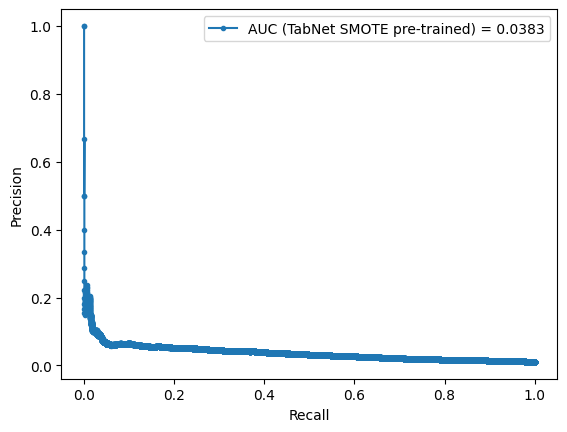

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
#y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision, recall, _ = precision_recall_curve(y_valid, probabilities)
auc_tab = auc(recall, precision)

# Plot the precision-recall curve

plt.plot(recall, precision, marker=".", label=f"AUC (TabNet SMOTE pre-trained) = {auc_tab:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
average_precision = average_precision_score(y_valid, clf.predict_proba(X_valid_array)[:, 1])

print(f'Area Under the Precision-Recall Curve (AUC-PR): {average_precision:.4f}')

Area Under the Precision-Recall Curve (AUC-PR): 0.0386


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[113001  45323]
 [   578   1098]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    158324
           1       0.02      0.66      0.05      1676

    accuracy                           0.71    160000
   macro avg       0.51      0.68      0.44    160000
weighted avg       0.98      0.71      0.82    160000



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.1312  |  0:00:03s
epoch 1  | loss: 0.05896 |  0:00:07s
epoch 2  | loss: 0.05533 |  0:00:10s
epoch 3  | loss: 0.05381 |  0:00:14s
epoch 4  | loss: 0.05184 |  0:00:17s
epoch 5  | loss: 0.05171 |  0:00:20s
epoch 6  | loss: 0.05091 |  0:00:24s
epoch 7  | loss: 0.05042 |  0:00:27s
epoch 8  | loss: 0.04996 |  0:00:30s
epoch 9  | loss: 0.05038 |  0:00:34s
epoch 10 | loss: 0.04979 |  0:00:37s
epoch 11 | loss: 0.04951 |  0:00:41s
epoch 12 | loss: 0.04901 |  0:00:44s
epoch 13 | loss: 0.04851 |  0:00:47s
epoch 14 | loss: 0.04876 |  0:00:51s
epoch 15 | loss: 0.04842 |  0:00:54s
epoch 16 | loss: 0.04842 |  0:00:58s
epoch 17 | loss: 0.04757 |  0:01:01s
epoch 18 | loss: 0.04725 |  0:01:05s
epoch 19 | loss: 0.04725 |  0:01:08s
epoch 20 | loss: 0.04675 |  0:01:11s
epoch 21 | loss: 0.04679 |  0:01:15s
epoch 22 | loss: 0.04618 |  0:01:18s
epoch 23 | loss: 0.04627 |  0:01:22s
epoch 24 | loss: 0.04632 |  0:01:25s
epoch 25 | loss: 0.04635 |  0:01:28s
epoch 26 | loss: 0.0467  |  0:01:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.3012  |  0:00:11s
epoch 1  | loss: 0.23293 |  0:00:22s
epoch 2  | loss: 0.21925 |  0:00:33s
epoch 3  | loss: 0.21113 |  0:00:44s
epoch 4  | loss: 0.19959 |  0:00:55s
epoch 5  | loss: 0.19309 |  0:01:07s
epoch 6  | loss: 0.18138 |  0:01:18s
epoch 7  | loss: 0.17537 |  0:01:29s
epoch 8  | loss: 0.17082 |  0:01:40s
epoch 9  | loss: 0.16579 |  0:01:51s
epoch 10 | loss: 0.16165 |  0:02:02s
epoch 11 | loss: 0.1556  |  0:02:13s
epoch 12 | loss: 0.15332 |  0:02:25s
epoch 13 | loss: 0.15166 |  0:02:36s
epoch 14 | loss: 0.20056 |  0:02:47s
epoch 15 | loss: 0.18473 |  0:02:58s
epoch 16 | loss: 0.16551 |  0:03:09s
epoch 17 | loss: 0.15873 |  0:03:20s
epoch 18 | loss: 0.15355 |  0:03:31s
epoch 19 | loss: 0.14804 |  0:03:42s
epoch 20 | loss: 0.14678 |  0:03:54s
epoch 21 | loss: 0.15454 |  0:04:05s
epoch 22 | loss: 0.16489 |  0:04:16s
epoch 23 | loss: 0.14692 |  0:04:27s
epoch 24 | loss: 0.14201 |  0:04:38s
epoch 25 | loss: 0.1408  |  0:04:49s
epoch 26 | loss: 0.14111 |  0:05:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.35958 |  0:00:18s
epoch 1  | loss: 0.28906 |  0:00:37s
epoch 2  | loss: 0.27708 |  0:00:56s
epoch 3  | loss: 0.2813  |  0:01:15s
epoch 4  | loss: 0.25579 |  0:01:33s
epoch 5  | loss: 0.24548 |  0:01:52s
epoch 6  | loss: 0.22819 |  0:02:11s
epoch 7  | loss: 0.21325 |  0:02:30s
epoch 8  | loss: 0.20249 |  0:02:48s
epoch 9  | loss: 0.19105 |  0:03:07s
epoch 10 | loss: 0.1846  |  0:03:26s
epoch 11 | loss: 0.18152 |  0:03:45s
epoch 12 | loss: 0.17427 |  0:04:03s
epoch 13 | loss: 0.17112 |  0:04:22s
epoch 14 | loss: 0.20474 |  0:04:41s
epoch 15 | loss: 0.18521 |  0:05:00s
epoch 16 | loss: 0.19888 |  0:05:19s
epoch 17 | loss: 0.35303 |  0:05:38s
epoch 18 | loss: 0.33797 |  0:05:57s
epoch 19 | loss: 0.3438  |  0:06:15s
epoch 20 | loss: 0.3127  |  0:06:34s
epoch 21 | loss: 0.28612 |  0:06:53s
epoch 22 | loss: 0.28025 |  0:07:12s
epoch 23 | loss: 0.28595 |  0:07:31s
epoch 24 | loss: 0.32892 |  0:07:50s
epoch 25 | loss: 0.34557 |  0:08:10s
epoch 26 | loss: 0.34547 |  0:08:29s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.32019 |  0:00:26s
epoch 1  | loss: 0.26162 |  0:00:53s
epoch 2  | loss: 0.31695 |  0:01:19s
epoch 3  | loss: 0.2951  |  0:01:46s
epoch 4  | loss: 0.2623  |  0:02:13s
epoch 5  | loss: 0.24561 |  0:02:39s
epoch 6  | loss: 0.22422 |  0:03:06s
epoch 7  | loss: 0.21201 |  0:03:33s
epoch 8  | loss: 0.199   |  0:03:59s
epoch 9  | loss: 0.19388 |  0:04:26s
epoch 10 | loss: 0.19149 |  0:04:52s
epoch 11 | loss: 0.17963 |  0:05:19s
epoch 12 | loss: 0.17283 |  0:05:45s
epoch 13 | loss: 0.16731 |  0:06:12s
epoch 14 | loss: 0.1642  |  0:06:40s
epoch 15 | loss: 0.1669  |  0:07:07s
epoch 16 | loss: 0.27643 |  0:07:33s
epoch 17 | loss: 0.42684 |  0:08:00s
epoch 18 | loss: 0.42739 |  0:08:27s
epoch 19 | loss: 0.42356 |  0:08:54s
epoch 20 | loss: 0.41677 |  0:09:21s
epoch 21 | loss: 0.41306 |  0:09:47s
epoch 22 | loss: 0.34797 |  0:10:14s
epoch 23 | loss: 0.22258 |  0:10:41s
epoch 24 | loss: 0.20182 |  0:11:08s
epoch 25 | loss: 0.19369 |  0:11:35s
epoch 26 | loss: 0.18721 |  0:12:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.29739 |  0:00:34s
epoch 1  | loss: 0.25856 |  0:01:08s
epoch 2  | loss: 0.24714 |  0:01:43s
epoch 3  | loss: 0.23484 |  0:02:17s
epoch 4  | loss: 0.26442 |  0:02:51s
epoch 5  | loss: 0.2225  |  0:03:26s
epoch 6  | loss: 0.2325  |  0:04:00s
epoch 7  | loss: 0.21102 |  0:04:34s
epoch 8  | loss: 0.19598 |  0:05:09s
epoch 9  | loss: 0.18077 |  0:05:43s
epoch 10 | loss: 0.17313 |  0:06:17s
epoch 11 | loss: 0.16482 |  0:06:52s
epoch 12 | loss: 0.15887 |  0:07:26s
epoch 13 | loss: 0.15376 |  0:08:00s
epoch 14 | loss: 0.15    |  0:08:34s
epoch 15 | loss: 0.14287 |  0:09:09s
epoch 16 | loss: 0.15052 |  0:09:43s
epoch 17 | loss: 0.14265 |  0:10:18s
epoch 18 | loss: 0.20803 |  0:10:52s
epoch 19 | loss: 0.20306 |  0:11:26s
epoch 20 | loss: 0.16591 |  0:12:01s
epoch 21 | loss: 0.15767 |  0:12:35s
epoch 22 | loss: 0.15633 |  0:13:09s
epoch 23 | loss: 0.15126 |  0:13:44s
epoch 24 | loss: 0.15073 |  0:14:18s
epoch 25 | loss: 0.1446  |  0:14:53s
epoch 26 | loss: 0.16026 |  0:15:27s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.12772 |  0:00:03s
epoch 1  | loss: 0.05523 |  0:00:06s
epoch 2  | loss: 0.05246 |  0:00:10s
epoch 3  | loss: 0.05096 |  0:00:13s
epoch 4  | loss: 0.05042 |  0:00:16s
epoch 5  | loss: 0.04933 |  0:00:20s
epoch 6  | loss: 0.04868 |  0:00:23s
epoch 7  | loss: 0.04741 |  0:00:27s
epoch 8  | loss: 0.0467  |  0:00:30s
epoch 9  | loss: 0.04652 |  0:00:33s
epoch 10 | loss: 0.04607 |  0:00:37s
epoch 11 | loss: 0.04581 |  0:00:40s
epoch 12 | loss: 0.04573 |  0:00:44s
epoch 13 | loss: 0.04574 |  0:00:47s
epoch 14 | loss: 0.04549 |  0:00:50s
epoch 15 | loss: 0.04519 |  0:00:54s
epoch 16 | loss: 0.04511 |  0:00:57s
epoch 17 | loss: 0.04477 |  0:01:01s
epoch 18 | loss: 0.0446  |  0:01:04s
epoch 19 | loss: 0.04423 |  0:01:08s
epoch 20 | loss: 0.04432 |  0:01:11s
epoch 21 | loss: 0.04363 |  0:01:15s
epoch 22 | loss: 0.04303 |  0:01:18s
epoch 23 | loss: 0.04334 |  0:01:21s
epoch 24 | loss: 0.04343 |  0:01:25s
epoch 25 | loss: 0.04255 |  0:01:28s
epoch 26 | loss: 0.04268 |  0:01:32s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07795 |  0:00:11s
epoch 1  | loss: 0.05099 |  0:00:22s
epoch 2  | loss: 0.04945 |  0:00:33s
epoch 3  | loss: 0.04872 |  0:00:44s
epoch 4  | loss: 0.04828 |  0:00:55s
epoch 5  | loss: 0.04816 |  0:01:06s
epoch 6  | loss: 0.04778 |  0:01:17s
epoch 7  | loss: 0.04736 |  0:01:29s
epoch 8  | loss: 0.04787 |  0:01:40s
epoch 9  | loss: 0.0475  |  0:01:51s
epoch 10 | loss: 0.04707 |  0:02:02s
epoch 11 | loss: 0.04711 |  0:02:13s
epoch 12 | loss: 0.04668 |  0:02:24s
epoch 13 | loss: 0.04687 |  0:02:35s
epoch 14 | loss: 0.04633 |  0:02:46s
epoch 15 | loss: 0.04625 |  0:02:57s
epoch 16 | loss: 0.04623 |  0:03:08s
epoch 17 | loss: 0.04609 |  0:03:19s
epoch 18 | loss: 0.04604 |  0:03:30s
epoch 19 | loss: 0.04597 |  0:03:41s
epoch 20 | loss: 0.04561 |  0:03:52s
epoch 21 | loss: 0.04549 |  0:04:03s
epoch 22 | loss: 0.04549 |  0:04:14s
epoch 23 | loss: 0.04532 |  0:04:25s
epoch 24 | loss: 0.04515 |  0:04:36s
epoch 25 | loss: 0.04509 |  0:04:47s
epoch 26 | loss: 0.04505 |  0:04:58s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.2051  |  0:00:18s
epoch 1  | loss: 0.16062 |  0:00:37s
epoch 2  | loss: 0.1541  |  0:00:56s
epoch 3  | loss: 0.14316 |  0:01:15s
epoch 4  | loss: 0.13758 |  0:01:33s
epoch 5  | loss: 0.14256 |  0:01:52s
epoch 6  | loss: 0.13501 |  0:02:11s
epoch 7  | loss: 0.13243 |  0:02:29s
epoch 8  | loss: 0.12692 |  0:02:48s
epoch 9  | loss: 0.12264 |  0:03:07s
epoch 10 | loss: 0.1229  |  0:03:25s
epoch 11 | loss: 0.12489 |  0:03:44s
epoch 12 | loss: 0.12006 |  0:04:02s
epoch 13 | loss: 0.11296 |  0:04:21s
epoch 14 | loss: 0.1118  |  0:04:40s
epoch 15 | loss: 0.14674 |  0:04:58s
epoch 16 | loss: 0.18481 |  0:05:17s
epoch 17 | loss: 0.16473 |  0:05:36s
epoch 18 | loss: 0.15485 |  0:05:54s
epoch 19 | loss: 0.1483  |  0:06:13s
epoch 20 | loss: 0.14373 |  0:06:32s
epoch 21 | loss: 0.14394 |  0:06:50s
epoch 22 | loss: 0.15386 |  0:07:09s
epoch 23 | loss: 0.14727 |  0:07:28s
epoch 24 | loss: 0.1391  |  0:07:47s
epoch 25 | loss: 0.13438 |  0:08:05s
epoch 26 | loss: 0.13562 |  0:08:24s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.32667 |  0:00:26s
epoch 1  | loss: 0.24475 |  0:00:52s
epoch 2  | loss: 0.21528 |  0:01:18s
epoch 3  | loss: 0.20402 |  0:01:45s
epoch 4  | loss: 0.21505 |  0:02:11s
epoch 5  | loss: 0.20552 |  0:02:37s
epoch 6  | loss: 0.20279 |  0:03:04s
epoch 7  | loss: 0.18361 |  0:03:30s
epoch 8  | loss: 0.17049 |  0:03:56s
epoch 9  | loss: 0.16405 |  0:04:22s
epoch 10 | loss: 0.16354 |  0:04:49s
epoch 11 | loss: 0.16099 |  0:05:15s
epoch 12 | loss: 0.16019 |  0:05:42s
epoch 13 | loss: 0.15354 |  0:06:08s
epoch 14 | loss: 0.15162 |  0:06:34s
epoch 15 | loss: 0.18974 |  0:07:00s
epoch 16 | loss: 0.16303 |  0:07:27s
epoch 17 | loss: 0.15436 |  0:07:53s
epoch 18 | loss: 0.15327 |  0:08:19s
epoch 19 | loss: 0.14971 |  0:08:45s
epoch 20 | loss: 0.15285 |  0:09:11s
epoch 21 | loss: 0.14761 |  0:09:38s
epoch 22 | loss: 0.14936 |  0:10:04s
epoch 23 | loss: 0.14574 |  0:10:30s
epoch 24 | loss: 0.14694 |  0:10:56s
epoch 25 | loss: 0.14536 |  0:11:23s
epoch 26 | loss: 0.1516  |  0:11:49s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.31329 |  0:00:33s
epoch 1  | loss: 0.26286 |  0:01:07s
epoch 2  | loss: 0.2615  |  0:01:41s
epoch 3  | loss: 0.28462 |  0:02:15s
epoch 4  | loss: 0.24366 |  0:02:49s
epoch 5  | loss: 0.23631 |  0:03:23s
epoch 6  | loss: 0.21362 |  0:03:57s
epoch 7  | loss: 0.2042  |  0:04:31s
epoch 8  | loss: 0.19357 |  0:05:05s
epoch 9  | loss: 0.19361 |  0:05:39s
epoch 10 | loss: 0.31579 |  0:06:12s
epoch 11 | loss: 0.26967 |  0:06:46s
epoch 12 | loss: 0.22881 |  0:07:21s
epoch 13 | loss: 0.21255 |  0:07:55s
epoch 14 | loss: 0.1984  |  0:08:29s
epoch 15 | loss: 0.19001 |  0:09:07s
epoch 16 | loss: 0.23354 |  0:09:41s
epoch 17 | loss: 0.18383 |  0:10:15s
epoch 18 | loss: 0.17434 |  0:10:49s
epoch 19 | loss: 0.17273 |  0:11:26s
epoch 20 | loss: 0.16516 |  0:12:02s
epoch 21 | loss: 0.16101 |  0:12:37s
epoch 22 | loss: 0.16471 |  0:13:14s
epoch 23 | loss: 0.15753 |  0:13:51s
epoch 24 | loss: 0.15351 |  0:14:28s
epoch 25 | loss: 0.15189 |  0:15:05s
epoch 26 | loss: 0.15064 |  0:15:42s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.12772 |  0:00:03s
epoch 1  | loss: 0.05523 |  0:00:07s
epoch 2  | loss: 0.05246 |  0:00:11s
epoch 3  | loss: 0.05096 |  0:00:14s
epoch 4  | loss: 0.05042 |  0:00:18s
epoch 5  | loss: 0.04933 |  0:00:22s
epoch 6  | loss: 0.04868 |  0:00:26s
epoch 7  | loss: 0.04741 |  0:00:29s
epoch 8  | loss: 0.0467  |  0:00:33s
epoch 9  | loss: 0.04652 |  0:00:37s
epoch 10 | loss: 0.04607 |  0:00:40s
epoch 11 | loss: 0.04581 |  0:00:44s
epoch 12 | loss: 0.04573 |  0:00:48s
epoch 13 | loss: 0.04574 |  0:00:52s
epoch 14 | loss: 0.04549 |  0:00:55s
epoch 15 | loss: 0.04519 |  0:00:59s
epoch 16 | loss: 0.04511 |  0:01:03s
epoch 17 | loss: 0.04477 |  0:01:06s
epoch 18 | loss: 0.0446  |  0:01:10s
epoch 19 | loss: 0.04423 |  0:01:14s
epoch 20 | loss: 0.04432 |  0:01:18s
epoch 21 | loss: 0.04363 |  0:01:21s
epoch 22 | loss: 0.04303 |  0:01:25s
epoch 23 | loss: 0.04334 |  0:01:29s
epoch 24 | loss: 0.04343 |  0:01:33s
epoch 25 | loss: 0.04255 |  0:01:36s
epoch 26 | loss: 0.04268 |  0:01:40s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07795 |  0:00:11s
epoch 1  | loss: 0.05099 |  0:00:24s
epoch 2  | loss: 0.04945 |  0:00:36s
epoch 3  | loss: 0.04872 |  0:00:48s
epoch 4  | loss: 0.04828 |  0:01:00s
epoch 5  | loss: 0.04816 |  0:01:12s
epoch 6  | loss: 0.04778 |  0:01:24s
epoch 7  | loss: 0.04736 |  0:01:36s
epoch 8  | loss: 0.04787 |  0:01:48s
epoch 9  | loss: 0.0475  |  0:02:00s
epoch 10 | loss: 0.04707 |  0:02:12s
epoch 11 | loss: 0.04711 |  0:02:24s
epoch 12 | loss: 0.04668 |  0:02:36s
epoch 13 | loss: 0.04687 |  0:02:48s
epoch 14 | loss: 0.04633 |  0:03:00s
epoch 15 | loss: 0.04625 |  0:03:13s
epoch 16 | loss: 0.04623 |  0:03:25s
epoch 17 | loss: 0.04609 |  0:03:37s
epoch 18 | loss: 0.04604 |  0:03:49s
epoch 19 | loss: 0.04597 |  0:04:01s
epoch 20 | loss: 0.04561 |  0:04:13s
epoch 21 | loss: 0.04549 |  0:04:25s
epoch 22 | loss: 0.04549 |  0:04:38s
epoch 23 | loss: 0.04532 |  0:04:50s
epoch 24 | loss: 0.04515 |  0:05:02s
epoch 25 | loss: 0.04509 |  0:05:14s
epoch 26 | loss: 0.04505 |  0:05:26s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.06681 |  0:00:20s
epoch 1  | loss: 0.04939 |  0:00:41s
epoch 2  | loss: 0.04848 |  0:01:01s
epoch 3  | loss: 0.04814 |  0:01:21s
epoch 4  | loss: 0.04772 |  0:01:42s
epoch 5  | loss: 0.04725 |  0:02:02s
epoch 6  | loss: 0.0472  |  0:02:23s
epoch 7  | loss: 0.047   |  0:02:43s
epoch 8  | loss: 0.04721 |  0:03:03s
epoch 9  | loss: 0.04683 |  0:03:24s
epoch 10 | loss: 0.04669 |  0:03:44s
epoch 11 | loss: 0.04655 |  0:04:05s
epoch 12 | loss: 0.04627 |  0:04:25s
epoch 13 | loss: 0.04615 |  0:04:45s
epoch 14 | loss: 0.0461  |  0:05:06s
epoch 15 | loss: 0.04609 |  0:05:26s
epoch 16 | loss: 0.04599 |  0:05:47s
epoch 17 | loss: 0.04583 |  0:06:07s
epoch 18 | loss: 0.04582 |  0:06:28s
epoch 19 | loss: 0.04576 |  0:06:49s
epoch 20 | loss: 0.04584 |  0:07:09s
epoch 21 | loss: 0.04549 |  0:07:30s
epoch 22 | loss: 0.04536 |  0:07:50s
epoch 23 | loss: 0.04521 |  0:08:11s
epoch 24 | loss: 0.04524 |  0:08:31s
epoch 25 | loss: 0.04505 |  0:08:52s
epoch 26 | loss: 0.04505 |  0:09:12s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.1143  |  0:00:28s
epoch 1  | loss: 0.09266 |  0:00:57s
epoch 2  | loss: 0.08994 |  0:01:26s
epoch 3  | loss: 0.0825  |  0:01:55s
epoch 4  | loss: 0.08065 |  0:02:23s
epoch 5  | loss: 0.08723 |  0:02:52s
epoch 6  | loss: 0.08811 |  0:03:21s
epoch 7  | loss: 0.08161 |  0:03:50s
epoch 8  | loss: 0.1025  |  0:04:19s
epoch 9  | loss: 0.08815 |  0:04:48s
epoch 10 | loss: 0.08866 |  0:05:16s
epoch 11 | loss: 0.08768 |  0:05:45s
epoch 12 | loss: 0.0929  |  0:06:14s
epoch 13 | loss: 0.09087 |  0:06:43s
epoch 14 | loss: 0.09105 |  0:07:11s
epoch 15 | loss: 0.09875 |  0:07:40s
epoch 16 | loss: 0.09261 |  0:08:09s
epoch 17 | loss: 0.092   |  0:08:38s
epoch 18 | loss: 0.09426 |  0:09:07s
epoch 19 | loss: 0.09266 |  0:09:35s
epoch 20 | loss: 0.09254 |  0:10:04s
epoch 21 | loss: 0.09097 |  0:10:33s
epoch 22 | loss: 0.0905  |  0:11:02s
epoch 23 | loss: 0.08717 |  0:11:30s
epoch 24 | loss: 0.08668 |  0:11:59s
epoch 25 | loss: 0.09142 |  0:12:28s
epoch 26 | loss: 0.08785 |  0:12:57s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.27265 |  0:00:36s
epoch 1  | loss: 0.23147 |  0:01:13s
epoch 2  | loss: 0.21026 |  0:01:50s
epoch 3  | loss: 0.19055 |  0:02:27s
epoch 4  | loss: 0.18255 |  0:03:05s
epoch 5  | loss: 0.17959 |  0:03:42s
epoch 6  | loss: 0.17398 |  0:04:19s
epoch 7  | loss: 0.1699  |  0:04:56s
epoch 8  | loss: 0.17037 |  0:05:33s
epoch 9  | loss: 0.17434 |  0:06:11s
epoch 10 | loss: 0.18174 |  0:06:48s
epoch 11 | loss: 0.17342 |  0:07:25s
epoch 12 | loss: 0.17404 |  0:08:02s
epoch 13 | loss: 0.16923 |  0:08:39s
epoch 14 | loss: 0.16802 |  0:09:16s
epoch 15 | loss: 0.2021  |  0:09:53s
epoch 16 | loss: 0.1788  |  0:10:31s
epoch 17 | loss: 0.17047 |  0:11:08s
epoch 18 | loss: 0.16825 |  0:11:45s
epoch 19 | loss: 0.16716 |  0:12:22s
epoch 20 | loss: 0.16491 |  0:12:59s
epoch 21 | loss: 0.16278 |  0:13:36s
epoch 22 | loss: 0.16083 |  0:14:14s
epoch 23 | loss: 0.17591 |  0:14:51s
epoch 24 | loss: 0.16418 |  0:15:28s
epoch 25 | loss: 0.16433 |  0:16:05s
epoch 26 | loss: 0.16696 |  0:16:42s
e

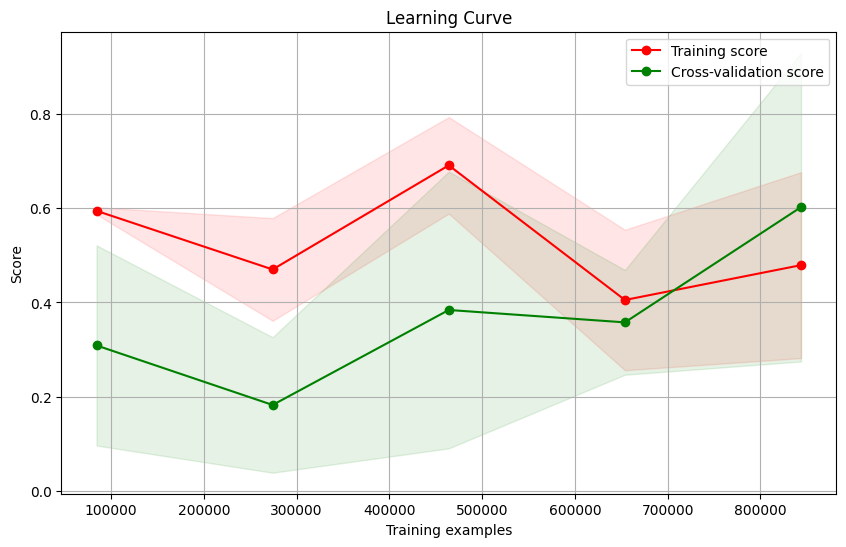

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = "f1_macro"
plot_learning_curve(clf, X_train_array, y_train_resampled, scoring, train_sizes)

In [ ]:
##custom scorer
from sklearn.metrics import recall_score
#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_valid_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)



Chosen threshold: 0.9999630451202393
False Positive Rate: 0.0
Recall: 0.0005966587112171838
[[158324      0]
 [  1675      1]]


In [ ]:
##import adasyn splits

X_train_resampled = pd.read_csv('X_train_transformed_adasyn.csv')

y_train_resampled = pd.read_csv('y_train_adasyn.csv')

y_train_resampled = np.ravel(y_train_resampled.values)
X_train_array = X_train_resampled.values  #convert DataFrame to NumPy array

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:
##2/7 adasyn unsupervised pre-training

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.8,  # Ratio of training data used for pre-training ##better results with 0.8 for adasyn, while smote is (a tad) better with 0.5 vs 0.8
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  # This will be overwritten if using pretrain model
)

# Fit the model to your labeled training data
clf.fit(
    X_train=X_train_array,
    y_train=y_train_resampled,
    eval_set=[(X_train_array, y_train_resampled), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    from_unsupervised=unsupervised_model
)


# Save the trained model to a file
#joblib.dump(clf, 'tabnet_adasyn_pretrained.pkl')

y_pred = clf.predict(X_valid_array)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.53869 | val_0_unsup_loss_numpy: 0.8701500296592712|  0:01:09s
epoch 1  | loss: 1.21386 | val_0_unsup_loss_numpy: 0.7415800094604492|  0:02:22s
epoch 2  | loss: 0.89094 | val_0_unsup_loss_numpy: 0.7331699728965759|  0:03:35s
epoch 3  | loss: 1.00522 | val_0_unsup_loss_numpy: 0.7304999828338623|  0:04:48s
epoch 4  | loss: 1.29852 | val_0_unsup_loss_numpy: 0.7214300036430359|  0:06:01s
epoch 5  | loss: 1.02762 | val_0_unsup_loss_numpy: 0.7211599946022034|  0:07:14s
epoch 6  | loss: 0.95973 | val_0_unsup_loss_numpy: 0.7264599800109863|  0:08:27s
epoch 7  | loss: 0.92271 | val_0_unsup_loss_numpy: 0.7273600101470947|  0:09:39s
epoch 8  | loss: 1.19174 | val_0_unsup_loss_numpy: 0.7281399965286255|  0:10:52s
epoch 9  | loss: 1.18436 | val_0_unsup_loss_numpy: 0.7294600009918213|  0:12:05s
epoch 10 | loss: 1.5265  | val_0_unsup_loss_numpy: 0.7260900139808655|  0:13:19s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.7211599946022034

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.27726 | train_f1_macro: 0.61921 | valid_f1_macro: 0.26941 |  0:01:32s
epoch 1  | loss: 0.19584 | train_f1_macro: 0.45342 | valid_f1_macro: 0.11824 |  0:03:06s
epoch 2  | loss: 0.18211 | train_f1_macro: 0.45425 | valid_f1_macro: 0.11837 |  0:04:41s
epoch 3  | loss: 0.1718  | train_f1_macro: 0.33728 | valid_f1_macro: 0.01411 |  0:06:15s
epoch 4  | loss: 0.16428 | train_f1_macro: 0.41029 | valid_f1_macro: 0.08056 |  0:07:50s
epoch 5  | loss: 0.16156 | train_f1_macro: 0.61648 | valid_f1_macro: 0.25897 |  0:09:25s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_valid_f1_macro = 0.26941


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
##save to file
import dill

# Save the trained model to a file using dill
with open('tabnet_adasyn_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-a8d199ef3f5f>", line 5, in <cell line: 5>
    with open('tabnet_adasyn_pretrained.pkl', 'wb') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'tabnet_adasyn_pretrained.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_cont

In [ ]:
f1_macro = f1_score(y_valid, y_pred, average='macro')
print(f1_macro)

0.4462034939359617


In [ ]:
f1_weighted = f1_score(y_valid, y_pred, average='weighted')
print(f1_weighted)

0.8366614522595559


In [ ]:
average_precision = average_precision_score(y_valid, clf.predict_proba(X_valid_array)[:, 1])

print(f'Area Under the Precision-Recall Curve (AUC-PR): {average_precision:.4f}')

Area Under the Precision-Recall Curve (AUC-PR): 0.0384


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[132583  25741]
 [   604   1072]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    158324
           1       0.04      0.64      0.08      1676

    accuracy                           0.84    160000
   macro avg       0.52      0.74      0.49    160000
weighted avg       0.99      0.84      0.90    160000



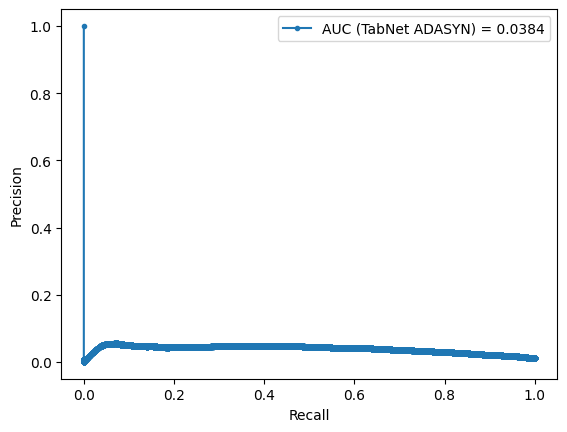

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_tab, recall_tab, _ = precision_recall_curve(y_valid, probabilities)
auc_tab = auc(recall_tab, precision_tab)

# Plot the precision-recall curve

plt.plot(recall_tab, precision_tab, marker=".", label=f"AUC (TabNet ADASYN) = {auc_tab:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
##custom scorer
from sklearn.metrics import recall_score

#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_valid_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Chosen threshold: 0.9999799728393555
False Positive Rate: 6.316161794800536e-06
Recall: 0.0
[[158323      1]
 [  1676      0]]


In [ ]:
##data import random undersampling
X_train_undersampled = pd.read_csv('X_train_random_undersampl.csv')

y_train_undersampled = pd.read_csv('y_train_random_undersampl.csv')

y_train_undersampled = np.ravel(y_train_undersampled.values)
X_train_array = X_train_undersampled.values

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:
##unsupervised pre-training

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.5,  # Ratio of training data used for pre-training
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  # This will be overwritten if using pretrain model
)

# Fit the model to your labeled training data
clf.fit(
    X_train=X_train_array,
    y_train=y_train_undersampled,
    eval_set=[(X_train_array, y_train_undersampled), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    from_unsupervised=unsupervised_model
)

# Save the trained model to a file
joblib.dump(clf, 'tabnet_random_undersampling_pretrained.pkl')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 53.79334| val_0_unsup_loss_numpy: 27.888879776000977|  0:00:06s
epoch 1  | loss: 8.36751 | val_0_unsup_loss_numpy: 26.604520797729492|  0:00:12s
epoch 2  | loss: 2.35687 | val_0_unsup_loss_numpy: 5.852640151977539|  0:00:17s
epoch 3  | loss: 1.48916 | val_0_unsup_loss_numpy: 2.2083001136779785|  0:00:22s
epoch 4  | loss: 1.27468 | val_0_unsup_loss_numpy: 1.5767799615859985|  0:00:28s
epoch 5  | loss: 1.14569 | val_0_unsup_loss_numpy: 2.008729934692383|  0:00:33s
epoch 6  | loss: 1.01337 | val_0_unsup_loss_numpy: 1.5735100507736206|  0:00:38s
epoch 7  | loss: 1.07744 | val_0_unsup_loss_numpy: 2.0848100185394287|  0:00:44s
epoch 8  | loss: 1.03998 | val_0_unsup_loss_numpy: 3.583169937133789|  0:00:49s
epoch 9  | loss: 1.19623 | val_0_unsup_loss_numpy: 1.6731599569320679|  0:00:55s
epoch 10 | loss: 1.03584 | val_0_unsup_loss_numpy: 1.8868199586868286|  0:01:00s
epoch 11 | loss: 0.98748 | val_0_unsup_loss_numpy: 1.7441699504852295|  0:01:05s

Early stopping occurred at epo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.75151 | train_f1_macro: 0.54282 | valid_f1_macro: 0.27157 |  0:00:04s
epoch 1  | loss: 0.56729 | train_f1_macro: 0.57347 | valid_f1_macro: 0.24411 |  0:00:08s
epoch 2  | loss: 0.52687 | train_f1_macro: 0.59456 | valid_f1_macro: 0.25971 |  0:00:12s
epoch 3  | loss: 0.50238 | train_f1_macro: 0.66087 | valid_f1_macro: 0.3175  |  0:00:16s
epoch 4  | loss: 0.48245 | train_f1_macro: 0.6925  | valid_f1_macro: 0.35161 |  0:00:21s
epoch 5  | loss: 0.46981 | train_f1_macro: 0.72456 | valid_f1_macro: 0.38498 |  0:00:25s
epoch 6  | loss: 0.46164 | train_f1_macro: 0.74137 | valid_f1_macro: 0.39213 |  0:00:29s
epoch 7  | loss: 0.45638 | train_f1_macro: 0.762   | valid_f1_macro: 0.41056 |  0:00:34s
epoch 8  | loss: 0.45384 | train_f1_macro: 0.77949 | valid_f1_macro: 0.42488 |  0:00:38s
epoch 9  | loss: 0.44645 | train_f1_macro: 0.78353 | valid_f1_macro: 0.42951 |  0:00:42s
epoch 10 | loss: 0.44428 | train_f1_macro: 0.78156 | valid_f1_macro: 0.4235  |  0:00:46s
epoch 11 | loss: 0.43

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


['tabnet_stratified_undersampling_pretrained.pkl']

In [ ]:
joblib.dump(clf, 'tabnet_random_undersampling_pretrained.pkl')

['tabnet_random_undersampling_pretrained.pkl']

In [ ]:
y_pred = clf.predict(X_valid_array)

In [ ]:
f1_macro = f1_score(y_valid, y_pred, average='macro')
print(f"Final Validation F1 Macro with Best Model: {f1_macro}")

Final Validation F1 Macro with Best Model: 0.4809826489477202


In [ ]:
f1_weighted = f1_score(y_valid, y_pred, average='weighted')
print(f"Final Validation F1 Weighted with Best Model: {f1_weighted}")

Final Validation F1 Weighted with Best Model: 0.8790943686187122


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[126642  31682]
 [   388   1288]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    158324
           1       0.04      0.77      0.07      1676

    accuracy                           0.80    160000
   macro avg       0.52      0.78      0.48    160000
weighted avg       0.99      0.80      0.88    160000



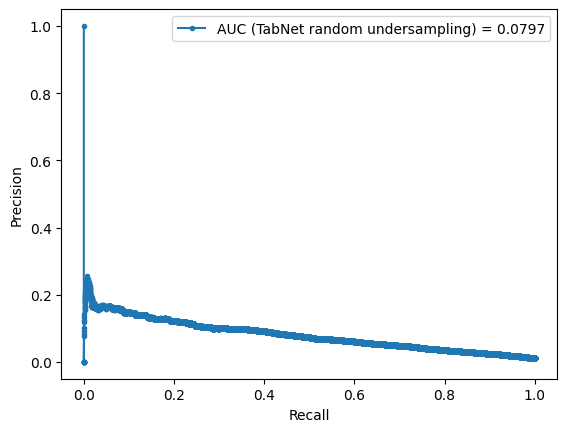

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision, recall, _ = precision_recall_curve(y_valid, probabilities)
auc = auc(recall, precision)

# Plot the precision-recall curve

plt.plot(recall, precision, marker=".", label=f"AUC (TabNet random undersampling) = {auc:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
##custom scorer
from sklearn.metrics import recall_score

#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_valid_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Chosen threshold: 0.9999512434005737
False Positive Rate: 6.316161794800536e-06
Recall: 0.0
[[158323      1]
 [  1676      0]]


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00249 |  0:00:00s
epoch 1  | loss: 0.00239 |  0:00:00s
epoch 2  | loss: 0.00227 |  0:00:00s
epoch 3  | loss: 0.00219 |  0:00:00s
epoch 4  | loss: 0.00212 |  0:00:00s
epoch 5  | loss: 0.00205 |  0:00:00s
epoch 6  | loss: 0.00199 |  0:00:00s
epoch 7  | loss: 0.00192 |  0:00:00s
epoch 8  | loss: 0.00185 |  0:00:00s
epoch 9  | loss: 0.00175 |  0:00:00s
epoch 10 | loss: 0.0017  |  0:00:00s
epoch 11 | loss: 0.00161 |  0:00:00s
epoch 12 | loss: 0.00156 |  0:00:00s
epoch 13 | loss: 0.00148 |  0:00:00s
epoch 14 | loss: 0.00143 |  0:00:00s
epoch 15 | loss: 0.00134 |  0:00:00s
epoch 16 | loss: 0.0013  |  0:00:00s
epoch 17 | loss: 0.00121 |  0:00:00s
epoch 18 | loss: 0.00117 |  0:00:00s
epoch 19 | loss: 0.00112 |  0:00:00s
epoch 20 | loss: 0.00106 |  0:00:00s
epoch 21 | loss: 0.00099 |  0:00:00s
epoch 22 | loss: 0.00093 |  0:00:00s
epoch 23 | loss: 0.0009  |  0:00:00s
epoch 24 | loss: 0.00084 |  0:00:01s
epoch 25 | loss: 0.00078 |  0:00:01s
epoch 26 | loss: 0.00074 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.18918 |  0:00:00s
epoch 1  | loss: 0.73188 |  0:00:00s
epoch 2  | loss: 0.57784 |  0:00:00s
epoch 3  | loss: 0.48008 |  0:00:00s
epoch 4  | loss: 0.47878 |  0:00:00s
epoch 5  | loss: 0.46425 |  0:00:00s
epoch 6  | loss: 0.45272 |  0:00:00s
epoch 7  | loss: 0.42662 |  0:00:00s
epoch 8  | loss: 0.43121 |  0:00:00s
epoch 9  | loss: 0.39168 |  0:00:00s
epoch 10 | loss: 0.38249 |  0:00:00s
epoch 11 | loss: 0.38101 |  0:00:00s
epoch 12 | loss: 0.38332 |  0:00:01s
epoch 13 | loss: 0.37455 |  0:00:01s
epoch 14 | loss: 0.36849 |  0:00:01s
epoch 15 | loss: 0.35417 |  0:00:01s
epoch 16 | loss: 0.36319 |  0:00:01s
epoch 17 | loss: 0.35498 |  0:00:01s
epoch 18 | loss: 0.35629 |  0:00:01s
epoch 19 | loss: 0.34859 |  0:00:01s
epoch 20 | loss: 0.36327 |  0:00:01s
epoch 21 | loss: 0.33017 |  0:00:01s
epoch 22 | loss: 0.3151  |  0:00:01s
epoch 23 | loss: 0.33708 |  0:00:01s
epoch 24 | loss: 0.33541 |  0:00:01s
epoch 25 | loss: 0.33432 |  0:00:02s
epoch 26 | loss: 0.32815 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90446 |  0:00:00s
epoch 1  | loss: 0.70363 |  0:00:00s
epoch 2  | loss: 0.67459 |  0:00:00s
epoch 3  | loss: 0.65575 |  0:00:00s
epoch 4  | loss: 0.59666 |  0:00:00s
epoch 5  | loss: 0.582   |  0:00:00s
epoch 6  | loss: 0.56565 |  0:00:00s
epoch 7  | loss: 0.55792 |  0:00:00s
epoch 8  | loss: 0.53347 |  0:00:01s
epoch 9  | loss: 0.52201 |  0:00:01s
epoch 10 | loss: 0.51691 |  0:00:01s
epoch 11 | loss: 0.51923 |  0:00:01s
epoch 12 | loss: 0.48859 |  0:00:01s
epoch 13 | loss: 0.489   |  0:00:01s
epoch 14 | loss: 0.48182 |  0:00:01s
epoch 15 | loss: 0.47771 |  0:00:01s
epoch 16 | loss: 0.46499 |  0:00:02s
epoch 17 | loss: 0.46825 |  0:00:02s
epoch 18 | loss: 0.46719 |  0:00:02s
epoch 19 | loss: 0.45529 |  0:00:02s
epoch 20 | loss: 0.46006 |  0:00:02s
epoch 21 | loss: 0.45557 |  0:00:02s
epoch 22 | loss: 0.4458  |  0:00:02s
epoch 23 | loss: 0.44049 |  0:00:02s
epoch 24 | loss: 0.4419  |  0:00:03s
epoch 25 | loss: 0.43545 |  0:00:03s
epoch 26 | loss: 0.41888 |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82184 |  0:00:00s
epoch 1  | loss: 0.68435 |  0:00:00s
epoch 2  | loss: 0.6317  |  0:00:00s
epoch 3  | loss: 0.60591 |  0:00:00s
epoch 4  | loss: 0.58369 |  0:00:01s
epoch 5  | loss: 0.54997 |  0:00:01s
epoch 6  | loss: 0.54146 |  0:00:01s
epoch 7  | loss: 0.51872 |  0:00:01s
epoch 8  | loss: 0.50323 |  0:00:01s
epoch 9  | loss: 0.49281 |  0:00:01s
epoch 10 | loss: 0.49202 |  0:00:01s
epoch 11 | loss: 0.4909  |  0:00:02s
epoch 12 | loss: 0.46499 |  0:00:02s
epoch 13 | loss: 0.4606  |  0:00:02s
epoch 14 | loss: 0.45584 |  0:00:02s
epoch 15 | loss: 0.44725 |  0:00:02s
epoch 16 | loss: 0.4511  |  0:00:02s
epoch 17 | loss: 0.45196 |  0:00:03s
epoch 18 | loss: 0.44414 |  0:00:03s
epoch 19 | loss: 0.43197 |  0:00:03s
epoch 20 | loss: 0.43214 |  0:00:03s
epoch 21 | loss: 0.42626 |  0:00:03s
epoch 22 | loss: 0.42932 |  0:00:03s
epoch 23 | loss: 0.41551 |  0:00:04s
epoch 24 | loss: 0.41607 |  0:00:04s
epoch 25 | loss: 0.40559 |  0:00:04s
epoch 26 | loss: 0.40315 |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76275 |  0:00:00s
epoch 1  | loss: 0.65188 |  0:00:00s
epoch 2  | loss: 0.6046  |  0:00:00s
epoch 3  | loss: 0.56519 |  0:00:00s
epoch 4  | loss: 0.54313 |  0:00:01s
epoch 5  | loss: 0.52748 |  0:00:01s
epoch 6  | loss: 0.51093 |  0:00:01s
epoch 7  | loss: 0.5017  |  0:00:01s
epoch 8  | loss: 0.49178 |  0:00:01s
epoch 9  | loss: 0.49161 |  0:00:01s
epoch 10 | loss: 0.46184 |  0:00:02s
epoch 11 | loss: 0.46011 |  0:00:02s
epoch 12 | loss: 0.45911 |  0:00:02s
epoch 13 | loss: 0.45162 |  0:00:02s
epoch 14 | loss: 0.43995 |  0:00:02s
epoch 15 | loss: 0.43022 |  0:00:03s
epoch 16 | loss: 0.42926 |  0:00:03s
epoch 17 | loss: 0.42629 |  0:00:03s
epoch 18 | loss: 0.42144 |  0:00:03s
epoch 19 | loss: 0.42531 |  0:00:03s
epoch 20 | loss: 0.41636 |  0:00:04s
epoch 21 | loss: 0.41549 |  0:00:04s
epoch 22 | loss: 0.40288 |  0:00:04s
epoch 23 | loss: 0.41056 |  0:00:04s
epoch 24 | loss: 0.39474 |  0:00:04s
epoch 25 | loss: 0.40095 |  0:00:05s
epoch 26 | loss: 0.3958  |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.72023 |  0:00:00s
epoch 1  | loss: 0.62915 |  0:00:00s
epoch 2  | loss: 0.57967 |  0:00:00s
epoch 3  | loss: 0.54014 |  0:00:00s
epoch 4  | loss: 0.52098 |  0:00:01s
epoch 5  | loss: 0.51232 |  0:00:01s
epoch 6  | loss: 0.49556 |  0:00:01s
epoch 7  | loss: 0.49077 |  0:00:01s
epoch 8  | loss: 0.47815 |  0:00:02s
epoch 9  | loss: 0.46609 |  0:00:02s
epoch 10 | loss: 0.45562 |  0:00:02s
epoch 11 | loss: 0.44284 |  0:00:02s
epoch 12 | loss: 0.43965 |  0:00:03s
epoch 13 | loss: 0.44021 |  0:00:03s
epoch 14 | loss: 0.43741 |  0:00:03s
epoch 15 | loss: 0.42535 |  0:00:03s
epoch 16 | loss: 0.42165 |  0:00:04s
epoch 17 | loss: 0.4183  |  0:00:04s
epoch 18 | loss: 0.41607 |  0:00:04s
epoch 19 | loss: 0.40382 |  0:00:05s
epoch 20 | loss: 0.40547 |  0:00:05s
epoch 21 | loss: 0.39911 |  0:00:05s
epoch 22 | loss: 0.39903 |  0:00:05s
epoch 23 | loss: 0.39582 |  0:00:06s
epoch 24 | loss: 0.39727 |  0:00:06s
epoch 25 | loss: 0.39182 |  0:00:06s
epoch 26 | loss: 0.39482 |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.67967 |  0:00:00s
epoch 1  | loss: 0.58587 |  0:00:00s
epoch 2  | loss: 0.53491 |  0:00:00s
epoch 3  | loss: 0.50496 |  0:00:01s
epoch 4  | loss: 0.49026 |  0:00:01s
epoch 5  | loss: 0.46477 |  0:00:01s
epoch 6  | loss: 0.45815 |  0:00:01s
epoch 7  | loss: 0.44986 |  0:00:02s
epoch 8  | loss: 0.43403 |  0:00:02s
epoch 9  | loss: 0.4319  |  0:00:02s
epoch 10 | loss: 0.42785 |  0:00:03s
epoch 11 | loss: 0.41907 |  0:00:03s
epoch 12 | loss: 0.40782 |  0:00:03s
epoch 13 | loss: 0.40939 |  0:00:03s
epoch 14 | loss: 0.4034  |  0:00:04s
epoch 15 | loss: 0.3951  |  0:00:04s
epoch 16 | loss: 0.39584 |  0:00:04s
epoch 17 | loss: 0.39114 |  0:00:04s
epoch 18 | loss: 0.38591 |  0:00:05s
epoch 19 | loss: 0.38379 |  0:00:05s
epoch 20 | loss: 0.37971 |  0:00:05s
epoch 21 | loss: 0.3749  |  0:00:06s
epoch 22 | loss: 0.37455 |  0:00:06s
epoch 23 | loss: 0.3707  |  0:00:06s
epoch 24 | loss: 0.376   |  0:00:06s
epoch 25 | loss: 0.37066 |  0:00:07s
epoch 26 | loss: 0.3698  |  0:00:07s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.63925 |  0:00:00s
epoch 1  | loss: 0.54505 |  0:00:00s
epoch 2  | loss: 0.50438 |  0:00:00s
epoch 3  | loss: 0.4632  |  0:00:01s
epoch 4  | loss: 0.44897 |  0:00:01s
epoch 5  | loss: 0.43394 |  0:00:01s
epoch 6  | loss: 0.41581 |  0:00:02s
epoch 7  | loss: 0.41416 |  0:00:02s
epoch 8  | loss: 0.40715 |  0:00:02s
epoch 9  | loss: 0.39759 |  0:00:03s
epoch 10 | loss: 0.39706 |  0:00:03s
epoch 11 | loss: 0.38658 |  0:00:03s
epoch 12 | loss: 0.38649 |  0:00:04s
epoch 13 | loss: 0.38312 |  0:00:04s
epoch 14 | loss: 0.37852 |  0:00:04s
epoch 15 | loss: 0.37303 |  0:00:05s
epoch 16 | loss: 0.37426 |  0:00:05s
epoch 17 | loss: 0.37835 |  0:00:05s
epoch 18 | loss: 0.36951 |  0:00:06s
epoch 19 | loss: 0.37181 |  0:00:06s
epoch 20 | loss: 0.36045 |  0:00:06s
epoch 21 | loss: 0.36133 |  0:00:07s
epoch 22 | loss: 0.35925 |  0:00:07s
epoch 23 | loss: 0.35534 |  0:00:07s
epoch 24 | loss: 0.35138 |  0:00:08s
epoch 25 | loss: 0.35592 |  0:00:08s
epoch 26 | loss: 0.35561 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.60103 |  0:00:00s
epoch 1  | loss: 0.51839 |  0:00:00s
epoch 2  | loss: 0.47546 |  0:00:01s
epoch 3  | loss: 0.4582  |  0:00:01s
epoch 4  | loss: 0.44494 |  0:00:01s
epoch 5  | loss: 0.43479 |  0:00:02s
epoch 6  | loss: 0.42223 |  0:00:02s
epoch 7  | loss: 0.41702 |  0:00:02s
epoch 8  | loss: 0.4056  |  0:00:03s
epoch 9  | loss: 0.39845 |  0:00:03s
epoch 10 | loss: 0.39575 |  0:00:03s
epoch 11 | loss: 0.38901 |  0:00:04s
epoch 12 | loss: 0.38179 |  0:00:04s
epoch 13 | loss: 0.37594 |  0:00:04s
epoch 14 | loss: 0.37109 |  0:00:05s
epoch 15 | loss: 0.36345 |  0:00:05s
epoch 16 | loss: 0.36138 |  0:00:06s
epoch 17 | loss: 0.36234 |  0:00:06s
epoch 18 | loss: 0.36024 |  0:00:06s
epoch 19 | loss: 0.35249 |  0:00:07s
epoch 20 | loss: 0.35079 |  0:00:07s
epoch 21 | loss: 0.34467 |  0:00:07s
epoch 22 | loss: 0.35026 |  0:00:08s
epoch 23 | loss: 0.34559 |  0:00:08s
epoch 24 | loss: 0.34411 |  0:00:08s
epoch 25 | loss: 0.33621 |  0:00:09s
epoch 26 | loss: 0.33961 |  0:00:09s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00247 |  0:00:00s
epoch 1  | loss: 0.00242 |  0:00:00s
epoch 2  | loss: 0.00231 |  0:00:00s
epoch 3  | loss: 0.00222 |  0:00:00s
epoch 4  | loss: 0.00213 |  0:00:00s
epoch 5  | loss: 0.00205 |  0:00:00s
epoch 6  | loss: 0.00198 |  0:00:00s
epoch 7  | loss: 0.0019  |  0:00:00s
epoch 8  | loss: 0.00184 |  0:00:00s
epoch 9  | loss: 0.00174 |  0:00:00s
epoch 10 | loss: 0.00168 |  0:00:00s
epoch 11 | loss: 0.00162 |  0:00:00s
epoch 12 | loss: 0.00157 |  0:00:00s
epoch 13 | loss: 0.0015  |  0:00:00s
epoch 14 | loss: 0.00144 |  0:00:00s
epoch 15 | loss: 0.00137 |  0:00:00s
epoch 16 | loss: 0.0013  |  0:00:00s
epoch 17 | loss: 0.00125 |  0:00:00s
epoch 18 | loss: 0.00119 |  0:00:00s
epoch 19 | loss: 0.00113 |  0:00:00s
epoch 20 | loss: 0.00109 |  0:00:00s
epoch 21 | loss: 0.00103 |  0:00:00s
epoch 22 | loss: 0.00098 |  0:00:00s
epoch 23 | loss: 0.00093 |  0:00:00s
epoch 24 | loss: 0.00086 |  0:00:01s
epoch 25 | loss: 0.00083 |  0:00:01s
epoch 26 | loss: 0.00077 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00246 |  0:00:00s
epoch 1  | loss: 0.00227 |  0:00:00s
epoch 2  | loss: 0.00212 |  0:00:00s
epoch 3  | loss: 0.00197 |  0:00:00s
epoch 4  | loss: 0.00186 |  0:00:00s
epoch 5  | loss: 0.00172 |  0:00:00s
epoch 6  | loss: 0.00161 |  0:00:00s
epoch 7  | loss: 0.00152 |  0:00:00s
epoch 8  | loss: 0.00138 |  0:00:00s
epoch 9  | loss: 0.00125 |  0:00:00s
epoch 10 | loss: 0.00113 |  0:00:00s
epoch 11 | loss: 0.001   |  0:00:00s
epoch 12 | loss: 0.00088 |  0:00:01s
epoch 13 | loss: 0.00077 |  0:00:01s
epoch 14 | loss: 0.00069 |  0:00:01s
epoch 15 | loss: 0.00061 |  0:00:01s
epoch 16 | loss: 0.00055 |  0:00:01s
epoch 17 | loss: 0.0005  |  0:00:01s
epoch 18 | loss: 0.00045 |  0:00:01s
epoch 19 | loss: 0.00041 |  0:00:01s
epoch 20 | loss: 0.00038 |  0:00:01s
epoch 21 | loss: 0.00033 |  0:00:01s
epoch 22 | loss: 0.00031 |  0:00:01s
epoch 23 | loss: 0.00029 |  0:00:01s
epoch 24 | loss: 0.00028 |  0:00:01s
epoch 25 | loss: 0.00026 |  0:00:02s
epoch 26 | loss: 0.00024 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0024  |  0:00:00s
epoch 1  | loss: 0.00217 |  0:00:00s
epoch 2  | loss: 0.00198 |  0:00:00s
epoch 3  | loss: 0.00177 |  0:00:00s
epoch 4  | loss: 0.00158 |  0:00:00s
epoch 5  | loss: 0.00139 |  0:00:00s
epoch 6  | loss: 0.00121 |  0:00:00s
epoch 7  | loss: 0.00103 |  0:00:00s
epoch 8  | loss: 0.00087 |  0:00:01s
epoch 9  | loss: 0.00074 |  0:00:01s
epoch 10 | loss: 0.0006  |  0:00:01s
epoch 11 | loss: 0.00052 |  0:00:01s
epoch 12 | loss: 0.00044 |  0:00:01s
epoch 13 | loss: 0.00036 |  0:00:01s
epoch 14 | loss: 0.0003  |  0:00:01s
epoch 15 | loss: 0.00027 |  0:00:01s
epoch 16 | loss: 0.00023 |  0:00:02s
epoch 17 | loss: 0.0002  |  0:00:02s
epoch 18 | loss: 0.00018 |  0:00:02s
epoch 19 | loss: 0.00016 |  0:00:02s
epoch 20 | loss: 0.00015 |  0:00:02s
epoch 21 | loss: 0.00013 |  0:00:02s
epoch 22 | loss: 0.00012 |  0:00:02s
epoch 23 | loss: 0.00011 |  0:00:02s
epoch 24 | loss: 0.0001  |  0:00:02s
epoch 25 | loss: 9e-05   |  0:00:03s
epoch 26 | loss: 8e-05   |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00236 |  0:00:00s
epoch 1  | loss: 0.00201 |  0:00:00s
epoch 2  | loss: 0.00174 |  0:00:00s
epoch 3  | loss: 0.00148 |  0:00:00s
epoch 4  | loss: 0.00126 |  0:00:00s
epoch 5  | loss: 0.00102 |  0:00:00s
epoch 6  | loss: 0.00081 |  0:00:01s
epoch 7  | loss: 0.00066 |  0:00:01s
epoch 8  | loss: 0.00053 |  0:00:01s
epoch 9  | loss: 0.00044 |  0:00:01s
epoch 10 | loss: 0.00036 |  0:00:01s
epoch 11 | loss: 0.00031 |  0:00:01s
epoch 12 | loss: 0.00027 |  0:00:02s
epoch 13 | loss: 0.00023 |  0:00:02s
epoch 14 | loss: 0.00021 |  0:00:02s
epoch 15 | loss: 0.00019 |  0:00:02s
epoch 16 | loss: 0.00017 |  0:00:02s
epoch 17 | loss: 0.00015 |  0:00:02s
epoch 18 | loss: 0.00013 |  0:00:02s
epoch 19 | loss: 0.00012 |  0:00:03s
epoch 20 | loss: 0.00012 |  0:00:03s
epoch 21 | loss: 0.00012 |  0:00:03s
epoch 22 | loss: 0.00011 |  0:00:03s
epoch 23 | loss: 0.0001  |  0:00:03s
epoch 24 | loss: 9e-05   |  0:00:03s
epoch 25 | loss: 9e-05   |  0:00:04s
epoch 26 | loss: 9e-05   |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.88568 |  0:00:00s
epoch 1  | loss: 0.48776 |  0:00:00s
epoch 2  | loss: 0.4445  |  0:00:00s
epoch 3  | loss: 0.40663 |  0:00:00s
epoch 4  | loss: 0.39546 |  0:00:01s
epoch 5  | loss: 0.37988 |  0:00:01s
epoch 6  | loss: 0.36781 |  0:00:01s
epoch 7  | loss: 0.35822 |  0:00:01s
epoch 8  | loss: 0.34534 |  0:00:01s
epoch 9  | loss: 0.3419  |  0:00:02s
epoch 10 | loss: 0.33672 |  0:00:02s
epoch 11 | loss: 0.33186 |  0:00:02s
epoch 12 | loss: 0.33105 |  0:00:02s
epoch 13 | loss: 0.33286 |  0:00:02s
epoch 14 | loss: 0.32255 |  0:00:03s
epoch 15 | loss: 0.31778 |  0:00:03s
epoch 16 | loss: 0.31935 |  0:00:03s
epoch 17 | loss: 0.31224 |  0:00:03s
epoch 18 | loss: 0.30954 |  0:00:03s
epoch 19 | loss: 0.30968 |  0:00:04s
epoch 20 | loss: 0.30033 |  0:00:04s
epoch 21 | loss: 0.29245 |  0:00:04s
epoch 22 | loss: 0.30006 |  0:00:04s
epoch 23 | loss: 0.29268 |  0:00:04s
epoch 24 | loss: 0.28866 |  0:00:05s
epoch 25 | loss: 0.28662 |  0:00:05s
epoch 26 | loss: 0.28398 |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82344 |  0:00:00s
epoch 1  | loss: 0.60435 |  0:00:00s
epoch 2  | loss: 0.54353 |  0:00:00s
epoch 3  | loss: 0.51307 |  0:00:00s
epoch 4  | loss: 0.48571 |  0:00:01s
epoch 5  | loss: 0.47088 |  0:00:01s
epoch 6  | loss: 0.46163 |  0:00:01s
epoch 7  | loss: 0.45765 |  0:00:01s
epoch 8  | loss: 0.45163 |  0:00:02s
epoch 9  | loss: 0.4512  |  0:00:02s
epoch 10 | loss: 0.43499 |  0:00:02s
epoch 11 | loss: 0.4317  |  0:00:02s
epoch 12 | loss: 0.42192 |  0:00:03s
epoch 13 | loss: 0.41655 |  0:00:03s
epoch 14 | loss: 0.40566 |  0:00:03s
epoch 15 | loss: 0.39739 |  0:00:03s
epoch 16 | loss: 0.40227 |  0:00:04s
epoch 17 | loss: 0.40108 |  0:00:04s
epoch 18 | loss: 0.39257 |  0:00:04s
epoch 19 | loss: 0.38567 |  0:00:04s
epoch 20 | loss: 0.38621 |  0:00:04s
epoch 21 | loss: 0.38966 |  0:00:05s
epoch 22 | loss: 0.38372 |  0:00:05s
epoch 23 | loss: 0.37969 |  0:00:05s
epoch 24 | loss: 0.3794  |  0:00:05s
epoch 25 | loss: 0.37789 |  0:00:06s
epoch 26 | loss: 0.3774  |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80024 |  0:00:00s
epoch 1  | loss: 0.62569 |  0:00:00s
epoch 2  | loss: 0.57505 |  0:00:00s
epoch 3  | loss: 0.53706 |  0:00:01s
epoch 4  | loss: 0.51694 |  0:00:01s
epoch 5  | loss: 0.50324 |  0:00:01s
epoch 6  | loss: 0.48764 |  0:00:01s
epoch 7  | loss: 0.47822 |  0:00:02s
epoch 8  | loss: 0.47032 |  0:00:02s
epoch 9  | loss: 0.46351 |  0:00:02s
epoch 10 | loss: 0.46001 |  0:00:03s
epoch 11 | loss: 0.4481  |  0:00:03s
epoch 12 | loss: 0.44911 |  0:00:03s
epoch 13 | loss: 0.4401  |  0:00:03s
epoch 14 | loss: 0.43651 |  0:00:04s
epoch 15 | loss: 0.42929 |  0:00:04s
epoch 16 | loss: 0.4338  |  0:00:04s
epoch 17 | loss: 0.42653 |  0:00:04s
epoch 18 | loss: 0.4249  |  0:00:05s
epoch 19 | loss: 0.41915 |  0:00:05s
epoch 20 | loss: 0.4142  |  0:00:05s
epoch 21 | loss: 0.41266 |  0:00:06s
epoch 22 | loss: 0.41042 |  0:00:06s
epoch 23 | loss: 0.40753 |  0:00:06s
epoch 24 | loss: 0.41254 |  0:00:06s
epoch 25 | loss: 0.40373 |  0:00:07s
epoch 26 | loss: 0.40113 |  0:00:07s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.79229 |  0:00:00s
epoch 1  | loss: 0.65835 |  0:00:00s
epoch 2  | loss: 0.60184 |  0:00:00s
epoch 3  | loss: 0.56462 |  0:00:01s
epoch 4  | loss: 0.53787 |  0:00:01s
epoch 5  | loss: 0.52051 |  0:00:01s
epoch 6  | loss: 0.50493 |  0:00:02s
epoch 7  | loss: 0.49396 |  0:00:02s
epoch 8  | loss: 0.48143 |  0:00:02s
epoch 9  | loss: 0.47419 |  0:00:03s
epoch 10 | loss: 0.46854 |  0:00:03s
epoch 11 | loss: 0.46169 |  0:00:03s
epoch 12 | loss: 0.45743 |  0:00:04s
epoch 13 | loss: 0.45331 |  0:00:04s
epoch 14 | loss: 0.44021 |  0:00:04s
epoch 15 | loss: 0.43833 |  0:00:04s
epoch 16 | loss: 0.43362 |  0:00:05s
epoch 17 | loss: 0.42862 |  0:00:05s
epoch 18 | loss: 0.42107 |  0:00:05s
epoch 19 | loss: 0.42138 |  0:00:06s
epoch 20 | loss: 0.4232  |  0:00:06s
epoch 21 | loss: 0.41543 |  0:00:06s
epoch 22 | loss: 0.41008 |  0:00:07s
epoch 23 | loss: 0.40845 |  0:00:07s
epoch 24 | loss: 0.40395 |  0:00:07s
epoch 25 | loss: 0.40436 |  0:00:08s
epoch 26 | loss: 0.40035 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76631 |  0:00:00s
epoch 1  | loss: 0.63376 |  0:00:00s
epoch 2  | loss: 0.57341 |  0:00:01s
epoch 3  | loss: 0.54265 |  0:00:01s
epoch 4  | loss: 0.52916 |  0:00:01s
epoch 5  | loss: 0.51261 |  0:00:02s
epoch 6  | loss: 0.50427 |  0:00:02s
epoch 7  | loss: 0.49235 |  0:00:02s
epoch 8  | loss: 0.48465 |  0:00:03s
epoch 9  | loss: 0.47445 |  0:00:03s
epoch 10 | loss: 0.46936 |  0:00:03s
epoch 11 | loss: 0.46517 |  0:00:04s
epoch 12 | loss: 0.45298 |  0:00:04s
epoch 13 | loss: 0.45094 |  0:00:05s
epoch 14 | loss: 0.4421  |  0:00:05s
epoch 15 | loss: 0.43813 |  0:00:05s
epoch 16 | loss: 0.43717 |  0:00:06s
epoch 17 | loss: 0.43508 |  0:00:06s
epoch 18 | loss: 0.42847 |  0:00:06s
epoch 19 | loss: 0.42052 |  0:00:07s
epoch 20 | loss: 0.41814 |  0:00:07s
epoch 21 | loss: 0.42338 |  0:00:07s
epoch 22 | loss: 0.41821 |  0:00:08s
epoch 23 | loss: 0.41579 |  0:00:08s
epoch 24 | loss: 0.41713 |  0:00:08s
epoch 25 | loss: 0.40728 |  0:00:09s
epoch 26 | loss: 0.41383 |  0:00:09s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00247 |  0:00:00s
epoch 1  | loss: 0.00242 |  0:00:00s
epoch 2  | loss: 0.00231 |  0:00:00s
epoch 3  | loss: 0.00222 |  0:00:00s
epoch 4  | loss: 0.00213 |  0:00:00s
epoch 5  | loss: 0.00205 |  0:00:00s
epoch 6  | loss: 0.00198 |  0:00:00s
epoch 7  | loss: 0.0019  |  0:00:00s
epoch 8  | loss: 0.00184 |  0:00:00s
epoch 9  | loss: 0.00174 |  0:00:00s
epoch 10 | loss: 0.00168 |  0:00:00s
epoch 11 | loss: 0.00162 |  0:00:00s
epoch 12 | loss: 0.00157 |  0:00:00s
epoch 13 | loss: 0.0015  |  0:00:00s
epoch 14 | loss: 0.00144 |  0:00:00s
epoch 15 | loss: 0.00137 |  0:00:00s
epoch 16 | loss: 0.0013  |  0:00:00s
epoch 17 | loss: 0.00125 |  0:00:00s
epoch 18 | loss: 0.00119 |  0:00:00s
epoch 19 | loss: 0.00113 |  0:00:00s
epoch 20 | loss: 0.00109 |  0:00:00s
epoch 21 | loss: 0.00103 |  0:00:00s
epoch 22 | loss: 0.00098 |  0:00:00s
epoch 23 | loss: 0.00093 |  0:00:00s
epoch 24 | loss: 0.00086 |  0:00:01s
epoch 25 | loss: 0.00083 |  0:00:01s
epoch 26 | loss: 0.00077 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00246 |  0:00:00s
epoch 1  | loss: 0.00227 |  0:00:00s
epoch 2  | loss: 0.00212 |  0:00:00s
epoch 3  | loss: 0.00197 |  0:00:00s
epoch 4  | loss: 0.00186 |  0:00:00s
epoch 5  | loss: 0.00172 |  0:00:00s
epoch 6  | loss: 0.00161 |  0:00:00s
epoch 7  | loss: 0.00152 |  0:00:00s
epoch 8  | loss: 0.00138 |  0:00:00s
epoch 9  | loss: 0.00125 |  0:00:00s
epoch 10 | loss: 0.00113 |  0:00:00s
epoch 11 | loss: 0.001   |  0:00:00s
epoch 12 | loss: 0.00088 |  0:00:01s
epoch 13 | loss: 0.00077 |  0:00:01s
epoch 14 | loss: 0.00069 |  0:00:01s
epoch 15 | loss: 0.00061 |  0:00:01s
epoch 16 | loss: 0.00055 |  0:00:01s
epoch 17 | loss: 0.0005  |  0:00:01s
epoch 18 | loss: 0.00045 |  0:00:01s
epoch 19 | loss: 0.00041 |  0:00:01s
epoch 20 | loss: 0.00038 |  0:00:01s
epoch 21 | loss: 0.00033 |  0:00:01s
epoch 22 | loss: 0.00031 |  0:00:01s
epoch 23 | loss: 0.00029 |  0:00:01s
epoch 24 | loss: 0.00028 |  0:00:02s
epoch 25 | loss: 0.00026 |  0:00:02s
epoch 26 | loss: 0.00024 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0024  |  0:00:00s
epoch 1  | loss: 0.00217 |  0:00:00s
epoch 2  | loss: 0.00198 |  0:00:00s
epoch 3  | loss: 0.00177 |  0:00:00s
epoch 4  | loss: 0.00158 |  0:00:00s
epoch 5  | loss: 0.00139 |  0:00:00s
epoch 6  | loss: 0.00121 |  0:00:00s
epoch 7  | loss: 0.00103 |  0:00:00s
epoch 8  | loss: 0.00087 |  0:00:01s
epoch 9  | loss: 0.00074 |  0:00:01s
epoch 10 | loss: 0.0006  |  0:00:01s
epoch 11 | loss: 0.00052 |  0:00:01s
epoch 12 | loss: 0.00044 |  0:00:01s
epoch 13 | loss: 0.00036 |  0:00:01s
epoch 14 | loss: 0.0003  |  0:00:01s
epoch 15 | loss: 0.00027 |  0:00:01s
epoch 16 | loss: 0.00023 |  0:00:02s
epoch 17 | loss: 0.0002  |  0:00:02s
epoch 18 | loss: 0.00018 |  0:00:02s
epoch 19 | loss: 0.00016 |  0:00:02s
epoch 20 | loss: 0.00015 |  0:00:02s
epoch 21 | loss: 0.00013 |  0:00:02s
epoch 22 | loss: 0.00012 |  0:00:02s
epoch 23 | loss: 0.00011 |  0:00:02s
epoch 24 | loss: 0.0001  |  0:00:02s
epoch 25 | loss: 9e-05   |  0:00:03s
epoch 26 | loss: 8e-05   |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00236 |  0:00:00s
epoch 1  | loss: 0.00201 |  0:00:00s
epoch 2  | loss: 0.00174 |  0:00:00s
epoch 3  | loss: 0.00148 |  0:00:00s
epoch 4  | loss: 0.00126 |  0:00:00s
epoch 5  | loss: 0.00102 |  0:00:00s
epoch 6  | loss: 0.00081 |  0:00:01s
epoch 7  | loss: 0.00066 |  0:00:01s
epoch 8  | loss: 0.00053 |  0:00:01s
epoch 9  | loss: 0.00044 |  0:00:01s
epoch 10 | loss: 0.00036 |  0:00:01s
epoch 11 | loss: 0.00031 |  0:00:01s
epoch 12 | loss: 0.00027 |  0:00:02s
epoch 13 | loss: 0.00023 |  0:00:02s
epoch 14 | loss: 0.00021 |  0:00:02s
epoch 15 | loss: 0.00019 |  0:00:02s
epoch 16 | loss: 0.00017 |  0:00:02s
epoch 17 | loss: 0.00015 |  0:00:02s
epoch 18 | loss: 0.00013 |  0:00:02s
epoch 19 | loss: 0.00012 |  0:00:03s
epoch 20 | loss: 0.00012 |  0:00:03s
epoch 21 | loss: 0.00012 |  0:00:03s
epoch 22 | loss: 0.00011 |  0:00:03s
epoch 23 | loss: 0.0001  |  0:00:03s
epoch 24 | loss: 9e-05   |  0:00:03s
epoch 25 | loss: 9e-05   |  0:00:04s
epoch 26 | loss: 9e-05   |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00233 |  0:00:00s
epoch 1  | loss: 0.00195 |  0:00:00s
epoch 2  | loss: 0.00163 |  0:00:00s
epoch 3  | loss: 0.00134 |  0:00:00s
epoch 4  | loss: 0.00107 |  0:00:01s
epoch 5  | loss: 0.0008  |  0:00:01s
epoch 6  | loss: 0.00058 |  0:00:01s
epoch 7  | loss: 0.00041 |  0:00:01s
epoch 8  | loss: 0.00031 |  0:00:01s
epoch 9  | loss: 0.00025 |  0:00:02s
epoch 10 | loss: 0.0002  |  0:00:02s
epoch 11 | loss: 0.00017 |  0:00:02s
epoch 12 | loss: 0.00015 |  0:00:02s
epoch 13 | loss: 0.00013 |  0:00:02s
epoch 14 | loss: 0.00011 |  0:00:03s
epoch 15 | loss: 0.0001  |  0:00:03s
epoch 16 | loss: 9e-05   |  0:00:03s
epoch 17 | loss: 8e-05   |  0:00:03s
epoch 18 | loss: 7e-05   |  0:00:03s
epoch 19 | loss: 5e-05   |  0:00:04s
epoch 20 | loss: 5e-05   |  0:00:04s
epoch 21 | loss: 4e-05   |  0:00:04s
epoch 22 | loss: 4e-05   |  0:00:04s
epoch 23 | loss: 4e-05   |  0:00:04s
epoch 24 | loss: 4e-05   |  0:00:04s
epoch 25 | loss: 3e-05   |  0:00:05s
epoch 26 | loss: 3e-05   |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.00231 |  0:00:00s
epoch 1  | loss: 0.00186 |  0:00:00s
epoch 2  | loss: 0.00146 |  0:00:00s
epoch 3  | loss: 0.00109 |  0:00:00s
epoch 4  | loss: 0.00079 |  0:00:01s
epoch 5  | loss: 0.00058 |  0:00:01s
epoch 6  | loss: 0.00043 |  0:00:01s
epoch 7  | loss: 0.00032 |  0:00:01s
epoch 8  | loss: 0.00024 |  0:00:02s
epoch 9  | loss: 0.0002  |  0:00:02s
epoch 10 | loss: 0.00016 |  0:00:02s
epoch 11 | loss: 0.00012 |  0:00:02s
epoch 12 | loss: 0.0001  |  0:00:03s
epoch 13 | loss: 9e-05   |  0:00:03s
epoch 14 | loss: 8e-05   |  0:00:03s
epoch 15 | loss: 7e-05   |  0:00:03s
epoch 16 | loss: 7e-05   |  0:00:04s
epoch 17 | loss: 6e-05   |  0:00:04s
epoch 18 | loss: 6e-05   |  0:00:04s
epoch 19 | loss: 5e-05   |  0:00:04s
epoch 20 | loss: 5e-05   |  0:00:05s
epoch 21 | loss: 5e-05   |  0:00:05s
epoch 22 | loss: 4e-05   |  0:00:05s
epoch 23 | loss: 4e-05   |  0:00:05s
epoch 24 | loss: 4e-05   |  0:00:06s
epoch 25 | loss: 4e-05   |  0:00:06s
epoch 26 | loss: 4e-05   |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.75929 |  0:00:00s
epoch 1  | loss: 0.27701 |  0:00:00s
epoch 2  | loss: 0.25809 |  0:00:00s
epoch 3  | loss: 0.22936 |  0:00:01s
epoch 4  | loss: 0.21271 |  0:00:01s
epoch 5  | loss: 0.19992 |  0:00:01s
epoch 6  | loss: 0.19877 |  0:00:01s
epoch 7  | loss: 0.19109 |  0:00:02s
epoch 8  | loss: 0.19021 |  0:00:02s
epoch 9  | loss: 0.1898  |  0:00:02s
epoch 10 | loss: 0.17886 |  0:00:03s
epoch 11 | loss: 0.17788 |  0:00:03s
epoch 12 | loss: 0.17976 |  0:00:03s
epoch 13 | loss: 0.1768  |  0:00:04s
epoch 14 | loss: 0.17514 |  0:00:04s
epoch 15 | loss: 0.16924 |  0:00:04s
epoch 16 | loss: 0.1696  |  0:00:05s
epoch 17 | loss: 0.1673  |  0:00:05s
epoch 18 | loss: 0.16757 |  0:00:05s
epoch 19 | loss: 0.16811 |  0:00:06s
epoch 20 | loss: 0.1673  |  0:00:06s
epoch 21 | loss: 0.16139 |  0:00:06s
epoch 22 | loss: 0.16124 |  0:00:06s
epoch 23 | loss: 0.15808 |  0:00:07s
epoch 24 | loss: 0.15492 |  0:00:07s
epoch 25 | loss: 0.14975 |  0:00:07s
epoch 26 | loss: 0.15284 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.7366  |  0:00:00s
epoch 1  | loss: 0.45622 |  0:00:00s
epoch 2  | loss: 0.41403 |  0:00:00s
epoch 3  | loss: 0.38901 |  0:00:01s
epoch 4  | loss: 0.37163 |  0:00:01s
epoch 5  | loss: 0.36611 |  0:00:01s
epoch 6  | loss: 0.35854 |  0:00:02s
epoch 7  | loss: 0.34602 |  0:00:02s
epoch 8  | loss: 0.34321 |  0:00:02s
epoch 9  | loss: 0.34004 |  0:00:03s
epoch 10 | loss: 0.33618 |  0:00:03s
epoch 11 | loss: 0.33423 |  0:00:03s
epoch 12 | loss: 0.32816 |  0:00:04s
epoch 13 | loss: 0.32198 |  0:00:04s
epoch 14 | loss: 0.31716 |  0:00:04s
epoch 15 | loss: 0.31624 |  0:00:05s
epoch 16 | loss: 0.31046 |  0:00:05s
epoch 17 | loss: 0.30927 |  0:00:05s
epoch 18 | loss: 0.30829 |  0:00:06s
epoch 19 | loss: 0.30452 |  0:00:06s
epoch 20 | loss: 0.29836 |  0:00:06s
epoch 21 | loss: 0.29696 |  0:00:07s
epoch 22 | loss: 0.29088 |  0:00:07s
epoch 23 | loss: 0.2934  |  0:00:07s
epoch 24 | loss: 0.29331 |  0:00:08s
epoch 25 | loss: 0.28904 |  0:00:08s
epoch 26 | loss: 0.28471 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.72855 |  0:00:00s
epoch 1  | loss: 0.53173 |  0:00:00s
epoch 2  | loss: 0.47073 |  0:00:01s
epoch 3  | loss: 0.43883 |  0:00:01s
epoch 4  | loss: 0.42253 |  0:00:01s
epoch 5  | loss: 0.41403 |  0:00:02s
epoch 6  | loss: 0.40373 |  0:00:02s
epoch 7  | loss: 0.39673 |  0:00:02s
epoch 8  | loss: 0.38768 |  0:00:03s
epoch 9  | loss: 0.38347 |  0:00:03s
epoch 10 | loss: 0.37771 |  0:00:03s
epoch 11 | loss: 0.37172 |  0:00:04s
epoch 12 | loss: 0.36908 |  0:00:04s
epoch 13 | loss: 0.36802 |  0:00:04s
epoch 14 | loss: 0.36376 |  0:00:05s
epoch 15 | loss: 0.3634  |  0:00:05s
epoch 16 | loss: 0.36073 |  0:00:06s
epoch 17 | loss: 0.35816 |  0:00:06s
epoch 18 | loss: 0.35696 |  0:00:06s
epoch 19 | loss: 0.35522 |  0:00:07s
epoch 20 | loss: 0.35586 |  0:00:07s
epoch 21 | loss: 0.3498  |  0:00:07s
epoch 22 | loss: 0.3487  |  0:00:08s
epoch 23 | loss: 0.34637 |  0:00:08s
epoch 24 | loss: 0.34133 |  0:00:08s
epoch 25 | loss: 0.33893 |  0:00:09s
epoch 26 | loss: 0.33594 |  0:00:09s
e

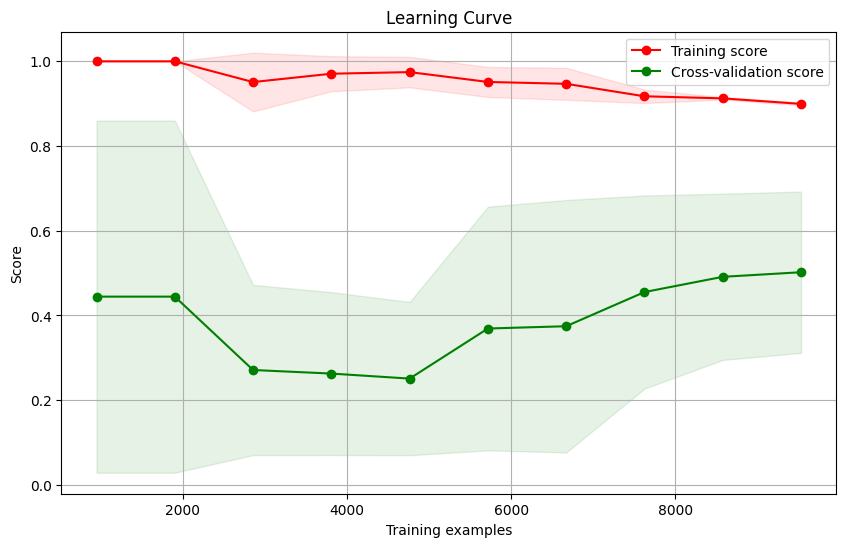

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(clf, X_train_array, y_train_undersampled, scoring, train_sizes)

In [ ]:
##data import stratified undersampling
X_train_undersampled = pd.read_csv('X_train_undersampled_str.csv')

y_train_undersampled = pd.read_csv('y_train_undersampled_str.csv')

y_train_undersampled = np.ravel(y_train_undersampled.values)
X_train_array = X_train_undersampled.values

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [ ]:
%%writefile custom_metrics.py

from sklearn.metrics import f1_score
from pytorch_tabnet.metrics import Metric

class F1Macro(Metric):
    def __init__(self):
        self._name = "f1_macro"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = (y_score[:, 1] > 0.5).astype(int)  # binary classification
        f1_macro = f1_score(y_true, y_pred, average='macro')
        return f1_macro


Overwriting custom_metrics.py


In [ ]:
##unsupervised pre-training

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from custom_metrics import F1Macro  # Import the F1Macro class from custom_metrics.py


# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.8,  # Ratio of training data used for pre-training
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  # This will be overwritten if using pretrain model
)

# Fit the model to your labeled training data
clf.fit(
    X_train=X_train_array,
    y_train=y_train_undersampled,
    eval_set=[(X_train_array, y_train_undersampled), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    from_unsupervised=unsupervised_model
)

# Save the trained model to a file
#joblib.dump(clf, 'tabnet_random_undersampling_pretrained.pkl')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 53.37158| val_0_unsup_loss_numpy: 17.265869140625|  0:00:05s
epoch 1  | loss: 7.17182 | val_0_unsup_loss_numpy: 7.363110065460205|  0:00:10s
epoch 2  | loss: 2.04452 | val_0_unsup_loss_numpy: 6.644199848175049|  0:00:16s
epoch 3  | loss: 1.13504 | val_0_unsup_loss_numpy: 2.014090061187744|  0:00:21s
epoch 4  | loss: 1.0558  | val_0_unsup_loss_numpy: 2.9469499588012695|  0:00:26s
epoch 5  | loss: 1.10475 | val_0_unsup_loss_numpy: 2.7813799381256104|  0:00:32s
epoch 6  | loss: 1.07001 | val_0_unsup_loss_numpy: 1.8904099464416504|  0:00:37s
epoch 7  | loss: 1.01924 | val_0_unsup_loss_numpy: 1.4742000102996826|  0:00:43s
epoch 8  | loss: 0.99625 | val_0_unsup_loss_numpy: 1.4532999992370605|  0:00:48s
epoch 9  | loss: 0.98088 | val_0_unsup_loss_numpy: 2.213789939880371|  0:00:54s
epoch 10 | loss: 1.03837 | val_0_unsup_loss_numpy: 1.5591000318527222|  0:00:59s
epoch 11 | loss: 0.98324 | val_0_unsup_loss_numpy: 3.2069599628448486|  0:01:05s
epoch 12 | loss: 1.00747 | val_0_un

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.79882 | train_f1_macro: 0.62859 | valid_f1_macro: 0.30742 |  0:00:04s
epoch 1  | loss: 0.57136 | train_f1_macro: 0.62012 | valid_f1_macro: 0.26784 |  0:00:08s
epoch 2  | loss: 0.52272 | train_f1_macro: 0.6876  | valid_f1_macro: 0.32579 |  0:00:13s
epoch 3  | loss: 0.49743 | train_f1_macro: 0.73626 | valid_f1_macro: 0.3643  |  0:00:17s
epoch 4  | loss: 0.47893 | train_f1_macro: 0.74781 | valid_f1_macro: 0.35668 |  0:00:21s
epoch 5  | loss: 0.46636 | train_f1_macro: 0.76261 | valid_f1_macro: 0.36803 |  0:00:26s
epoch 6  | loss: 0.46039 | train_f1_macro: 0.77275 | valid_f1_macro: 0.37714 |  0:00:30s
epoch 7  | loss: 0.45124 | train_f1_macro: 0.7881  | valid_f1_macro: 0.39716 |  0:00:35s
epoch 8  | loss: 0.44678 | train_f1_macro: 0.78557 | valid_f1_macro: 0.39494 |  0:00:39s
epoch 9  | loss: 0.44183 | train_f1_macro: 0.79236 | valid_f1_macro: 0.39087 |  0:00:44s
epoch 10 | loss: 0.43582 | train_f1_macro: 0.79947 | valid_f1_macro: 0.40235 |  0:00:48s
epoch 11 | loss: 0.42

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


PicklingError: ignored

In [ ]:
import dill

# Save the trained model to a file using dill
with open('tabnet_random_undersampling_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)


In [ ]:
y_pred = clf.predict(X_valid_array)

In [ ]:
f1_macro = f1_score(y_valid, y_pred, average='macro')
print(f"Final Validation F1 Macro with Best Model: {f1_macro}")

Final Validation F1 Macro with Best Model: 0.435291695267247


In [ ]:
f1_weighted = f1_score(y_valid, y_pred, average='weighted')
print(f"Final Validation F1 Weighted with Best Model: {f1_weighted}")

Final Validation F1 Weighted with Best Model: 0.8071814016476331


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred, zero_division=1))

Confusion Matrix:
[[109075  49249]
 [   224   1452]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82    158324
           1       0.03      0.87      0.06      1676

    accuracy                           0.69    160000
   macro avg       0.51      0.78      0.44    160000
weighted avg       0.99      0.69      0.81    160000



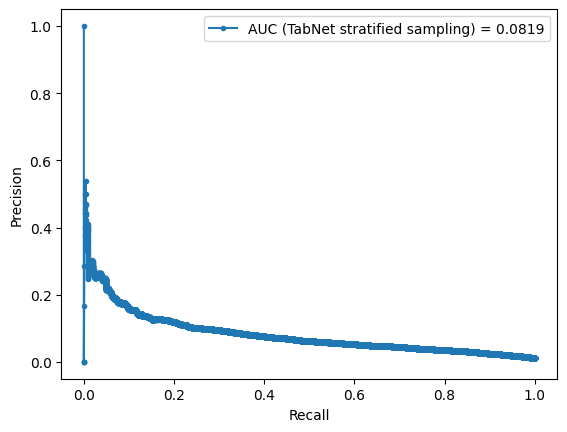

In [ ]:
# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_tab = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (TabNet stratified sampling) = {auc_tab:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
##custom scorer
from sklearn.metrics import recall_score

#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_valid_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Chosen threshold: 0.9999408721923828
False Positive Rate: 6.316161794800536e-06
Recall: 0.0
[[158323      1]
 [  1676      0]]


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97014 |  0:00:00s
epoch 1  | loss: 0.8303  |  0:00:00s
epoch 2  | loss: 0.73976 |  0:00:00s
epoch 3  | loss: 0.69808 |  0:00:00s
epoch 4  | loss: 0.70318 |  0:00:00s
epoch 5  | loss: 0.68528 |  0:00:00s
epoch 6  | loss: 0.69319 |  0:00:00s
epoch 7  | loss: 0.67576 |  0:00:00s
epoch 8  | loss: 0.66423 |  0:00:00s
epoch 9  | loss: 0.65419 |  0:00:00s
epoch 10 | loss: 0.62723 |  0:00:00s
epoch 11 | loss: 0.61042 |  0:00:00s
epoch 12 | loss: 0.60248 |  0:00:00s
epoch 13 | loss: 0.61715 |  0:00:00s
epoch 14 | loss: 0.60329 |  0:00:00s
epoch 15 | loss: 0.58126 |  0:00:00s
epoch 16 | loss: 0.58216 |  0:00:00s
epoch 17 | loss: 0.59132 |  0:00:00s
epoch 18 | loss: 0.55114 |  0:00:00s
epoch 19 | loss: 0.56565 |  0:00:00s
epoch 20 | loss: 0.60359 |  0:00:00s
epoch 21 | loss: 0.56429 |  0:00:00s
epoch 22 | loss: 0.54279 |  0:00:01s
epoch 23 | loss: 0.53916 |  0:00:01s
epoch 24 | loss: 0.55072 |  0:00:01s
epoch 25 | loss: 0.54231 |  0:00:01s
epoch 26 | loss: 0.53813 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.89051 |  0:00:00s
epoch 1  | loss: 0.74437 |  0:00:00s
epoch 2  | loss: 0.72468 |  0:00:00s
epoch 3  | loss: 0.68677 |  0:00:00s
epoch 4  | loss: 0.67317 |  0:00:00s
epoch 5  | loss: 0.63705 |  0:00:00s
epoch 6  | loss: 0.63134 |  0:00:00s
epoch 7  | loss: 0.61734 |  0:00:00s
epoch 8  | loss: 0.58594 |  0:00:00s
epoch 9  | loss: 0.58583 |  0:00:00s
epoch 10 | loss: 0.56963 |  0:00:00s
epoch 11 | loss: 0.54936 |  0:00:00s
epoch 12 | loss: 0.53431 |  0:00:01s
epoch 13 | loss: 0.51852 |  0:00:01s
epoch 14 | loss: 0.53817 |  0:00:01s
epoch 15 | loss: 0.50955 |  0:00:01s
epoch 16 | loss: 0.49326 |  0:00:01s
epoch 17 | loss: 0.49471 |  0:00:01s
epoch 18 | loss: 0.49486 |  0:00:01s
epoch 19 | loss: 0.47983 |  0:00:01s
epoch 20 | loss: 0.47801 |  0:00:01s
epoch 21 | loss: 0.47365 |  0:00:01s
epoch 22 | loss: 0.46226 |  0:00:01s
epoch 23 | loss: 0.45304 |  0:00:01s
epoch 24 | loss: 0.45529 |  0:00:02s
epoch 25 | loss: 0.44661 |  0:00:02s
epoch 26 | loss: 0.44153 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.84582 |  0:00:00s
epoch 1  | loss: 0.74708 |  0:00:00s
epoch 2  | loss: 0.68702 |  0:00:00s
epoch 3  | loss: 0.66171 |  0:00:00s
epoch 4  | loss: 0.63855 |  0:00:00s
epoch 5  | loss: 0.61543 |  0:00:00s
epoch 6  | loss: 0.59692 |  0:00:00s
epoch 7  | loss: 0.57174 |  0:00:00s
epoch 8  | loss: 0.56276 |  0:00:01s
epoch 9  | loss: 0.54558 |  0:00:01s
epoch 10 | loss: 0.53665 |  0:00:01s
epoch 11 | loss: 0.51691 |  0:00:01s
epoch 12 | loss: 0.50359 |  0:00:01s
epoch 13 | loss: 0.50669 |  0:00:01s
epoch 14 | loss: 0.49802 |  0:00:01s
epoch 15 | loss: 0.49333 |  0:00:01s
epoch 16 | loss: 0.49518 |  0:00:02s
epoch 17 | loss: 0.48492 |  0:00:02s
epoch 18 | loss: 0.47624 |  0:00:02s
epoch 19 | loss: 0.46003 |  0:00:02s
epoch 20 | loss: 0.4604  |  0:00:02s
epoch 21 | loss: 0.45402 |  0:00:02s
epoch 22 | loss: 0.45053 |  0:00:02s
epoch 23 | loss: 0.44418 |  0:00:02s
epoch 24 | loss: 0.44392 |  0:00:03s
epoch 25 | loss: 0.43803 |  0:00:03s
epoch 26 | loss: 0.43766 |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82512 |  0:00:00s
epoch 1  | loss: 0.70412 |  0:00:00s
epoch 2  | loss: 0.64531 |  0:00:00s
epoch 3  | loss: 0.6255  |  0:00:00s
epoch 4  | loss: 0.5905  |  0:00:00s
epoch 5  | loss: 0.56898 |  0:00:00s
epoch 6  | loss: 0.54637 |  0:00:01s
epoch 7  | loss: 0.52756 |  0:00:01s
epoch 8  | loss: 0.52969 |  0:00:01s
epoch 9  | loss: 0.50647 |  0:00:01s
epoch 10 | loss: 0.49421 |  0:00:01s
epoch 11 | loss: 0.49236 |  0:00:01s
epoch 12 | loss: 0.48074 |  0:00:02s
epoch 13 | loss: 0.47942 |  0:00:02s
epoch 14 | loss: 0.47139 |  0:00:02s
epoch 15 | loss: 0.45997 |  0:00:02s
epoch 16 | loss: 0.45412 |  0:00:02s
epoch 17 | loss: 0.45361 |  0:00:02s
epoch 18 | loss: 0.45928 |  0:00:03s
epoch 19 | loss: 0.43882 |  0:00:03s
epoch 20 | loss: 0.44046 |  0:00:03s
epoch 21 | loss: 0.43718 |  0:00:03s
epoch 22 | loss: 0.42966 |  0:00:03s
epoch 23 | loss: 0.42942 |  0:00:03s
epoch 24 | loss: 0.41791 |  0:00:04s
epoch 25 | loss: 0.42018 |  0:00:04s
epoch 26 | loss: 0.41254 |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80342 |  0:00:00s
epoch 1  | loss: 0.70614 |  0:00:00s
epoch 2  | loss: 0.66687 |  0:00:00s
epoch 3  | loss: 0.62481 |  0:00:00s
epoch 4  | loss: 0.60227 |  0:00:01s
epoch 5  | loss: 0.57421 |  0:00:01s
epoch 6  | loss: 0.55276 |  0:00:01s
epoch 7  | loss: 0.53324 |  0:00:01s
epoch 8  | loss: 0.52309 |  0:00:01s
epoch 9  | loss: 0.50665 |  0:00:02s
epoch 10 | loss: 0.49528 |  0:00:02s
epoch 11 | loss: 0.48335 |  0:00:02s
epoch 12 | loss: 0.48053 |  0:00:02s
epoch 13 | loss: 0.47321 |  0:00:02s
epoch 14 | loss: 0.46973 |  0:00:03s
epoch 15 | loss: 0.46499 |  0:00:03s
epoch 16 | loss: 0.45496 |  0:00:03s
epoch 17 | loss: 0.44858 |  0:00:03s
epoch 18 | loss: 0.44322 |  0:00:03s
epoch 19 | loss: 0.43705 |  0:00:04s
epoch 20 | loss: 0.43591 |  0:00:04s
epoch 21 | loss: 0.431   |  0:00:04s
epoch 22 | loss: 0.42784 |  0:00:04s
epoch 23 | loss: 0.41795 |  0:00:04s
epoch 24 | loss: 0.41047 |  0:00:05s
epoch 25 | loss: 0.41735 |  0:00:05s
epoch 26 | loss: 0.41134 |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.79056 |  0:00:00s
epoch 1  | loss: 0.66483 |  0:00:00s
epoch 2  | loss: 0.60681 |  0:00:00s
epoch 3  | loss: 0.55635 |  0:00:00s
epoch 4  | loss: 0.51952 |  0:00:01s
epoch 5  | loss: 0.50244 |  0:00:01s
epoch 6  | loss: 0.4987  |  0:00:01s
epoch 7  | loss: 0.48855 |  0:00:01s
epoch 8  | loss: 0.47754 |  0:00:02s
epoch 9  | loss: 0.47203 |  0:00:02s
epoch 10 | loss: 0.46377 |  0:00:02s
epoch 11 | loss: 0.44867 |  0:00:02s
epoch 12 | loss: 0.44542 |  0:00:03s
epoch 13 | loss: 0.43813 |  0:00:03s
epoch 14 | loss: 0.43437 |  0:00:03s
epoch 15 | loss: 0.43095 |  0:00:03s
epoch 16 | loss: 0.42671 |  0:00:04s
epoch 17 | loss: 0.42039 |  0:00:04s
epoch 18 | loss: 0.41978 |  0:00:04s
epoch 19 | loss: 0.4196  |  0:00:04s
epoch 20 | loss: 0.41564 |  0:00:05s
epoch 21 | loss: 0.40806 |  0:00:05s
epoch 22 | loss: 0.41009 |  0:00:05s
epoch 23 | loss: 0.40695 |  0:00:05s
epoch 24 | loss: 0.40576 |  0:00:06s
epoch 25 | loss: 0.39518 |  0:00:06s
epoch 26 | loss: 0.38951 |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.78047 |  0:00:00s
epoch 1  | loss: 0.66582 |  0:00:00s
epoch 2  | loss: 0.59728 |  0:00:00s
epoch 3  | loss: 0.55579 |  0:00:01s
epoch 4  | loss: 0.5379  |  0:00:01s
epoch 5  | loss: 0.52708 |  0:00:01s
epoch 6  | loss: 0.50192 |  0:00:01s
epoch 7  | loss: 0.50043 |  0:00:02s
epoch 8  | loss: 0.48507 |  0:00:02s
epoch 9  | loss: 0.4738  |  0:00:02s
epoch 10 | loss: 0.46616 |  0:00:03s
epoch 11 | loss: 0.45915 |  0:00:03s
epoch 12 | loss: 0.45306 |  0:00:03s
epoch 13 | loss: 0.4434  |  0:00:03s
epoch 14 | loss: 0.43585 |  0:00:04s
epoch 15 | loss: 0.4366  |  0:00:04s
epoch 16 | loss: 0.43391 |  0:00:04s
epoch 17 | loss: 0.42433 |  0:00:05s
epoch 18 | loss: 0.42283 |  0:00:05s
epoch 19 | loss: 0.42089 |  0:00:05s
epoch 20 | loss: 0.4194  |  0:00:06s
epoch 21 | loss: 0.4179  |  0:00:06s
epoch 22 | loss: 0.41364 |  0:00:06s
epoch 23 | loss: 0.41045 |  0:00:07s
epoch 24 | loss: 0.40466 |  0:00:07s
epoch 25 | loss: 0.39915 |  0:00:07s
epoch 26 | loss: 0.40019 |  0:00:07s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.77787 |  0:00:00s
epoch 1  | loss: 0.62604 |  0:00:00s
epoch 2  | loss: 0.56713 |  0:00:00s
epoch 3  | loss: 0.54125 |  0:00:01s
epoch 4  | loss: 0.52204 |  0:00:01s
epoch 5  | loss: 0.50361 |  0:00:01s
epoch 6  | loss: 0.48663 |  0:00:02s
epoch 7  | loss: 0.47656 |  0:00:02s
epoch 8  | loss: 0.47202 |  0:00:02s
epoch 9  | loss: 0.46516 |  0:00:03s
epoch 10 | loss: 0.45583 |  0:00:03s
epoch 11 | loss: 0.44951 |  0:00:03s
epoch 12 | loss: 0.44043 |  0:00:04s
epoch 13 | loss: 0.43948 |  0:00:04s
epoch 14 | loss: 0.4328  |  0:00:04s
epoch 15 | loss: 0.43259 |  0:00:05s
epoch 16 | loss: 0.42573 |  0:00:05s
epoch 17 | loss: 0.41688 |  0:00:05s
epoch 18 | loss: 0.42231 |  0:00:06s
epoch 19 | loss: 0.41817 |  0:00:06s
epoch 20 | loss: 0.41428 |  0:00:06s
epoch 21 | loss: 0.41093 |  0:00:07s
epoch 22 | loss: 0.40517 |  0:00:07s
epoch 23 | loss: 0.40207 |  0:00:07s
epoch 24 | loss: 0.40696 |  0:00:08s
epoch 25 | loss: 0.39751 |  0:00:08s
epoch 26 | loss: 0.39766 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.75378 |  0:00:00s
epoch 1  | loss: 0.64732 |  0:00:00s
epoch 2  | loss: 0.59128 |  0:00:01s
epoch 3  | loss: 0.55872 |  0:00:01s
epoch 4  | loss: 0.52986 |  0:00:01s
epoch 5  | loss: 0.51502 |  0:00:02s
epoch 6  | loss: 0.49515 |  0:00:02s
epoch 7  | loss: 0.48291 |  0:00:02s
epoch 8  | loss: 0.47371 |  0:00:03s
epoch 9  | loss: 0.46239 |  0:00:03s
epoch 10 | loss: 0.45263 |  0:00:04s
epoch 11 | loss: 0.44609 |  0:00:04s
epoch 12 | loss: 0.44229 |  0:00:04s
epoch 13 | loss: 0.43833 |  0:00:05s
epoch 14 | loss: 0.44045 |  0:00:05s
epoch 15 | loss: 0.43399 |  0:00:05s
epoch 16 | loss: 0.43012 |  0:00:06s
epoch 17 | loss: 0.43049 |  0:00:06s
epoch 18 | loss: 0.4258  |  0:00:06s
epoch 19 | loss: 0.4342  |  0:00:07s
epoch 20 | loss: 0.43107 |  0:00:07s
epoch 21 | loss: 0.42257 |  0:00:07s
epoch 22 | loss: 0.42106 |  0:00:08s
epoch 23 | loss: 0.42227 |  0:00:08s
epoch 24 | loss: 0.40953 |  0:00:08s
epoch 25 | loss: 0.40889 |  0:00:09s
epoch 26 | loss: 0.40852 |  0:00:09s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99676 |  0:00:00s
epoch 1  | loss: 0.82741 |  0:00:00s
epoch 2  | loss: 0.74898 |  0:00:00s
epoch 3  | loss: 0.7235  |  0:00:00s
epoch 4  | loss: 0.71412 |  0:00:00s
epoch 5  | loss: 0.71541 |  0:00:00s
epoch 6  | loss: 0.71256 |  0:00:00s
epoch 7  | loss: 0.73672 |  0:00:00s
epoch 8  | loss: 0.68699 |  0:00:00s
epoch 9  | loss: 0.66505 |  0:00:00s
epoch 10 | loss: 0.65945 |  0:00:00s
epoch 11 | loss: 0.63862 |  0:00:00s
epoch 12 | loss: 0.643   |  0:00:00s
epoch 13 | loss: 0.63579 |  0:00:00s
epoch 14 | loss: 0.65769 |  0:00:00s
epoch 15 | loss: 0.63745 |  0:00:00s
epoch 16 | loss: 0.60648 |  0:00:00s
epoch 17 | loss: 0.61393 |  0:00:00s
epoch 18 | loss: 0.59233 |  0:00:00s
epoch 19 | loss: 0.58005 |  0:00:00s
epoch 20 | loss: 0.58088 |  0:00:00s
epoch 21 | loss: 0.55562 |  0:00:00s
epoch 22 | loss: 0.56357 |  0:00:00s
epoch 23 | loss: 0.56886 |  0:00:01s
epoch 24 | loss: 0.55368 |  0:00:01s
epoch 25 | loss: 0.54175 |  0:00:01s
epoch 26 | loss: 0.51372 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90739 |  0:00:00s
epoch 1  | loss: 0.76175 |  0:00:00s
epoch 2  | loss: 0.73341 |  0:00:00s
epoch 3  | loss: 0.70911 |  0:00:00s
epoch 4  | loss: 0.68171 |  0:00:00s
epoch 5  | loss: 0.65017 |  0:00:00s
epoch 6  | loss: 0.64582 |  0:00:00s
epoch 7  | loss: 0.63072 |  0:00:00s
epoch 8  | loss: 0.61328 |  0:00:00s
epoch 9  | loss: 0.59498 |  0:00:00s
epoch 10 | loss: 0.57161 |  0:00:00s
epoch 11 | loss: 0.58191 |  0:00:00s
epoch 12 | loss: 0.55296 |  0:00:01s
epoch 13 | loss: 0.5523  |  0:00:01s
epoch 14 | loss: 0.54134 |  0:00:01s
epoch 15 | loss: 0.52989 |  0:00:01s
epoch 16 | loss: 0.51787 |  0:00:01s
epoch 17 | loss: 0.53521 |  0:00:01s
epoch 18 | loss: 0.50492 |  0:00:01s
epoch 19 | loss: 0.49471 |  0:00:01s
epoch 20 | loss: 0.49162 |  0:00:01s
epoch 21 | loss: 0.49554 |  0:00:01s
epoch 22 | loss: 0.47646 |  0:00:01s
epoch 23 | loss: 0.48019 |  0:00:02s
epoch 24 | loss: 0.47228 |  0:00:02s
epoch 25 | loss: 0.45919 |  0:00:02s
epoch 26 | loss: 0.46349 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.84933 |  0:00:00s
epoch 1  | loss: 0.71744 |  0:00:00s
epoch 2  | loss: 0.67646 |  0:00:00s
epoch 3  | loss: 0.63901 |  0:00:00s
epoch 4  | loss: 0.62612 |  0:00:00s
epoch 5  | loss: 0.59846 |  0:00:00s
epoch 6  | loss: 0.57846 |  0:00:00s
epoch 7  | loss: 0.55905 |  0:00:01s
epoch 8  | loss: 0.53831 |  0:00:01s
epoch 9  | loss: 0.53046 |  0:00:01s
epoch 10 | loss: 0.52356 |  0:00:01s
epoch 11 | loss: 0.51456 |  0:00:01s
epoch 12 | loss: 0.50553 |  0:00:01s
epoch 13 | loss: 0.50809 |  0:00:01s
epoch 14 | loss: 0.50262 |  0:00:01s
epoch 15 | loss: 0.49559 |  0:00:02s
epoch 16 | loss: 0.48543 |  0:00:02s
epoch 17 | loss: 0.47621 |  0:00:02s
epoch 18 | loss: 0.47206 |  0:00:02s
epoch 19 | loss: 0.47829 |  0:00:02s
epoch 20 | loss: 0.47258 |  0:00:02s
epoch 21 | loss: 0.46117 |  0:00:02s
epoch 22 | loss: 0.46407 |  0:00:03s
epoch 23 | loss: 0.45599 |  0:00:03s
epoch 24 | loss: 0.46042 |  0:00:03s
epoch 25 | loss: 0.44935 |  0:00:03s
epoch 26 | loss: 0.46065 |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80867 |  0:00:00s
epoch 1  | loss: 0.71068 |  0:00:00s
epoch 2  | loss: 0.65844 |  0:00:00s
epoch 3  | loss: 0.62989 |  0:00:00s
epoch 4  | loss: 0.60642 |  0:00:00s
epoch 5  | loss: 0.57745 |  0:00:00s
epoch 6  | loss: 0.55712 |  0:00:01s
epoch 7  | loss: 0.53975 |  0:00:01s
epoch 8  | loss: 0.53239 |  0:00:01s
epoch 9  | loss: 0.52209 |  0:00:01s
epoch 10 | loss: 0.50665 |  0:00:01s
epoch 11 | loss: 0.50431 |  0:00:01s
epoch 12 | loss: 0.49666 |  0:00:02s
epoch 13 | loss: 0.47882 |  0:00:02s
epoch 14 | loss: 0.48936 |  0:00:02s
epoch 15 | loss: 0.47107 |  0:00:02s
epoch 16 | loss: 0.46967 |  0:00:02s
epoch 17 | loss: 0.47511 |  0:00:02s
epoch 18 | loss: 0.46742 |  0:00:03s
epoch 19 | loss: 0.46318 |  0:00:03s
epoch 20 | loss: 0.45137 |  0:00:03s
epoch 21 | loss: 0.44227 |  0:00:03s
epoch 22 | loss: 0.44458 |  0:00:03s
epoch 23 | loss: 0.44816 |  0:00:03s
epoch 24 | loss: 0.43663 |  0:00:04s
epoch 25 | loss: 0.42709 |  0:00:04s
epoch 26 | loss: 0.42904 |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80082 |  0:00:00s
epoch 1  | loss: 0.70473 |  0:00:00s
epoch 2  | loss: 0.6463  |  0:00:00s
epoch 3  | loss: 0.60561 |  0:00:00s
epoch 4  | loss: 0.57459 |  0:00:00s
epoch 5  | loss: 0.54841 |  0:00:01s
epoch 6  | loss: 0.53634 |  0:00:01s
epoch 7  | loss: 0.52535 |  0:00:01s
epoch 8  | loss: 0.50719 |  0:00:01s
epoch 9  | loss: 0.50084 |  0:00:01s
epoch 10 | loss: 0.4867  |  0:00:02s
epoch 11 | loss: 0.48587 |  0:00:02s
epoch 12 | loss: 0.47807 |  0:00:02s
epoch 13 | loss: 0.47396 |  0:00:02s
epoch 14 | loss: 0.46059 |  0:00:03s
epoch 15 | loss: 0.46458 |  0:00:03s
epoch 16 | loss: 0.45764 |  0:00:03s
epoch 17 | loss: 0.45481 |  0:00:03s
epoch 18 | loss: 0.45551 |  0:00:03s
epoch 19 | loss: 0.45031 |  0:00:04s
epoch 20 | loss: 0.43891 |  0:00:04s
epoch 21 | loss: 0.42908 |  0:00:04s
epoch 22 | loss: 0.42909 |  0:00:04s
epoch 23 | loss: 0.43074 |  0:00:04s
epoch 24 | loss: 0.42912 |  0:00:05s
epoch 25 | loss: 0.4235  |  0:00:05s
epoch 26 | loss: 0.41628 |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.78701 |  0:00:00s
epoch 1  | loss: 0.68083 |  0:00:00s
epoch 2  | loss: 0.62273 |  0:00:00s
epoch 3  | loss: 0.58806 |  0:00:00s
epoch 4  | loss: 0.56195 |  0:00:01s
epoch 5  | loss: 0.53754 |  0:00:01s
epoch 6  | loss: 0.52933 |  0:00:01s
epoch 7  | loss: 0.51452 |  0:00:01s
epoch 8  | loss: 0.50528 |  0:00:02s
epoch 9  | loss: 0.49268 |  0:00:02s
epoch 10 | loss: 0.48812 |  0:00:02s
epoch 11 | loss: 0.47626 |  0:00:02s
epoch 12 | loss: 0.47249 |  0:00:03s
epoch 13 | loss: 0.46637 |  0:00:03s
epoch 14 | loss: 0.46188 |  0:00:03s
epoch 15 | loss: 0.45902 |  0:00:03s
epoch 16 | loss: 0.45164 |  0:00:04s
epoch 17 | loss: 0.45769 |  0:00:04s
epoch 18 | loss: 0.45072 |  0:00:04s
epoch 19 | loss: 0.4438  |  0:00:04s
epoch 20 | loss: 0.44347 |  0:00:05s
epoch 21 | loss: 0.43735 |  0:00:05s
epoch 22 | loss: 0.43025 |  0:00:05s
epoch 23 | loss: 0.42652 |  0:00:05s
epoch 24 | loss: 0.43085 |  0:00:05s
epoch 25 | loss: 0.42777 |  0:00:06s
epoch 26 | loss: 0.4274  |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.78726 |  0:00:00s
epoch 1  | loss: 0.67432 |  0:00:00s
epoch 2  | loss: 0.62192 |  0:00:00s
epoch 3  | loss: 0.5856  |  0:00:01s
epoch 4  | loss: 0.55083 |  0:00:01s
epoch 5  | loss: 0.53777 |  0:00:01s
epoch 6  | loss: 0.52326 |  0:00:02s
epoch 7  | loss: 0.51253 |  0:00:02s
epoch 8  | loss: 0.49925 |  0:00:02s
epoch 9  | loss: 0.49397 |  0:00:03s
epoch 10 | loss: 0.48192 |  0:00:03s
epoch 11 | loss: 0.47215 |  0:00:03s
epoch 12 | loss: 0.46771 |  0:00:03s
epoch 13 | loss: 0.4624  |  0:00:04s
epoch 14 | loss: 0.45751 |  0:00:04s
epoch 15 | loss: 0.46329 |  0:00:04s
epoch 16 | loss: 0.45219 |  0:00:04s
epoch 17 | loss: 0.44448 |  0:00:05s
epoch 18 | loss: 0.43674 |  0:00:05s
epoch 19 | loss: 0.43226 |  0:00:05s
epoch 20 | loss: 0.43108 |  0:00:06s
epoch 21 | loss: 0.43712 |  0:00:06s
epoch 22 | loss: 0.4312  |  0:00:06s
epoch 23 | loss: 0.43152 |  0:00:06s
epoch 24 | loss: 0.41937 |  0:00:07s
epoch 25 | loss: 0.41566 |  0:00:07s
epoch 26 | loss: 0.41762 |  0:00:07s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.75219 |  0:00:00s
epoch 1  | loss: 0.6351  |  0:00:00s
epoch 2  | loss: 0.58134 |  0:00:00s
epoch 3  | loss: 0.55084 |  0:00:01s
epoch 4  | loss: 0.52962 |  0:00:01s
epoch 5  | loss: 0.51798 |  0:00:01s
epoch 6  | loss: 0.50434 |  0:00:02s
epoch 7  | loss: 0.49575 |  0:00:02s
epoch 8  | loss: 0.49082 |  0:00:02s
epoch 9  | loss: 0.47988 |  0:00:03s
epoch 10 | loss: 0.4713  |  0:00:03s
epoch 11 | loss: 0.46434 |  0:00:03s
epoch 12 | loss: 0.45974 |  0:00:04s
epoch 13 | loss: 0.4558  |  0:00:04s
epoch 14 | loss: 0.44956 |  0:00:04s
epoch 15 | loss: 0.4453  |  0:00:05s
epoch 16 | loss: 0.44414 |  0:00:05s
epoch 17 | loss: 0.4412  |  0:00:05s
epoch 18 | loss: 0.43299 |  0:00:06s
epoch 19 | loss: 0.43292 |  0:00:06s
epoch 20 | loss: 0.42668 |  0:00:06s
epoch 21 | loss: 0.42226 |  0:00:06s
epoch 22 | loss: 0.42023 |  0:00:07s
epoch 23 | loss: 0.41593 |  0:00:07s
epoch 24 | loss: 0.41626 |  0:00:07s
epoch 25 | loss: 0.41124 |  0:00:08s
epoch 26 | loss: 0.41197 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76874 |  0:00:00s
epoch 1  | loss: 0.62895 |  0:00:00s
epoch 2  | loss: 0.57606 |  0:00:01s
epoch 3  | loss: 0.543   |  0:00:01s
epoch 4  | loss: 0.5222  |  0:00:01s
epoch 5  | loss: 0.50554 |  0:00:02s
epoch 6  | loss: 0.49551 |  0:00:02s
epoch 7  | loss: 0.48276 |  0:00:02s
epoch 8  | loss: 0.47339 |  0:00:03s
epoch 9  | loss: 0.46219 |  0:00:03s
epoch 10 | loss: 0.46036 |  0:00:04s
epoch 11 | loss: 0.45338 |  0:00:04s
epoch 12 | loss: 0.44544 |  0:00:04s
epoch 13 | loss: 0.44204 |  0:00:05s
epoch 14 | loss: 0.44021 |  0:00:05s
epoch 15 | loss: 0.43514 |  0:00:05s
epoch 16 | loss: 0.43028 |  0:00:06s
epoch 17 | loss: 0.42858 |  0:00:06s
epoch 18 | loss: 0.42425 |  0:00:07s
epoch 19 | loss: 0.42464 |  0:00:07s
epoch 20 | loss: 0.4191  |  0:00:07s
epoch 21 | loss: 0.42044 |  0:00:08s
epoch 22 | loss: 0.41801 |  0:00:08s
epoch 23 | loss: 0.41144 |  0:00:08s
epoch 24 | loss: 0.41002 |  0:00:09s
epoch 25 | loss: 0.40361 |  0:00:09s
epoch 26 | loss: 0.40314 |  0:00:10s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99676 |  0:00:00s
epoch 1  | loss: 0.82741 |  0:00:00s
epoch 2  | loss: 0.74898 |  0:00:00s
epoch 3  | loss: 0.7235  |  0:00:00s
epoch 4  | loss: 0.71412 |  0:00:00s
epoch 5  | loss: 0.71541 |  0:00:00s
epoch 6  | loss: 0.71256 |  0:00:00s
epoch 7  | loss: 0.73672 |  0:00:00s
epoch 8  | loss: 0.68699 |  0:00:00s
epoch 9  | loss: 0.66505 |  0:00:00s
epoch 10 | loss: 0.65945 |  0:00:00s
epoch 11 | loss: 0.63862 |  0:00:00s
epoch 12 | loss: 0.643   |  0:00:00s
epoch 13 | loss: 0.63579 |  0:00:00s
epoch 14 | loss: 0.65769 |  0:00:00s
epoch 15 | loss: 0.63745 |  0:00:00s
epoch 16 | loss: 0.60648 |  0:00:00s
epoch 17 | loss: 0.61393 |  0:00:00s
epoch 18 | loss: 0.59233 |  0:00:00s
epoch 19 | loss: 0.58005 |  0:00:00s
epoch 20 | loss: 0.58088 |  0:00:00s
epoch 21 | loss: 0.55562 |  0:00:00s
epoch 22 | loss: 0.56357 |  0:00:00s
epoch 23 | loss: 0.56886 |  0:00:01s
epoch 24 | loss: 0.55368 |  0:00:01s
epoch 25 | loss: 0.54175 |  0:00:01s
epoch 26 | loss: 0.51372 |  0:00:01s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90739 |  0:00:00s
epoch 1  | loss: 0.76175 |  0:00:00s
epoch 2  | loss: 0.73341 |  0:00:00s
epoch 3  | loss: 0.70911 |  0:00:00s
epoch 4  | loss: 0.68171 |  0:00:00s
epoch 5  | loss: 0.65017 |  0:00:00s
epoch 6  | loss: 0.64582 |  0:00:00s
epoch 7  | loss: 0.63072 |  0:00:00s
epoch 8  | loss: 0.61328 |  0:00:00s
epoch 9  | loss: 0.59498 |  0:00:00s
epoch 10 | loss: 0.57161 |  0:00:00s
epoch 11 | loss: 0.58191 |  0:00:00s
epoch 12 | loss: 0.55296 |  0:00:01s
epoch 13 | loss: 0.5523  |  0:00:01s
epoch 14 | loss: 0.54134 |  0:00:01s
epoch 15 | loss: 0.52989 |  0:00:01s
epoch 16 | loss: 0.51787 |  0:00:01s
epoch 17 | loss: 0.53521 |  0:00:01s
epoch 18 | loss: 0.50492 |  0:00:01s
epoch 19 | loss: 0.49471 |  0:00:01s
epoch 20 | loss: 0.49162 |  0:00:01s
epoch 21 | loss: 0.49554 |  0:00:01s
epoch 22 | loss: 0.47646 |  0:00:01s
epoch 23 | loss: 0.48019 |  0:00:01s
epoch 24 | loss: 0.47228 |  0:00:02s
epoch 25 | loss: 0.45919 |  0:00:02s
epoch 26 | loss: 0.46349 |  0:00:02s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.84933 |  0:00:00s
epoch 1  | loss: 0.71744 |  0:00:00s
epoch 2  | loss: 0.67646 |  0:00:00s
epoch 3  | loss: 0.63901 |  0:00:00s
epoch 4  | loss: 0.62612 |  0:00:00s
epoch 5  | loss: 0.59846 |  0:00:00s
epoch 6  | loss: 0.57846 |  0:00:00s
epoch 7  | loss: 0.55905 |  0:00:00s
epoch 8  | loss: 0.53831 |  0:00:01s
epoch 9  | loss: 0.53046 |  0:00:01s
epoch 10 | loss: 0.52356 |  0:00:01s
epoch 11 | loss: 0.51456 |  0:00:01s
epoch 12 | loss: 0.50553 |  0:00:01s
epoch 13 | loss: 0.50809 |  0:00:01s
epoch 14 | loss: 0.50262 |  0:00:02s
epoch 15 | loss: 0.49559 |  0:00:02s
epoch 16 | loss: 0.48543 |  0:00:02s
epoch 17 | loss: 0.47621 |  0:00:02s
epoch 18 | loss: 0.47206 |  0:00:02s
epoch 19 | loss: 0.47829 |  0:00:02s
epoch 20 | loss: 0.47258 |  0:00:02s
epoch 21 | loss: 0.46117 |  0:00:02s
epoch 22 | loss: 0.46407 |  0:00:02s
epoch 23 | loss: 0.45599 |  0:00:03s
epoch 24 | loss: 0.46042 |  0:00:03s
epoch 25 | loss: 0.44935 |  0:00:03s
epoch 26 | loss: 0.46065 |  0:00:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80867 |  0:00:00s
epoch 1  | loss: 0.71068 |  0:00:00s
epoch 2  | loss: 0.65844 |  0:00:00s
epoch 3  | loss: 0.62989 |  0:00:00s
epoch 4  | loss: 0.60642 |  0:00:00s
epoch 5  | loss: 0.57745 |  0:00:00s
epoch 6  | loss: 0.55712 |  0:00:01s
epoch 7  | loss: 0.53975 |  0:00:01s
epoch 8  | loss: 0.53239 |  0:00:01s
epoch 9  | loss: 0.52209 |  0:00:01s
epoch 10 | loss: 0.50665 |  0:00:01s
epoch 11 | loss: 0.50431 |  0:00:01s
epoch 12 | loss: 0.49666 |  0:00:02s
epoch 13 | loss: 0.47882 |  0:00:02s
epoch 14 | loss: 0.48936 |  0:00:02s
epoch 15 | loss: 0.47107 |  0:00:02s
epoch 16 | loss: 0.46967 |  0:00:02s
epoch 17 | loss: 0.47511 |  0:00:02s
epoch 18 | loss: 0.46742 |  0:00:03s
epoch 19 | loss: 0.46318 |  0:00:03s
epoch 20 | loss: 0.45137 |  0:00:03s
epoch 21 | loss: 0.44227 |  0:00:03s
epoch 22 | loss: 0.44458 |  0:00:03s
epoch 23 | loss: 0.44816 |  0:00:03s
epoch 24 | loss: 0.43663 |  0:00:04s
epoch 25 | loss: 0.42709 |  0:00:04s
epoch 26 | loss: 0.42904 |  0:00:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.81556 |  0:00:00s
epoch 1  | loss: 0.68773 |  0:00:00s
epoch 2  | loss: 0.63871 |  0:00:00s
epoch 3  | loss: 0.60154 |  0:00:00s
epoch 4  | loss: 0.58001 |  0:00:00s
epoch 5  | loss: 0.54966 |  0:00:01s
epoch 6  | loss: 0.53024 |  0:00:01s
epoch 7  | loss: 0.51711 |  0:00:01s
epoch 8  | loss: 0.49925 |  0:00:01s
epoch 9  | loss: 0.50966 |  0:00:01s
epoch 10 | loss: 0.48761 |  0:00:02s
epoch 11 | loss: 0.4801  |  0:00:02s
epoch 12 | loss: 0.47326 |  0:00:02s
epoch 13 | loss: 0.46721 |  0:00:02s
epoch 14 | loss: 0.45814 |  0:00:02s
epoch 15 | loss: 0.45165 |  0:00:03s
epoch 16 | loss: 0.45517 |  0:00:03s
epoch 17 | loss: 0.44438 |  0:00:03s
epoch 18 | loss: 0.44181 |  0:00:03s
epoch 19 | loss: 0.43713 |  0:00:03s
epoch 20 | loss: 0.43471 |  0:00:04s
epoch 21 | loss: 0.42207 |  0:00:04s
epoch 22 | loss: 0.42796 |  0:00:04s
epoch 23 | loss: 0.41453 |  0:00:04s
epoch 24 | loss: 0.43158 |  0:00:04s
epoch 25 | loss: 0.42617 |  0:00:05s
epoch 26 | loss: 0.4188  |  0:00:05s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.79703 |  0:00:00s
epoch 1  | loss: 0.67016 |  0:00:00s
epoch 2  | loss: 0.61552 |  0:00:00s
epoch 3  | loss: 0.58196 |  0:00:00s
epoch 4  | loss: 0.56508 |  0:00:01s
epoch 5  | loss: 0.54224 |  0:00:01s
epoch 6  | loss: 0.52137 |  0:00:01s
epoch 7  | loss: 0.50782 |  0:00:01s
epoch 8  | loss: 0.49356 |  0:00:02s
epoch 9  | loss: 0.49242 |  0:00:02s
epoch 10 | loss: 0.48347 |  0:00:02s
epoch 11 | loss: 0.47491 |  0:00:02s
epoch 12 | loss: 0.47258 |  0:00:03s
epoch 13 | loss: 0.45889 |  0:00:03s
epoch 14 | loss: 0.45329 |  0:00:03s
epoch 15 | loss: 0.45274 |  0:00:03s
epoch 16 | loss: 0.44263 |  0:00:04s
epoch 17 | loss: 0.43865 |  0:00:04s
epoch 18 | loss: 0.43455 |  0:00:04s
epoch 19 | loss: 0.42711 |  0:00:04s
epoch 20 | loss: 0.42422 |  0:00:05s
epoch 21 | loss: 0.42562 |  0:00:05s
epoch 22 | loss: 0.41478 |  0:00:05s
epoch 23 | loss: 0.41177 |  0:00:05s
epoch 24 | loss: 0.41087 |  0:00:06s
epoch 25 | loss: 0.40416 |  0:00:06s
epoch 26 | loss: 0.40124 |  0:00:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.77086 |  0:00:00s
epoch 1  | loss: 0.65094 |  0:00:00s
epoch 2  | loss: 0.60073 |  0:00:01s
epoch 3  | loss: 0.56071 |  0:00:01s
epoch 4  | loss: 0.53191 |  0:00:01s
epoch 5  | loss: 0.51435 |  0:00:01s
epoch 6  | loss: 0.49812 |  0:00:02s
epoch 7  | loss: 0.49237 |  0:00:02s
epoch 8  | loss: 0.47925 |  0:00:02s
epoch 9  | loss: 0.47903 |  0:00:03s
epoch 10 | loss: 0.46482 |  0:00:03s
epoch 11 | loss: 0.45777 |  0:00:03s
epoch 12 | loss: 0.45716 |  0:00:03s
epoch 13 | loss: 0.45126 |  0:00:04s
epoch 14 | loss: 0.44838 |  0:00:04s
epoch 15 | loss: 0.45155 |  0:00:04s
epoch 16 | loss: 0.43795 |  0:00:05s
epoch 17 | loss: 0.4343  |  0:00:05s
epoch 18 | loss: 0.44027 |  0:00:05s
epoch 19 | loss: 0.43388 |  0:00:05s
epoch 20 | loss: 0.43066 |  0:00:06s
epoch 21 | loss: 0.43126 |  0:00:06s
epoch 22 | loss: 0.42287 |  0:00:06s
epoch 23 | loss: 0.42655 |  0:00:07s
epoch 24 | loss: 0.42449 |  0:00:07s
epoch 25 | loss: 0.41583 |  0:00:07s
epoch 26 | loss: 0.4193  |  0:00:07s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76813 |  0:00:00s
epoch 1  | loss: 0.65157 |  0:00:00s
epoch 2  | loss: 0.59446 |  0:00:00s
epoch 3  | loss: 0.56646 |  0:00:01s
epoch 4  | loss: 0.54076 |  0:00:01s
epoch 5  | loss: 0.51765 |  0:00:02s
epoch 6  | loss: 0.50615 |  0:00:02s
epoch 7  | loss: 0.49453 |  0:00:02s
epoch 8  | loss: 0.48294 |  0:00:03s
epoch 9  | loss: 0.47808 |  0:00:03s
epoch 10 | loss: 0.46695 |  0:00:03s
epoch 11 | loss: 0.46256 |  0:00:03s
epoch 12 | loss: 0.45726 |  0:00:04s
epoch 13 | loss: 0.4496  |  0:00:04s
epoch 14 | loss: 0.44824 |  0:00:04s
epoch 15 | loss: 0.44395 |  0:00:05s
epoch 16 | loss: 0.44408 |  0:00:05s
epoch 17 | loss: 0.4429  |  0:00:05s
epoch 18 | loss: 0.43241 |  0:00:06s
epoch 19 | loss: 0.4319  |  0:00:06s
epoch 20 | loss: 0.42889 |  0:00:06s
epoch 21 | loss: 0.42225 |  0:00:07s
epoch 22 | loss: 0.41791 |  0:00:07s
epoch 23 | loss: 0.41875 |  0:00:07s
epoch 24 | loss: 0.40796 |  0:00:08s
epoch 25 | loss: 0.41279 |  0:00:08s
epoch 26 | loss: 0.40746 |  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.74575 |  0:00:00s
epoch 1  | loss: 0.61722 |  0:00:00s
epoch 2  | loss: 0.57294 |  0:00:01s
epoch 3  | loss: 0.54291 |  0:00:01s
epoch 4  | loss: 0.52141 |  0:00:01s
epoch 5  | loss: 0.50352 |  0:00:02s
epoch 6  | loss: 0.48718 |  0:00:02s
epoch 7  | loss: 0.48493 |  0:00:02s
epoch 8  | loss: 0.478   |  0:00:03s
epoch 9  | loss: 0.47005 |  0:00:03s
epoch 10 | loss: 0.46385 |  0:00:03s
epoch 11 | loss: 0.45804 |  0:00:04s
epoch 12 | loss: 0.45173 |  0:00:04s
epoch 13 | loss: 0.4419  |  0:00:05s
epoch 14 | loss: 0.44029 |  0:00:05s
epoch 15 | loss: 0.43116 |  0:00:05s
epoch 16 | loss: 0.42608 |  0:00:06s
epoch 17 | loss: 0.42421 |  0:00:06s
epoch 18 | loss: 0.41941 |  0:00:06s
epoch 19 | loss: 0.42387 |  0:00:07s
epoch 20 | loss: 0.41401 |  0:00:07s
epoch 21 | loss: 0.41238 |  0:00:07s
epoch 22 | loss: 0.4085  |  0:00:08s
epoch 23 | loss: 0.40386 |  0:00:08s
epoch 24 | loss: 0.39874 |  0:00:08s
epoch 25 | loss: 0.39777 |  0:00:09s
epoch 26 | loss: 0.3944  |  0:00:09s
e

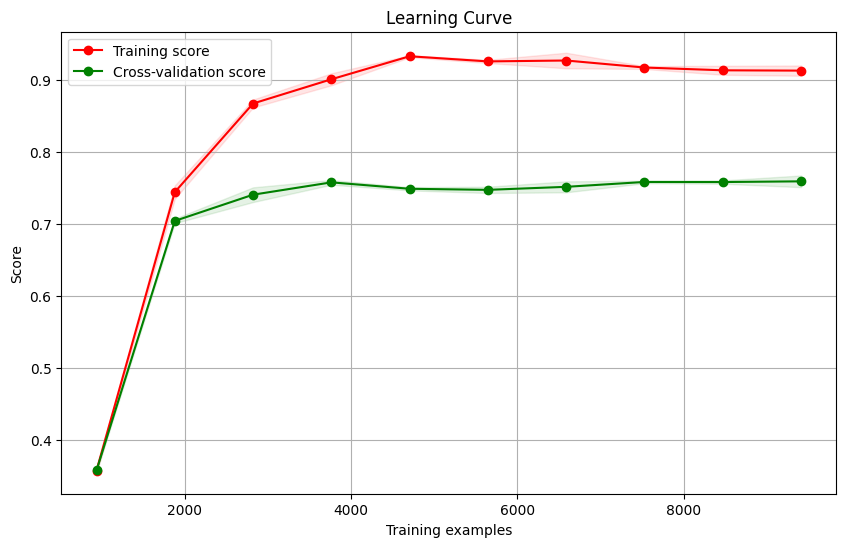

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
scoring = "f1_macro"
plot_learning_curve(clf, X_train_array, y_train_undersampled, scoring, train_sizes)

In [9]:
###TabNet with class weights - data without any resampling

X_train_resampled = pd.read_csv('X_train_transformed_basicfull.csv')
X_valid_transformed = pd.read_csv('X_valid_transformed_basicfull.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')

y_train_resampled = pd.read_csv('y_train_basicfull.csv')
y_valid = pd.read_csv('y_valid_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')
y_train_resampled = np.ravel(y_train_resampled.values)
y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)

In [ ]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [10]:
X_train_array = X_train_resampled.values
X_valid_array = X_valid_transformed.values
X_test_array = X_test_transformed.values

In [ ]:
from pytorch_tabnet.utils import (
    SparsePredictDataset,
    PredictDataset,
    create_explain_matrix,
    validate_eval_set,
    create_dataloaders,
    define_device,
    ComplexEncoder,
    check_input,
    check_warm_start,
    create_group_matrix,
    check_embedding_parameters
)
from pytorch_tabnet.callbacks import (
    CallbackContainer,
    History,
    EarlyStopping,
    LRSchedulerCallback,
)

In [11]:
##unsupervised pre-training
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from custom_metrics import F1Macro  # Import the F1Macro class from custom_metrics.py
from pytorch_tabnet.callbacks import EarlyStopping


# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.8,  # Ratio of training data used for pre-training
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  #will be overwritten if using pretrain model
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.63478 | val_0_unsup_loss_numpy: 0.9612600207328796|  0:00:36s
epoch 1  | loss: 0.88662 | val_0_unsup_loss_numpy: 0.9515699744224548|  0:01:11s
epoch 2  | loss: 0.84886 | val_0_unsup_loss_numpy: 0.8962399959564209|  0:01:47s
epoch 3  | loss: 0.81477 | val_0_unsup_loss_numpy: 0.901229977607727|  0:02:22s
epoch 4  | loss: 0.78945 | val_0_unsup_loss_numpy: 0.7946699857711792|  0:02:57s
epoch 5  | loss: 0.78928 | val_0_unsup_loss_numpy: 0.8873400092124939|  0:03:32s
epoch 6  | loss: 0.77906 | val_0_unsup_loss_numpy: 0.7993299961090088|  0:04:08s
epoch 7  | loss: 0.77578 | val_0_unsup_loss_numpy: 0.9611899852752686|  0:04:43s
epoch 8  | loss: 0.77569 | val_0_unsup_loss_numpy: 1.0362600088119507|  0:05:19s
epoch 9  | loss: 0.77437 | val_0_unsup_loss_numpy: 0.7782599925994873|  0:05:54s
epoch 10 | loss: 0.7697  | val_0_unsup_loss_numpy: 0.7886499762535095|  0:06:30s
epoch 11 | loss: 0.76646 | val_0_unsup_loss_numpy: 0.7274399995803833|  0:07:06s
epoch 12 | loss: 0.76035 | va

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [12]:
clf.fit(
    X_train=X_train_array,
    y_train=y_train_resampled,
    eval_set=[(X_train_array, y_train_resampled), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    weights=1,
    from_unsupervised=unsupervised_model
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.47328 | train_f1_macro: 0.49556 | valid_f1_macro: 0.48997 |  0:00:42s
epoch 1  | loss: 0.4139  | train_f1_macro: 0.49042 | valid_f1_macro: 0.48427 |  0:01:26s
epoch 2  | loss: 0.39229 | train_f1_macro: 0.48959 | valid_f1_macro: 0.48207 |  0:02:10s
epoch 3  | loss: 0.37311 | train_f1_macro: 0.48519 | valid_f1_macro: 0.47701 |  0:02:53s
epoch 4  | loss: 0.35837 | train_f1_macro: 0.49889 | valid_f1_macro: 0.48792 |  0:03:37s
epoch 5  | loss: 0.34661 | train_f1_macro: 0.49147 | valid_f1_macro: 0.48002 |  0:04:20s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_valid_f1_macro = 0.48997


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [13]:
y_pred = clf.predict(X_valid_array)

In [ ]:
import dill

# Save the trained model to a file using dill
with open('tabnet_class_weights_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)


In [14]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4900
F1 Score: 0.8905


In [ ]:
##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Confusion Matrix:
[[129632  28692]
 [   397   1279]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    158324
           1       0.04      0.76      0.08      1676

    accuracy                           0.82    160000
   macro avg       0.52      0.79      0.49    160000
weighted avg       0.99      0.82      0.89    160000



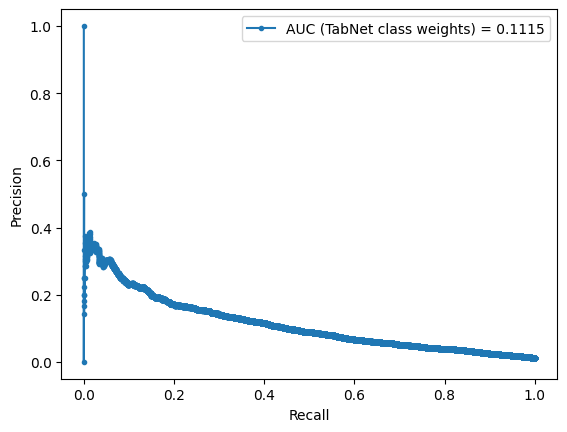

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_tab = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (TabNet class weights) = {auc_tab:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
##custom scorer
from sklearn.metrics import recall_score

#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_valid_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_valid), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_valid, y_pred)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_valid, y_pred)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)

Chosen threshold: 0.9935941100120544
False Positive Rate: 6.316161794800536e-06
Recall: 0.0
[[158323      1]
 [  1676      0]]


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.19651 |  0:00:01s
epoch 1  | loss: 0.06046 |  0:00:03s
epoch 2  | loss: 0.05692 |  0:00:04s
epoch 3  | loss: 0.05366 |  0:00:06s
epoch 4  | loss: 0.0529  |  0:00:07s
epoch 5  | loss: 0.0518  |  0:00:09s
epoch 6  | loss: 0.0513  |  0:00:11s
epoch 7  | loss: 0.0499  |  0:00:12s
epoch 8  | loss: 0.04928 |  0:00:14s
epoch 9  | loss: 0.04881 |  0:00:16s
epoch 10 | loss: 0.04851 |  0:00:17s
epoch 11 | loss: 0.04711 |  0:00:19s
epoch 12 | loss: 0.04657 |  0:00:21s
epoch 13 | loss: 0.04592 |  0:00:22s
epoch 14 | loss: 0.0467  |  0:00:24s
epoch 15 | loss: 0.04559 |  0:00:25s
epoch 16 | loss: 0.04487 |  0:00:27s
epoch 17 | loss: 0.04557 |  0:00:29s
epoch 18 | loss: 0.04475 |  0:00:30s
epoch 19 | loss: 0.04487 |  0:00:32s
epoch 20 | loss: 0.04498 |  0:00:33s
epoch 21 | loss: 0.04432 |  0:00:35s
epoch 22 | loss: 0.04495 |  0:00:37s
epoch 23 | loss: 0.04437 |  0:00:38s
epoch 24 | loss: 0.04356 |  0:00:40s
epoch 25 | loss: 0.04248 |  0:00:41s
epoch 26 | loss: 0.04157 |  0:00:43s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10098 |  0:00:05s
epoch 1  | loss: 0.05506 |  0:00:10s
epoch 2  | loss: 0.052   |  0:00:15s
epoch 3  | loss: 0.05047 |  0:00:21s
epoch 4  | loss: 0.04979 |  0:00:26s
epoch 5  | loss: 0.04889 |  0:00:31s
epoch 6  | loss: 0.04842 |  0:00:37s
epoch 7  | loss: 0.0482  |  0:00:42s
epoch 8  | loss: 0.04788 |  0:00:47s
epoch 9  | loss: 0.04778 |  0:00:53s
epoch 10 | loss: 0.04757 |  0:00:58s
epoch 11 | loss: 0.04757 |  0:01:03s
epoch 12 | loss: 0.04722 |  0:01:08s
epoch 13 | loss: 0.04814 |  0:01:14s
epoch 14 | loss: 0.0478  |  0:01:19s
epoch 15 | loss: 0.04756 |  0:01:25s
epoch 16 | loss: 0.04702 |  0:01:30s
epoch 17 | loss: 0.04649 |  0:01:35s
epoch 18 | loss: 0.0462  |  0:01:41s
epoch 19 | loss: 0.04615 |  0:01:46s
epoch 20 | loss: 0.04609 |  0:01:51s
epoch 21 | loss: 0.0459  |  0:01:57s
epoch 22 | loss: 0.04575 |  0:02:02s
epoch 23 | loss: 0.04567 |  0:02:07s
epoch 24 | loss: 0.04541 |  0:02:13s
epoch 25 | loss: 0.04527 |  0:02:18s
epoch 26 | loss: 0.04524 |  0:02:23s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08578 |  0:00:09s
epoch 1  | loss: 0.05356 |  0:00:17s
epoch 2  | loss: 0.05066 |  0:00:26s
epoch 3  | loss: 0.04945 |  0:00:36s
epoch 4  | loss: 0.04871 |  0:00:45s
epoch 5  | loss: 0.04799 |  0:00:54s
epoch 6  | loss: 0.04744 |  0:01:03s
epoch 7  | loss: 0.04732 |  0:01:12s
epoch 8  | loss: 0.04717 |  0:01:21s
epoch 9  | loss: 0.04704 |  0:01:30s
epoch 10 | loss: 0.04682 |  0:01:39s
epoch 11 | loss: 0.04682 |  0:01:48s
epoch 12 | loss: 0.04668 |  0:01:57s
epoch 13 | loss: 0.04649 |  0:02:06s
epoch 14 | loss: 0.04633 |  0:02:15s
epoch 15 | loss: 0.04617 |  0:02:24s
epoch 16 | loss: 0.04619 |  0:02:33s
epoch 17 | loss: 0.04599 |  0:02:42s
epoch 18 | loss: 0.04593 |  0:02:52s
epoch 19 | loss: 0.04601 |  0:03:01s
epoch 20 | loss: 0.0465  |  0:03:10s
epoch 21 | loss: 0.04586 |  0:03:19s
epoch 22 | loss: 0.04582 |  0:03:28s
epoch 23 | loss: 0.04569 |  0:03:37s
epoch 24 | loss: 0.04555 |  0:03:46s
epoch 25 | loss: 0.04522 |  0:03:55s
epoch 26 | loss: 0.04524 |  0:04:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07427 |  0:00:12s
epoch 1  | loss: 0.0516  |  0:00:25s
epoch 2  | loss: 0.05032 |  0:00:38s
epoch 3  | loss: 0.04902 |  0:00:51s
epoch 4  | loss: 0.04839 |  0:01:03s
epoch 5  | loss: 0.04829 |  0:01:16s
epoch 6  | loss: 0.0479  |  0:01:29s
epoch 7  | loss: 0.04774 |  0:01:42s
epoch 8  | loss: 0.04747 |  0:01:55s
epoch 9  | loss: 0.04766 |  0:02:07s
epoch 10 | loss: 0.04727 |  0:02:20s
epoch 11 | loss: 0.04689 |  0:02:33s
epoch 12 | loss: 0.04672 |  0:02:46s
epoch 13 | loss: 0.04687 |  0:02:58s
epoch 14 | loss: 0.04696 |  0:03:11s
epoch 15 | loss: 0.04745 |  0:03:24s
epoch 16 | loss: 0.04719 |  0:03:36s
epoch 17 | loss: 0.04673 |  0:03:49s
epoch 18 | loss: 0.04648 |  0:04:02s
epoch 19 | loss: 0.04642 |  0:04:14s
epoch 20 | loss: 0.04648 |  0:04:27s
epoch 21 | loss: 0.04648 |  0:04:40s
epoch 22 | loss: 0.04616 |  0:04:53s
epoch 23 | loss: 0.04603 |  0:05:06s
epoch 24 | loss: 0.04637 |  0:05:18s
epoch 25 | loss: 0.04681 |  0:05:31s
epoch 26 | loss: 0.04609 |  0:05:44s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07105 |  0:00:16s
epoch 1  | loss: 0.05121 |  0:00:32s
epoch 2  | loss: 0.04957 |  0:00:49s
epoch 3  | loss: 0.0487  |  0:01:05s
epoch 4  | loss: 0.04854 |  0:01:22s
epoch 5  | loss: 0.04806 |  0:01:38s
epoch 6  | loss: 0.04823 |  0:01:55s
epoch 7  | loss: 0.0478  |  0:02:12s
epoch 8  | loss: 0.0477  |  0:02:28s
epoch 9  | loss: 0.04779 |  0:02:45s
epoch 10 | loss: 0.04756 |  0:03:02s
epoch 11 | loss: 0.04728 |  0:03:19s
epoch 12 | loss: 0.04731 |  0:03:35s
epoch 13 | loss: 0.0471  |  0:03:52s
epoch 14 | loss: 0.04695 |  0:04:09s
epoch 15 | loss: 0.04688 |  0:04:25s
epoch 16 | loss: 0.04681 |  0:04:42s
epoch 17 | loss: 0.04705 |  0:04:59s
epoch 18 | loss: 0.04659 |  0:05:16s
epoch 19 | loss: 0.04644 |  0:05:32s
epoch 20 | loss: 0.04625 |  0:05:49s
epoch 21 | loss: 0.04619 |  0:06:05s
epoch 22 | loss: 0.04591 |  0:06:22s
epoch 23 | loss: 0.0462  |  0:06:38s
epoch 24 | loss: 0.04591 |  0:06:55s
epoch 25 | loss: 0.04588 |  0:07:12s
epoch 26 | loss: 0.04608 |  0:07:28s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.20184 |  0:00:01s
epoch 1  | loss: 0.05967 |  0:00:03s
epoch 2  | loss: 0.05562 |  0:00:04s
epoch 3  | loss: 0.05462 |  0:00:06s
epoch 4  | loss: 0.05241 |  0:00:08s
epoch 5  | loss: 0.05264 |  0:00:09s
epoch 6  | loss: 0.05174 |  0:00:11s
epoch 7  | loss: 0.05083 |  0:00:13s
epoch 8  | loss: 0.05023 |  0:00:14s
epoch 9  | loss: 0.0499  |  0:00:16s
epoch 10 | loss: 0.04879 |  0:00:18s
epoch 11 | loss: 0.04825 |  0:00:19s
epoch 12 | loss: 0.04858 |  0:00:21s
epoch 13 | loss: 0.04725 |  0:00:23s
epoch 14 | loss: 0.04674 |  0:00:24s
epoch 15 | loss: 0.04603 |  0:00:26s
epoch 16 | loss: 0.04649 |  0:00:27s
epoch 17 | loss: 0.04615 |  0:00:29s
epoch 18 | loss: 0.04665 |  0:00:31s
epoch 19 | loss: 0.04573 |  0:00:32s
epoch 20 | loss: 0.04616 |  0:00:34s
epoch 21 | loss: 0.04534 |  0:00:36s
epoch 22 | loss: 0.04496 |  0:00:37s
epoch 23 | loss: 0.04463 |  0:00:39s
epoch 24 | loss: 0.04589 |  0:00:41s
epoch 25 | loss: 0.04446 |  0:00:42s
epoch 26 | loss: 0.04337 |  0:00:44s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10181 |  0:00:05s
epoch 1  | loss: 0.056   |  0:00:10s
epoch 2  | loss: 0.05282 |  0:00:16s
epoch 3  | loss: 0.05109 |  0:00:21s
epoch 4  | loss: 0.04979 |  0:00:26s
epoch 5  | loss: 0.04867 |  0:00:31s
epoch 6  | loss: 0.04804 |  0:00:37s
epoch 7  | loss: 0.04774 |  0:00:42s
epoch 8  | loss: 0.04731 |  0:00:48s
epoch 9  | loss: 0.04702 |  0:00:53s
epoch 10 | loss: 0.04697 |  0:00:58s
epoch 11 | loss: 0.04691 |  0:01:04s
epoch 12 | loss: 0.04636 |  0:01:09s
epoch 13 | loss: 0.04617 |  0:01:14s
epoch 14 | loss: 0.04602 |  0:01:20s
epoch 15 | loss: 0.04563 |  0:01:25s
epoch 16 | loss: 0.04574 |  0:01:31s
epoch 17 | loss: 0.04583 |  0:01:36s
epoch 18 | loss: 0.04558 |  0:01:41s
epoch 19 | loss: 0.04507 |  0:01:47s
epoch 20 | loss: 0.04524 |  0:01:52s
epoch 21 | loss: 0.04513 |  0:01:57s
epoch 22 | loss: 0.04506 |  0:02:03s
epoch 23 | loss: 0.04461 |  0:02:08s
epoch 24 | loss: 0.04462 |  0:02:14s
epoch 25 | loss: 0.04426 |  0:02:19s
epoch 26 | loss: 0.04455 |  0:02:24s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08324 |  0:00:08s
epoch 1  | loss: 0.05221 |  0:00:17s
epoch 2  | loss: 0.05065 |  0:00:26s
epoch 3  | loss: 0.04989 |  0:00:35s
epoch 4  | loss: 0.04931 |  0:00:45s
epoch 5  | loss: 0.04883 |  0:00:54s
epoch 6  | loss: 0.0484  |  0:01:03s
epoch 7  | loss: 0.04819 |  0:01:12s
epoch 8  | loss: 0.04778 |  0:01:21s
epoch 9  | loss: 0.04767 |  0:01:30s
epoch 10 | loss: 0.04753 |  0:01:39s
epoch 11 | loss: 0.04738 |  0:01:48s
epoch 12 | loss: 0.04721 |  0:01:57s
epoch 13 | loss: 0.04702 |  0:02:06s
epoch 14 | loss: 0.0468  |  0:02:15s
epoch 15 | loss: 0.04663 |  0:02:24s
epoch 16 | loss: 0.04642 |  0:02:33s
epoch 17 | loss: 0.04673 |  0:02:42s
epoch 18 | loss: 0.04647 |  0:02:51s
epoch 19 | loss: 0.04618 |  0:03:00s
epoch 20 | loss: 0.04615 |  0:03:09s
epoch 21 | loss: 0.04628 |  0:03:18s
epoch 22 | loss: 0.04622 |  0:03:27s
epoch 23 | loss: 0.04689 |  0:03:36s
epoch 24 | loss: 0.04681 |  0:03:46s
epoch 25 | loss: 0.04624 |  0:03:55s
epoch 26 | loss: 0.04566 |  0:04:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07544 |  0:00:12s
epoch 1  | loss: 0.05215 |  0:00:25s
epoch 2  | loss: 0.05032 |  0:00:38s
epoch 3  | loss: 0.04977 |  0:00:50s
epoch 4  | loss: 0.04927 |  0:01:03s
epoch 5  | loss: 0.04947 |  0:01:16s
epoch 6  | loss: 0.04901 |  0:01:28s
epoch 7  | loss: 0.0497  |  0:01:41s
epoch 8  | loss: 0.0488  |  0:01:54s
epoch 9  | loss: 0.04833 |  0:02:07s
epoch 10 | loss: 0.04804 |  0:02:19s
epoch 11 | loss: 0.04817 |  0:02:32s
epoch 12 | loss: 0.04775 |  0:02:45s
epoch 13 | loss: 0.04868 |  0:02:58s
epoch 14 | loss: 0.0484  |  0:03:11s
epoch 15 | loss: 0.04772 |  0:03:24s
epoch 16 | loss: 0.04768 |  0:03:36s
epoch 17 | loss: 0.04762 |  0:03:49s
epoch 18 | loss: 0.04785 |  0:04:02s
epoch 19 | loss: 0.04875 |  0:04:15s
epoch 20 | loss: 0.04759 |  0:04:28s
epoch 21 | loss: 0.04729 |  0:04:41s
epoch 22 | loss: 0.04742 |  0:04:54s
epoch 23 | loss: 0.04701 |  0:05:07s
epoch 24 | loss: 0.0469  |  0:05:19s
epoch 25 | loss: 0.0468  |  0:05:32s
epoch 26 | loss: 0.04694 |  0:05:45s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07101 |  0:00:16s
epoch 1  | loss: 0.05086 |  0:00:33s
epoch 2  | loss: 0.04976 |  0:00:49s
epoch 3  | loss: 0.04889 |  0:01:05s
epoch 4  | loss: 0.04844 |  0:01:22s
epoch 5  | loss: 0.04825 |  0:01:38s
epoch 6  | loss: 0.04799 |  0:01:55s
epoch 7  | loss: 0.04809 |  0:02:11s
epoch 8  | loss: 0.04767 |  0:02:27s
epoch 9  | loss: 0.04758 |  0:02:44s
epoch 10 | loss: 0.04738 |  0:03:00s
epoch 11 | loss: 0.04713 |  0:03:17s
epoch 12 | loss: 0.04718 |  0:03:33s
epoch 13 | loss: 0.04688 |  0:03:50s
epoch 14 | loss: 0.04685 |  0:04:07s
epoch 15 | loss: 0.04652 |  0:04:23s
epoch 16 | loss: 0.04637 |  0:04:40s
epoch 17 | loss: 0.04638 |  0:04:56s
epoch 18 | loss: 0.04647 |  0:05:13s
epoch 19 | loss: 0.04616 |  0:05:29s
epoch 20 | loss: 0.0462  |  0:05:46s
epoch 21 | loss: 0.04643 |  0:06:02s
epoch 22 | loss: 0.04603 |  0:06:19s
epoch 23 | loss: 0.04593 |  0:06:35s
epoch 24 | loss: 0.04593 |  0:06:52s
epoch 25 | loss: 0.04571 |  0:07:09s
epoch 26 | loss: 0.04552 |  0:07:25s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.20184 |  0:00:01s
epoch 1  | loss: 0.05967 |  0:00:03s
epoch 2  | loss: 0.05562 |  0:00:04s
epoch 3  | loss: 0.05462 |  0:00:06s
epoch 4  | loss: 0.05241 |  0:00:07s
epoch 5  | loss: 0.05264 |  0:00:09s
epoch 6  | loss: 0.05174 |  0:00:11s
epoch 7  | loss: 0.05083 |  0:00:12s
epoch 8  | loss: 0.05023 |  0:00:14s
epoch 9  | loss: 0.0499  |  0:00:15s
epoch 10 | loss: 0.04879 |  0:00:17s
epoch 11 | loss: 0.04825 |  0:00:19s
epoch 12 | loss: 0.04858 |  0:00:20s
epoch 13 | loss: 0.04725 |  0:00:22s
epoch 14 | loss: 0.04674 |  0:00:24s
epoch 15 | loss: 0.04603 |  0:00:25s
epoch 16 | loss: 0.04649 |  0:00:27s
epoch 17 | loss: 0.04615 |  0:00:28s
epoch 18 | loss: 0.04665 |  0:00:30s
epoch 19 | loss: 0.04573 |  0:00:32s
epoch 20 | loss: 0.04616 |  0:00:33s
epoch 21 | loss: 0.04534 |  0:00:35s
epoch 22 | loss: 0.04496 |  0:00:36s
epoch 23 | loss: 0.04463 |  0:00:38s
epoch 24 | loss: 0.04589 |  0:00:40s
epoch 25 | loss: 0.04446 |  0:00:41s
epoch 26 | loss: 0.04337 |  0:00:43s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10181 |  0:00:05s
epoch 1  | loss: 0.056   |  0:00:10s
epoch 2  | loss: 0.05282 |  0:00:16s
epoch 3  | loss: 0.05109 |  0:00:21s
epoch 4  | loss: 0.04979 |  0:00:27s
epoch 5  | loss: 0.04867 |  0:00:32s
epoch 6  | loss: 0.04804 |  0:00:37s
epoch 7  | loss: 0.04774 |  0:00:43s
epoch 8  | loss: 0.04731 |  0:00:48s
epoch 9  | loss: 0.04702 |  0:00:53s
epoch 10 | loss: 0.04697 |  0:00:59s
epoch 11 | loss: 0.04691 |  0:01:04s
epoch 12 | loss: 0.04636 |  0:01:09s
epoch 13 | loss: 0.04617 |  0:01:15s
epoch 14 | loss: 0.04602 |  0:01:20s
epoch 15 | loss: 0.04563 |  0:01:25s
epoch 16 | loss: 0.04574 |  0:01:31s
epoch 17 | loss: 0.04583 |  0:01:36s
epoch 18 | loss: 0.04558 |  0:01:41s
epoch 19 | loss: 0.04507 |  0:01:47s
epoch 20 | loss: 0.04524 |  0:01:52s
epoch 21 | loss: 0.04513 |  0:01:57s
epoch 22 | loss: 0.04506 |  0:02:03s
epoch 23 | loss: 0.04461 |  0:02:08s
epoch 24 | loss: 0.04462 |  0:02:13s
epoch 25 | loss: 0.04426 |  0:02:19s
epoch 26 | loss: 0.04455 |  0:02:24s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08422 |  0:00:08s
epoch 1  | loss: 0.05379 |  0:00:17s
epoch 2  | loss: 0.05126 |  0:00:26s
epoch 3  | loss: 0.04987 |  0:00:35s
epoch 4  | loss: 0.04928 |  0:00:44s
epoch 5  | loss: 0.04877 |  0:00:53s
epoch 6  | loss: 0.04827 |  0:01:02s
epoch 7  | loss: 0.04772 |  0:01:12s
epoch 8  | loss: 0.04749 |  0:01:21s
epoch 9  | loss: 0.04738 |  0:01:30s
epoch 10 | loss: 0.04714 |  0:01:39s
epoch 11 | loss: 0.04702 |  0:01:48s
epoch 12 | loss: 0.04687 |  0:01:57s
epoch 13 | loss: 0.04666 |  0:02:06s
epoch 14 | loss: 0.04684 |  0:02:15s
epoch 15 | loss: 0.04725 |  0:02:24s
epoch 16 | loss: 0.04699 |  0:02:33s
epoch 17 | loss: 0.04704 |  0:02:42s
epoch 18 | loss: 0.0466  |  0:02:52s
epoch 19 | loss: 0.04722 |  0:03:01s
epoch 20 | loss: 0.04647 |  0:03:10s
epoch 21 | loss: 0.0462  |  0:03:19s
epoch 22 | loss: 0.04606 |  0:03:28s
epoch 23 | loss: 0.046   |  0:03:37s
epoch 24 | loss: 0.04583 |  0:03:46s
epoch 25 | loss: 0.04598 |  0:03:55s
epoch 26 | loss: 0.04554 |  0:04:04s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07387 |  0:00:12s
epoch 1  | loss: 0.0511  |  0:00:25s
epoch 2  | loss: 0.0496  |  0:00:37s
epoch 3  | loss: 0.0491  |  0:00:50s
epoch 4  | loss: 0.04856 |  0:01:03s
epoch 5  | loss: 0.04828 |  0:01:15s
epoch 6  | loss: 0.04792 |  0:01:28s
epoch 7  | loss: 0.04786 |  0:01:41s
epoch 8  | loss: 0.04761 |  0:01:54s
epoch 9  | loss: 0.04775 |  0:02:07s
epoch 10 | loss: 0.04729 |  0:02:19s
epoch 11 | loss: 0.04719 |  0:02:32s
epoch 12 | loss: 0.04707 |  0:02:45s
epoch 13 | loss: 0.04709 |  0:02:57s
epoch 14 | loss: 0.04672 |  0:03:10s
epoch 15 | loss: 0.04673 |  0:03:23s
epoch 16 | loss: 0.04693 |  0:03:36s
epoch 17 | loss: 0.04662 |  0:03:49s
epoch 18 | loss: 0.04652 |  0:04:01s
epoch 19 | loss: 0.04617 |  0:04:14s
epoch 20 | loss: 0.04637 |  0:04:27s
epoch 21 | loss: 0.04589 |  0:04:39s
epoch 22 | loss: 0.04593 |  0:04:52s
epoch 23 | loss: 0.04587 |  0:05:05s
epoch 24 | loss: 0.04576 |  0:05:17s
epoch 25 | loss: 0.04553 |  0:05:30s
epoch 26 | loss: 0.04542 |  0:05:43s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07109 |  0:00:16s
epoch 1  | loss: 0.05064 |  0:00:32s
epoch 2  | loss: 0.04895 |  0:00:48s
epoch 3  | loss: 0.04795 |  0:01:05s
epoch 4  | loss: 0.04749 |  0:01:21s
epoch 5  | loss: 0.04715 |  0:01:37s
epoch 6  | loss: 0.04681 |  0:01:54s
epoch 7  | loss: 0.04696 |  0:02:10s
epoch 8  | loss: 0.0467  |  0:02:26s
epoch 9  | loss: 0.04646 |  0:02:43s
epoch 10 | loss: 0.04638 |  0:02:59s
epoch 11 | loss: 0.0464  |  0:03:15s
epoch 12 | loss: 0.04637 |  0:03:31s
epoch 13 | loss: 0.04593 |  0:03:48s
epoch 14 | loss: 0.04577 |  0:04:04s
epoch 15 | loss: 0.04575 |  0:04:20s
epoch 16 | loss: 0.04578 |  0:04:36s
epoch 17 | loss: 0.04547 |  0:04:53s
epoch 18 | loss: 0.04542 |  0:05:09s
epoch 19 | loss: 0.04554 |  0:05:26s
epoch 20 | loss: 0.04545 |  0:05:42s
epoch 21 | loss: 0.04518 |  0:05:58s
epoch 22 | loss: 0.04537 |  0:06:14s
epoch 23 | loss: 0.04534 |  0:06:31s
epoch 24 | loss: 0.04507 |  0:06:47s
epoch 25 | loss: 0.04502 |  0:07:03s
epoch 26 | loss: 0.04488 |  0:07:19s
e

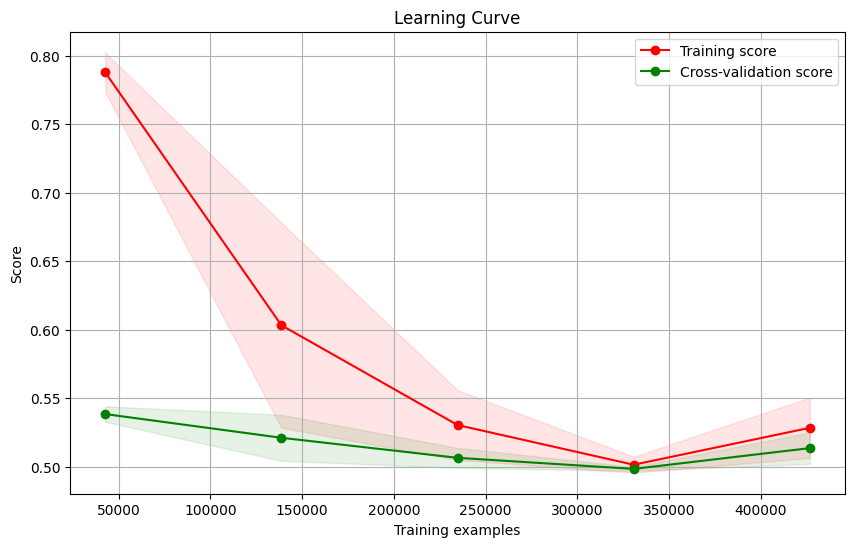

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = "f1_macro"
plot_learning_curve(clf, X_train_array, y_train_resampled, scoring, train_sizes)

In [ ]:
###TabNet transactional data class weights

X_train_transformed = pd.read_csv('X_train_transformed_basic_trans.csv')
X_valid_transformed = pd.read_csv('X_valid_transformed_basic_trans.csv')
X_test_transformed = pd.read_csv('X_test_transformed_basic_trans.csv')

y_train_transformed = pd.read_csv('y_train_basic_trans.csv')
y_valid = pd.read_csv('y_valid_basic_trans.csv')
y_test = pd.read_csv('y_test_basic_trans.csv')
y_train_transformed = np.ravel(y_train_transformed.values)
y_valid = np.ravel(y_valid.values)
y_test = np.ravel(y_test.values)

In [ ]:
X_train_array = X_train_transformed.values  #convert DataFrame to NumPy array
X_valid_array = X_valid_transformed.values

In [ ]:
##unsupervised pre-training
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from custom_metrics import F1Macro  # Import the F1Macro class from custom_metrics.py
from pytorch_tabnet.callbacks import EarlyStopping


# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,  # Use Adam optimizer
    optimizer_params=dict(lr=2e-2),  # Learning rate for the optimizer
    mask_type='entmax'  # Use 'entmax' or 'sparsemax' for masking
)

unsupervised_model.fit(
    X_train=X_train_array,  # Unlabeled training data
    eval_set=[X_valid_array],  # Validation set during pre-training
    max_epochs=50, patience=5,
    drop_last=False,
    pretraining_ratio=0.8,  # Ratio of training data used for pre-training
)

# Create a TabNetClassifier using the pre-trained model
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  #will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train_array,
    y_train=y_train_transformed,
    eval_set=[(X_train_array, y_train_transformed), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    weights=1,
    from_unsupervised=unsupervised_model
)

import dill

# Save the trained model to a file using dill
with open('tabnet_class_weights__trans_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.24962 | val_0_unsup_loss_numpy: 0.9612900018692017|  0:00:36s
epoch 1  | loss: 0.83939 | val_0_unsup_loss_numpy: 0.8026900291442871|  0:01:12s
epoch 2  | loss: 0.78921 | val_0_unsup_loss_numpy: 0.7232999801635742|  0:01:47s
epoch 3  | loss: 0.78325 | val_0_unsup_loss_numpy: 0.8051000237464905|  0:02:22s
epoch 4  | loss: 0.75521 | val_0_unsup_loss_numpy: 0.6863899827003479|  0:02:58s
epoch 5  | loss: 0.7519  | val_0_unsup_loss_numpy: 0.7156299948692322|  0:03:33s
epoch 6  | loss: 0.75104 | val_0_unsup_loss_numpy: 0.6866599917411804|  0:04:09s
epoch 7  | loss: 0.73776 | val_0_unsup_loss_numpy: 0.6640599966049194|  0:04:44s
epoch 8  | loss: 0.73672 | val_0_unsup_loss_numpy: 0.6545799970626831|  0:05:19s
epoch 9  | loss: 0.72922 | val_0_unsup_loss_numpy: 0.6998100280761719|  0:05:54s
epoch 10 | loss: 0.73342 | val_0_unsup_loss_numpy: 0.6567100286483765|  0:06:29s
epoch 11 | loss: 0.72976 | val_0_unsup_loss_numpy: 0.6528199911117554|  0:07:04s
epoch 12 | loss: 0.72695 | v

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


NameError: ignored

In [ ]:
clf.fit(
    X_train=X_train_array,
    y_train=y_train_transformed,
    eval_set=[(X_train_array, y_train_transformed), (X_valid_array, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1Macro],
    max_epochs=50,
    patience=5,
    drop_last=False,
    weights=1,
    from_unsupervised=unsupervised_model
)



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.53627 | train_f1_macro: 0.46852 | valid_f1_macro: 0.46455 |  0:00:42s
epoch 1  | loss: 0.46641 | train_f1_macro: 0.48094 | valid_f1_macro: 0.47667 |  0:01:25s
epoch 2  | loss: 0.45733 | train_f1_macro: 0.47891 | valid_f1_macro: 0.47461 |  0:02:08s
epoch 3  | loss: 0.446   | train_f1_macro: 0.47291 | valid_f1_macro: 0.46756 |  0:02:52s
epoch 4  | loss: 0.43346 | train_f1_macro: 0.47586 | valid_f1_macro: 0.46909 |  0:03:35s
epoch 5  | loss: 0.42304 | train_f1_macro: 0.46809 | valid_f1_macro: 0.46109 |  0:04:18s
epoch 6  | loss: 0.41369 | train_f1_macro: 0.47835 | valid_f1_macro: 0.47032 |  0:05:01s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_valid_f1_macro = 0.47667


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


ModuleNotFoundError: ignored

In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
import dill

# Save the trained model to a file using dill
with open('tabnet_class_weights__trans_pretrained.pkl', 'wb') as f:
    dill.dump(clf, f)

NameError: ignored

In [ ]:
y_pred = clf.predict(X_valid_array)

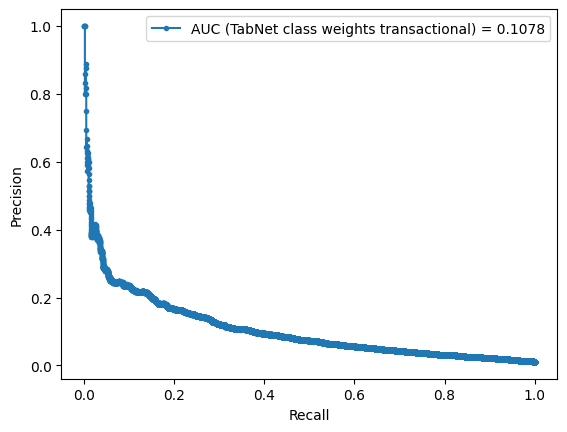

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
y_valid =  y_valid
probabilities = clf.predict_proba(X_valid_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_valid, probabilities)
auc_tab = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (TabNet class weights transactional) = {auc_tab:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
f1 = f1_score(y_valid, y_pred, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_valid, y_pred, average = "weighted")
print(f"F1 Score: {f1:.4f}")

##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

F1 Score: 0.4767
F1 Score: 0.8747
Confusion Matrix:
[[125545  32779]
 [   424   1252]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    158324
           1       0.04      0.75      0.07      1676

    accuracy                           0.79    160000
   macro avg       0.52      0.77      0.48    160000
weighted avg       0.99      0.79      0.87    160000



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.19615 |  0:00:01s
epoch 1  | loss: 0.05806 |  0:00:03s
epoch 2  | loss: 0.05504 |  0:00:05s
epoch 3  | loss: 0.05222 |  0:00:06s
epoch 4  | loss: 0.05125 |  0:00:08s
epoch 5  | loss: 0.05062 |  0:00:09s
epoch 6  | loss: 0.05036 |  0:00:11s
epoch 7  | loss: 0.05034 |  0:00:12s
epoch 8  | loss: 0.04937 |  0:00:14s
epoch 9  | loss: 0.04994 |  0:00:16s
epoch 10 | loss: 0.04919 |  0:00:17s
epoch 11 | loss: 0.04898 |  0:00:19s
epoch 12 | loss: 0.04831 |  0:00:21s
epoch 13 | loss: 0.04761 |  0:00:22s
epoch 14 | loss: 0.04735 |  0:00:24s
epoch 15 | loss: 0.04706 |  0:00:25s
epoch 16 | loss: 0.04708 |  0:00:27s
epoch 17 | loss: 0.04548 |  0:00:29s
epoch 18 | loss: 0.04711 |  0:00:31s
epoch 19 | loss: 0.04589 |  0:00:32s
epoch 20 | loss: 0.04482 |  0:00:34s
epoch 21 | loss: 0.04527 |  0:00:35s
epoch 22 | loss: 0.04445 |  0:00:37s
epoch 23 | loss: 0.04437 |  0:00:38s
epoch 24 | loss: 0.04425 |  0:00:40s
epoch 25 | loss: 0.04387 |  0:00:42s
epoch 26 | loss: 0.04391 |  0:00:43s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.1005  |  0:00:05s
epoch 1  | loss: 0.05543 |  0:00:11s
epoch 2  | loss: 0.05375 |  0:00:16s
epoch 3  | loss: 0.05229 |  0:00:21s
epoch 4  | loss: 0.05136 |  0:00:27s
epoch 5  | loss: 0.05129 |  0:00:32s
epoch 6  | loss: 0.0507  |  0:00:37s
epoch 7  | loss: 0.05026 |  0:00:43s
epoch 8  | loss: 0.04971 |  0:00:48s
epoch 9  | loss: 0.0497  |  0:00:54s
epoch 10 | loss: 0.04956 |  0:00:59s
epoch 11 | loss: 0.04951 |  0:01:04s
epoch 12 | loss: 0.04969 |  0:01:10s
epoch 13 | loss: 0.04951 |  0:01:15s
epoch 14 | loss: 0.04952 |  0:01:20s
epoch 15 | loss: 0.04915 |  0:01:26s
epoch 16 | loss: 0.04901 |  0:01:31s
epoch 17 | loss: 0.04903 |  0:01:36s
epoch 18 | loss: 0.04897 |  0:01:42s
epoch 19 | loss: 0.04902 |  0:01:47s
epoch 20 | loss: 0.04908 |  0:01:52s
epoch 21 | loss: 0.04924 |  0:01:58s
epoch 22 | loss: 0.04908 |  0:02:03s
epoch 23 | loss: 0.04893 |  0:02:09s
epoch 24 | loss: 0.04909 |  0:02:14s
epoch 25 | loss: 0.04863 |  0:02:19s
epoch 26 | loss: 0.04831 |  0:02:25s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08363 |  0:00:08s
epoch 1  | loss: 0.05348 |  0:00:17s
epoch 2  | loss: 0.05169 |  0:00:26s
epoch 3  | loss: 0.05093 |  0:00:36s
epoch 4  | loss: 0.05073 |  0:00:45s
epoch 5  | loss: 0.05017 |  0:00:54s
epoch 6  | loss: 0.05018 |  0:01:03s
epoch 7  | loss: 0.05009 |  0:01:12s
epoch 8  | loss: 0.04975 |  0:01:21s
epoch 9  | loss: 0.04953 |  0:01:30s
epoch 10 | loss: 0.04961 |  0:01:39s
epoch 11 | loss: 0.04946 |  0:01:49s
epoch 12 | loss: 0.04958 |  0:01:58s
epoch 13 | loss: 0.04938 |  0:02:07s
epoch 14 | loss: 0.04911 |  0:02:16s
epoch 15 | loss: 0.04901 |  0:02:25s
epoch 16 | loss: 0.04878 |  0:02:34s
epoch 17 | loss: 0.04882 |  0:02:43s
epoch 18 | loss: 0.04867 |  0:02:52s
epoch 19 | loss: 0.04863 |  0:03:01s
epoch 20 | loss: 0.04847 |  0:03:10s
epoch 21 | loss: 0.04833 |  0:03:20s
epoch 22 | loss: 0.04833 |  0:03:29s
epoch 23 | loss: 0.04836 |  0:03:38s
epoch 24 | loss: 0.04821 |  0:03:47s
epoch 25 | loss: 0.04803 |  0:03:56s
epoch 26 | loss: 0.04813 |  0:04:06s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07541 |  0:00:12s
epoch 1  | loss: 0.05274 |  0:00:25s
epoch 2  | loss: 0.05149 |  0:00:38s
epoch 3  | loss: 0.05073 |  0:00:50s
epoch 4  | loss: 0.0505  |  0:01:03s
epoch 5  | loss: 0.05016 |  0:01:16s
epoch 6  | loss: 0.05007 |  0:01:28s
epoch 7  | loss: 0.04977 |  0:01:41s
epoch 8  | loss: 0.04987 |  0:01:54s
epoch 9  | loss: 0.04955 |  0:02:07s
epoch 10 | loss: 0.04942 |  0:02:19s
epoch 11 | loss: 0.04927 |  0:02:32s
epoch 12 | loss: 0.04906 |  0:02:45s
epoch 13 | loss: 0.04949 |  0:02:58s
epoch 14 | loss: 0.04939 |  0:03:10s
epoch 15 | loss: 0.04922 |  0:03:23s
epoch 16 | loss: 0.04931 |  0:03:38s
epoch 17 | loss: 0.04904 |  0:03:51s
epoch 18 | loss: 0.04898 |  0:04:05s
epoch 19 | loss: 0.0489  |  0:04:18s
epoch 20 | loss: 0.04864 |  0:04:31s
epoch 21 | loss: 0.04849 |  0:04:44s
epoch 22 | loss: 0.04847 |  0:04:57s
epoch 23 | loss: 0.04848 |  0:05:10s
epoch 24 | loss: 0.0485  |  0:05:22s
epoch 25 | loss: 0.04823 |  0:05:35s
epoch 26 | loss: 0.04835 |  0:05:48s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07158 |  0:00:16s
epoch 1  | loss: 0.05324 |  0:00:32s
epoch 2  | loss: 0.05138 |  0:00:49s
epoch 3  | loss: 0.05123 |  0:01:05s
epoch 4  | loss: 0.05074 |  0:01:22s
epoch 5  | loss: 0.0504  |  0:01:38s
epoch 6  | loss: 0.05025 |  0:01:55s
epoch 7  | loss: 0.05013 |  0:02:11s
epoch 8  | loss: 0.04993 |  0:02:27s
epoch 9  | loss: 0.04988 |  0:02:44s
epoch 10 | loss: 0.0498  |  0:03:00s
epoch 11 | loss: 0.04981 |  0:03:16s
epoch 12 | loss: 0.0498  |  0:03:33s
epoch 13 | loss: 0.04994 |  0:03:49s
epoch 14 | loss: 0.04961 |  0:04:06s
epoch 15 | loss: 0.04953 |  0:04:22s
epoch 16 | loss: 0.04924 |  0:04:39s
epoch 17 | loss: 0.04913 |  0:04:55s
epoch 18 | loss: 0.04896 |  0:05:11s
epoch 19 | loss: 0.04902 |  0:05:28s
epoch 20 | loss: 0.0489  |  0:05:44s
epoch 21 | loss: 0.04891 |  0:06:01s
epoch 22 | loss: 0.04892 |  0:06:17s
epoch 23 | loss: 0.04884 |  0:06:34s
epoch 24 | loss: 0.04875 |  0:06:50s
epoch 25 | loss: 0.04863 |  0:07:07s
epoch 26 | loss: 0.04852 |  0:07:23s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.20419 |  0:00:01s
epoch 1  | loss: 0.05983 |  0:00:03s
epoch 2  | loss: 0.05591 |  0:00:04s
epoch 3  | loss: 0.05542 |  0:00:06s
epoch 4  | loss: 0.05448 |  0:00:08s
epoch 5  | loss: 0.05352 |  0:00:09s
epoch 6  | loss: 0.05265 |  0:00:11s
epoch 7  | loss: 0.05332 |  0:00:12s
epoch 8  | loss: 0.05322 |  0:00:14s
epoch 9  | loss: 0.05279 |  0:00:16s
epoch 10 | loss: 0.05165 |  0:00:17s
epoch 11 | loss: 0.05074 |  0:00:19s
epoch 12 | loss: 0.05134 |  0:00:20s
epoch 13 | loss: 0.05058 |  0:00:22s
epoch 14 | loss: 0.05037 |  0:00:24s
epoch 15 | loss: 0.0492  |  0:00:25s
epoch 16 | loss: 0.04863 |  0:00:27s
epoch 17 | loss: 0.04824 |  0:00:28s
epoch 18 | loss: 0.04796 |  0:00:30s
epoch 19 | loss: 0.04852 |  0:00:32s
epoch 20 | loss: 0.04826 |  0:00:33s
epoch 21 | loss: 0.04709 |  0:00:35s
epoch 22 | loss: 0.04738 |  0:00:36s
epoch 23 | loss: 0.04854 |  0:00:38s
epoch 24 | loss: 0.04687 |  0:00:40s
epoch 25 | loss: 0.04706 |  0:00:41s
epoch 26 | loss: 0.04771 |  0:00:43s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10412 |  0:00:05s
epoch 1  | loss: 0.05653 |  0:00:10s
epoch 2  | loss: 0.05413 |  0:00:15s
epoch 3  | loss: 0.05293 |  0:00:21s
epoch 4  | loss: 0.05198 |  0:00:26s
epoch 5  | loss: 0.05129 |  0:00:31s
epoch 6  | loss: 0.05106 |  0:00:37s
epoch 7  | loss: 0.05057 |  0:00:42s
epoch 8  | loss: 0.05035 |  0:00:47s
epoch 9  | loss: 0.05015 |  0:00:53s
epoch 10 | loss: 0.05001 |  0:00:58s
epoch 11 | loss: 0.04967 |  0:01:03s
epoch 12 | loss: 0.0492  |  0:01:09s
epoch 13 | loss: 0.0496  |  0:01:14s
epoch 14 | loss: 0.04924 |  0:01:19s
epoch 15 | loss: 0.04925 |  0:01:25s
epoch 16 | loss: 0.04911 |  0:01:30s
epoch 17 | loss: 0.04879 |  0:01:35s
epoch 18 | loss: 0.04872 |  0:01:41s
epoch 19 | loss: 0.04912 |  0:01:46s
epoch 20 | loss: 0.04943 |  0:01:51s
epoch 21 | loss: 0.04911 |  0:01:57s
epoch 22 | loss: 0.04882 |  0:02:02s
epoch 23 | loss: 0.04902 |  0:02:07s
epoch 24 | loss: 0.04908 |  0:02:13s
epoch 25 | loss: 0.04879 |  0:02:18s
epoch 26 | loss: 0.04838 |  0:02:24s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08415 |  0:00:08s
epoch 1  | loss: 0.05569 |  0:00:18s
epoch 2  | loss: 0.05356 |  0:00:27s
epoch 3  | loss: 0.05245 |  0:00:35s
epoch 4  | loss: 0.05158 |  0:00:44s
epoch 5  | loss: 0.05135 |  0:00:54s
epoch 6  | loss: 0.05111 |  0:01:03s
epoch 7  | loss: 0.05088 |  0:01:12s
epoch 8  | loss: 0.05057 |  0:01:21s
epoch 9  | loss: 0.05035 |  0:01:30s
epoch 10 | loss: 0.05027 |  0:01:39s
epoch 11 | loss: 0.05017 |  0:01:48s
epoch 12 | loss: 0.05002 |  0:01:57s
epoch 13 | loss: 0.0498  |  0:02:06s
epoch 14 | loss: 0.04978 |  0:02:15s
epoch 15 | loss: 0.05147 |  0:02:24s
epoch 16 | loss: 0.05076 |  0:02:32s
epoch 17 | loss: 0.05013 |  0:02:42s
epoch 18 | loss: 0.05031 |  0:02:51s
epoch 19 | loss: 0.04988 |  0:03:00s
epoch 20 | loss: 0.04954 |  0:03:09s
epoch 21 | loss: 0.04937 |  0:03:18s
epoch 22 | loss: 0.04944 |  0:03:27s
epoch 23 | loss: 0.04931 |  0:03:36s
epoch 24 | loss: 0.04922 |  0:03:45s
epoch 25 | loss: 0.04933 |  0:03:53s
epoch 26 | loss: 0.04997 |  0:04:03s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07618 |  0:00:12s
epoch 1  | loss: 0.05416 |  0:00:25s
epoch 2  | loss: 0.05263 |  0:00:38s
epoch 3  | loss: 0.05181 |  0:00:51s
epoch 4  | loss: 0.05121 |  0:01:04s
epoch 5  | loss: 0.05096 |  0:01:18s
epoch 6  | loss: 0.05052 |  0:01:31s
epoch 7  | loss: 0.05038 |  0:01:45s
epoch 8  | loss: 0.05022 |  0:01:58s
epoch 9  | loss: 0.05044 |  0:02:11s
epoch 10 | loss: 0.05021 |  0:02:25s
epoch 11 | loss: 0.04988 |  0:02:38s
epoch 12 | loss: 0.04987 |  0:02:51s
epoch 13 | loss: 0.04977 |  0:03:05s
epoch 14 | loss: 0.04982 |  0:03:18s
epoch 15 | loss: 0.04964 |  0:03:31s
epoch 16 | loss: 0.04958 |  0:03:44s
epoch 17 | loss: 0.0496  |  0:03:58s
epoch 18 | loss: 0.0493  |  0:04:11s
epoch 19 | loss: 0.0492  |  0:04:24s
epoch 20 | loss: 0.04935 |  0:04:38s
epoch 21 | loss: 0.04908 |  0:04:51s
epoch 22 | loss: 0.04898 |  0:05:04s
epoch 23 | loss: 0.04891 |  0:05:17s
epoch 24 | loss: 0.0488  |  0:05:30s
epoch 25 | loss: 0.04872 |  0:05:44s
epoch 26 | loss: 0.04859 |  0:05:57s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07064 |  0:00:17s
epoch 1  | loss: 0.05356 |  0:00:34s
epoch 2  | loss: 0.0529  |  0:00:51s
epoch 3  | loss: 0.05176 |  0:01:08s
epoch 4  | loss: 0.0509  |  0:01:25s
epoch 5  | loss: 0.05086 |  0:01:43s
epoch 6  | loss: 0.05053 |  0:02:00s
epoch 7  | loss: 0.05051 |  0:02:17s
epoch 8  | loss: 0.05096 |  0:02:34s
epoch 9  | loss: 0.05049 |  0:02:51s
epoch 10 | loss: 0.05029 |  0:03:08s
epoch 11 | loss: 0.05008 |  0:03:24s
epoch 12 | loss: 0.05031 |  0:03:41s
epoch 13 | loss: 0.05006 |  0:03:58s
epoch 14 | loss: 0.05001 |  0:04:15s
epoch 15 | loss: 0.04972 |  0:04:32s
epoch 16 | loss: 0.04974 |  0:04:48s
epoch 17 | loss: 0.04963 |  0:05:05s
epoch 18 | loss: 0.04955 |  0:05:22s
epoch 19 | loss: 0.04955 |  0:05:38s
epoch 20 | loss: 0.0495  |  0:05:55s
epoch 21 | loss: 0.04951 |  0:06:12s
epoch 22 | loss: 0.04941 |  0:06:29s
epoch 23 | loss: 0.04924 |  0:06:45s
epoch 24 | loss: 0.04931 |  0:07:02s
epoch 25 | loss: 0.04918 |  0:07:19s
epoch 26 | loss: 0.04907 |  0:07:36s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.20419 |  0:00:01s
epoch 1  | loss: 0.05983 |  0:00:03s
epoch 2  | loss: 0.05591 |  0:00:04s
epoch 3  | loss: 0.05542 |  0:00:06s
epoch 4  | loss: 0.05448 |  0:00:08s
epoch 5  | loss: 0.05352 |  0:00:09s
epoch 6  | loss: 0.05265 |  0:00:11s
epoch 7  | loss: 0.05332 |  0:00:13s
epoch 8  | loss: 0.05322 |  0:00:14s
epoch 9  | loss: 0.05279 |  0:00:16s
epoch 10 | loss: 0.05165 |  0:00:17s
epoch 11 | loss: 0.05074 |  0:00:19s
epoch 12 | loss: 0.05134 |  0:00:21s
epoch 13 | loss: 0.05058 |  0:00:22s
epoch 14 | loss: 0.05037 |  0:00:24s
epoch 15 | loss: 0.0492  |  0:00:26s
epoch 16 | loss: 0.04863 |  0:00:27s
epoch 17 | loss: 0.04824 |  0:00:29s
epoch 18 | loss: 0.04796 |  0:00:31s
epoch 19 | loss: 0.04852 |  0:00:32s
epoch 20 | loss: 0.04826 |  0:00:34s
epoch 21 | loss: 0.04709 |  0:00:36s
epoch 22 | loss: 0.04738 |  0:00:37s
epoch 23 | loss: 0.04854 |  0:00:39s
epoch 24 | loss: 0.04687 |  0:00:41s
epoch 25 | loss: 0.04706 |  0:00:42s
epoch 26 | loss: 0.04771 |  0:00:44s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10412 |  0:00:05s
epoch 1  | loss: 0.05653 |  0:00:11s
epoch 2  | loss: 0.05413 |  0:00:16s
epoch 3  | loss: 0.05293 |  0:00:21s
epoch 4  | loss: 0.05198 |  0:00:27s
epoch 5  | loss: 0.05129 |  0:00:32s
epoch 6  | loss: 0.05106 |  0:00:38s
epoch 7  | loss: 0.05057 |  0:00:43s
epoch 8  | loss: 0.05035 |  0:00:49s
epoch 9  | loss: 0.05015 |  0:00:54s
epoch 10 | loss: 0.05001 |  0:00:59s
epoch 11 | loss: 0.04967 |  0:01:05s
epoch 12 | loss: 0.0492  |  0:01:10s
epoch 13 | loss: 0.0496  |  0:01:16s
epoch 14 | loss: 0.04924 |  0:01:21s
epoch 15 | loss: 0.04925 |  0:01:27s
epoch 16 | loss: 0.04911 |  0:01:32s
epoch 17 | loss: 0.04879 |  0:01:38s
epoch 18 | loss: 0.04872 |  0:01:43s
epoch 19 | loss: 0.04912 |  0:01:49s
epoch 20 | loss: 0.04943 |  0:01:54s
epoch 21 | loss: 0.04911 |  0:02:00s
epoch 22 | loss: 0.04882 |  0:02:05s
epoch 23 | loss: 0.04902 |  0:02:11s
epoch 24 | loss: 0.04908 |  0:02:16s
epoch 25 | loss: 0.04879 |  0:02:21s
epoch 26 | loss: 0.04838 |  0:02:27s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08529 |  0:00:09s
epoch 1  | loss: 0.05452 |  0:00:18s
epoch 2  | loss: 0.05277 |  0:00:27s
epoch 3  | loss: 0.05168 |  0:00:37s
epoch 4  | loss: 0.05094 |  0:00:46s
epoch 5  | loss: 0.05056 |  0:00:55s
epoch 6  | loss: 0.05059 |  0:01:04s
epoch 7  | loss: 0.05059 |  0:01:14s
epoch 8  | loss: 0.05002 |  0:01:23s
epoch 9  | loss: 0.04974 |  0:01:32s
epoch 10 | loss: 0.04968 |  0:01:42s
epoch 11 | loss: 0.0497  |  0:01:51s
epoch 12 | loss: 0.04932 |  0:02:00s
epoch 13 | loss: 0.04932 |  0:02:10s
epoch 14 | loss: 0.04913 |  0:02:19s
epoch 15 | loss: 0.04905 |  0:02:28s
epoch 16 | loss: 0.04893 |  0:02:38s
epoch 17 | loss: 0.04901 |  0:02:47s
epoch 18 | loss: 0.04905 |  0:02:56s
epoch 19 | loss: 0.04953 |  0:03:06s
epoch 20 | loss: 0.04888 |  0:03:15s
epoch 21 | loss: 0.04863 |  0:03:24s
epoch 22 | loss: 0.04861 |  0:03:34s
epoch 23 | loss: 0.04867 |  0:03:43s
epoch 24 | loss: 0.04859 |  0:03:53s
epoch 25 | loss: 0.04835 |  0:04:02s
epoch 26 | loss: 0.04829 |  0:04:12s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07657 |  0:00:12s
epoch 1  | loss: 0.05415 |  0:00:26s
epoch 2  | loss: 0.05186 |  0:00:39s
epoch 3  | loss: 0.05133 |  0:00:52s
epoch 4  | loss: 0.05091 |  0:01:05s
epoch 5  | loss: 0.05062 |  0:01:18s
epoch 6  | loss: 0.05071 |  0:01:31s
epoch 7  | loss: 0.0505  |  0:01:44s
epoch 8  | loss: 0.05025 |  0:01:57s
epoch 9  | loss: 0.05035 |  0:02:10s
epoch 10 | loss: 0.04997 |  0:02:23s
epoch 11 | loss: 0.04972 |  0:02:37s
epoch 12 | loss: 0.05037 |  0:02:50s
epoch 13 | loss: 0.05074 |  0:03:03s
epoch 14 | loss: 0.0508  |  0:03:16s
epoch 15 | loss: 0.05103 |  0:03:29s
epoch 16 | loss: 0.05113 |  0:03:42s
epoch 17 | loss: 0.05068 |  0:03:55s
epoch 18 | loss: 0.05022 |  0:04:08s
epoch 19 | loss: 0.04983 |  0:04:21s
epoch 20 | loss: 0.04969 |  0:04:34s
epoch 21 | loss: 0.04978 |  0:04:47s
epoch 22 | loss: 0.04963 |  0:05:01s
epoch 23 | loss: 0.04954 |  0:05:14s
epoch 24 | loss: 0.04938 |  0:05:27s
epoch 25 | loss: 0.0493  |  0:05:40s
epoch 26 | loss: 0.04917 |  0:05:53s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.06965 |  0:00:17s
epoch 1  | loss: 0.05182 |  0:00:33s
epoch 2  | loss: 0.05066 |  0:00:50s
epoch 3  | loss: 0.05031 |  0:01:07s
epoch 4  | loss: 0.05028 |  0:01:24s
epoch 5  | loss: 0.0497  |  0:01:41s
epoch 6  | loss: 0.04948 |  0:01:58s
epoch 7  | loss: 0.04976 |  0:02:15s
epoch 8  | loss: 0.05012 |  0:02:31s
epoch 9  | loss: 0.04935 |  0:02:48s
epoch 10 | loss: 0.04944 |  0:03:05s
epoch 11 | loss: 0.04913 |  0:03:22s
epoch 12 | loss: 0.04879 |  0:03:40s
epoch 13 | loss: 0.04873 |  0:03:57s
epoch 14 | loss: 0.04883 |  0:04:14s
epoch 15 | loss: 0.04878 |  0:04:31s
epoch 16 | loss: 0.04864 |  0:04:48s
epoch 17 | loss: 0.04857 |  0:05:05s
epoch 18 | loss: 0.04835 |  0:05:22s
epoch 19 | loss: 0.04838 |  0:05:39s
epoch 20 | loss: 0.04834 |  0:05:56s
epoch 21 | loss: 0.04823 |  0:06:13s
epoch 22 | loss: 0.04812 |  0:06:29s
epoch 23 | loss: 0.04816 |  0:06:47s
epoch 24 | loss: 0.04807 |  0:07:04s
epoch 25 | loss: 0.04805 |  0:07:21s
epoch 26 | loss: 0.04777 |  0:07:37s
e

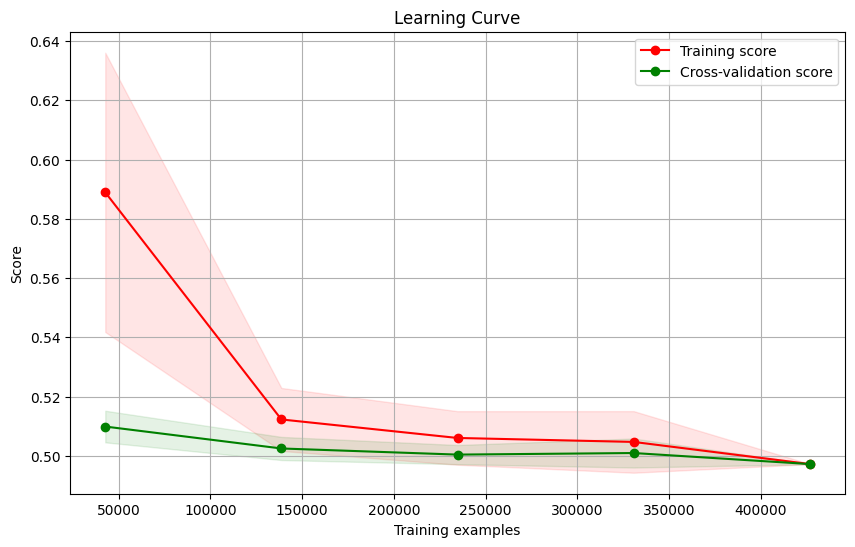

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = "f1_macro"
plot_learning_curve(clf, X_train_array, y_train_transformed, scoring, train_sizes)

In [15]:
##generalization - tabnet with class weights, full data
#import dill

###out-of-sample generalization: best model making predictions on the test set
X_test_transformed = pd.read_csv('X_test_transformed_basicfull.csv')
y_test = pd.read_csv('y_test_basicfull.csv')
y_test = np.ravel(y_test.values)
X_test_array = X_test_transformed.values




In [16]:
y_pred_test = clf.predict(X_test_array)

In [17]:
f1 = f1_score(y_test, y_pred_test, average = "macro")
print(f"F1 Score: {f1:.4f}")

f1 = f1_score(y_test, y_pred_test, average = "weighted")
print(f"F1 Score: {f1:.4f}")

##confusion matrix & classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

F1 Score: 0.4948
F1 Score: 0.8919
Confusion Matrix:
[[162486  35308]
 [   463   1743]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    197794
           1       0.05      0.79      0.09      2206

    accuracy                           0.82    200000
   macro avg       0.52      0.81      0.49    200000
weighted avg       0.99      0.82      0.89    200000



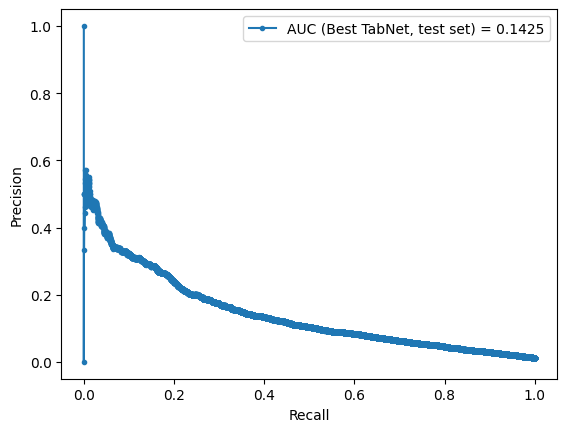

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_valid and probabilities are available
#y_valid =  y_valid
probabilities = clf.predict_proba(X_test_array)[:, 1]  # Probabilities of the positive class

# Calculate the "No Skill" precision

# Calculate precision-recall pairs
precision_dt, recall_dt, _ = precision_recall_curve(y_test, probabilities)
auc_dt = auc(recall_dt, precision_dt)

# Plot the precision-recall curve

plt.plot(recall_dt, precision_dt, marker=".", label=f"AUC (Best TabNet, test set) = {auc_dt:.4f}")

# Axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [22]:
##custom scorer
from sklearn.metrics import recall_score

#obtain predicted probabilities for the positive class from the model
y_prob = clf.predict_proba(X_test_array)[:, 1]

#make a list of touples with predicted probabilities and true labels in descending order
sorted_probs = sorted(zip(y_prob, y_test), key=lambda x: x[0], reverse=True)

#calculate cumulative sum of true positives
cumulative_tp = [0] + list(np.cumsum([y == 1 for _, y in sorted_probs]))

#find the threshold where cumulative TP is closest to 90%
target_cumulative_tp = int(0.9 * cumulative_tp[-1])
threshold = next(prob for prob, _ in sorted_probs if cumulative_tp[np.searchsorted(cumulative_tp, target_cumulative_tp)] >= target_cumulative_tp) #find the threshold value where the cumulative TP is the closest to the target cumulative TP

#applu the threshold to classify positive and negative instances
y_pred_test = (y_prob >= threshold).astype(int) #astype to convert booleans to 0 and 1

#evaluate the model using the chosen threshold
conf_matrix = confusion_matrix(y_test, y_pred_test)
fpr = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
recall = recall_score(y_test, y_pred_test)

print(f"Chosen threshold: {threshold}")
print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(conf_matrix)



Chosen threshold: 0.9975169897079468
False Positive Rate: 5.055765088930908e-06
Recall: 0.0
[[197793      1]
 [  2206      0]]


In [23]:
joblib.dump(clf, 'tabnet_class_weights_pretrained.joblib')

['tabnet_class_weights_pretrained.joblib']